In [5]:
"""
****************************************
 * @author: Xin Zhang
 * Date: 5/22/21
****************************************
"""
import time
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from random import sample
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import copy

activation_fcts = [
    'relu', "sigmoid", "softmax", "softplus", "softsign", "tanh", "selu", "elu", "exponential"
]
optimizers = ["sgd", "rmsprop", "adam", "adadelta", "adagrad", "adamax", "nadam", "ftrl"]
losses = ["mae", "mape", "mse", "msle", "poisson", "categorical_crossentropy"]
rnn_layer_types = ['SimpleRNN', 'LSTM', 'GRU']

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_start_time = time.time()
        self.epoch_times = []
        self.batch_times = []
        self.epoch_times_detail = []
        self.batch_times_detail = []

    def on_train_end(self, logs={}):
        self.train_end_time = time.time()

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        epoch_time_end = time.time()
        self.epoch_times.append(epoch_time_end - self.epoch_time_start)
        self.epoch_times_detail.append((self.epoch_time_start, epoch_time_end))

    def on_train_batch_begin(self, batch, logs={}):
        self.bacth_time_start = time.time()

    def on_train_batch_end(self, batch, logs={}):
        batch_time_end = time.time()
        self.batch_times.append(batch_time_end - self.bacth_time_start)
        self.batch_times_detail.append((self.bacth_time_start, batch_time_end))

    def relative_by_train_start(self):
        self.epoch_times_detail = np.array(self.epoch_times_detail) - self.train_start_time
        self.batch_times_detail = np.array(self.batch_times_detail) - self.train_start_time
        self.train_end_time = np.array(self.train_end_time) - self.train_start_time


class gen_rnn:
    def __init__(
        self,
        rnn_layers_num_lower=1,
        rnn_layers_num_upper=10,
        rnn_layer_size_lower=1,
        rnn_layer_size_upper=101,
        dense_layers_num_lower=1,
        dense_layers_num_upper=3,
        dense_layer_size_lower=1,
        dense_layer_size_upper=6,
        activation='random',
        optimizer='random',
        loss='random',
        rnn_layer_type='random'
    ):
        self.rnn_layers_num_lower = rnn_layers_num_lower
        self.rnn_layers_num_upper = rnn_layers_num_upper
        self.rnn_layer_size_lower = rnn_layer_size_lower
        self.rnn_layer_size_upper = rnn_layer_size_upper
        self.dense_layers_num_lower=dense_layers_num_lower,
        self.dense_layers_num_upper=dense_layers_num_upper,
        self.dense_layer_size_lower=dense_layer_size_lower,
        self.dense_layer_size_upper=dense_layer_size_upper,
        self.activation_pick = activation
        self.optimizer_pick = optimizer
        self.loss_pick = loss
        self.rnn_layer_type_pick = rnn_layer_type
        self.activation_fcts = activation_fcts
        self.optimizers = optimizers
        self.losses = losses
        self.rnn_layer_types = rnn_layer_types

    @staticmethod
    def nothing(x):
        return x

    @staticmethod
    def build_RNN_model(layer_type, rnn_layer_sizes, dense_layer_sizes, activations, optimizer, loss):
        if layer_type == 'SimpleRNN':
            rnn_layer = SimpleRNN
        if layer_type == 'LSTM':
            rnn_layer = LSTM
        if layer_type == 'GRU':
            rnn_layer = GRU
        
        model = Sequential()
        for index, size in enumerate(rnn_layer_sizes + dense_layer_sizes):
            if index < len(rnn_layer_sizes)-1:
                model.add(rnn_layer(units=size, activation=activations[index], return_sequences=True))
            elif index == len(rnn_layer_sizes)-1:
                model.add(rnn_layer(units=size, activation=activations[index]))
            else:
                model.add(Dense(units=size, activation=activations[index]))
        model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
        return model

    @staticmethod
    def get_RNN_model_features(keras_model):
        layers = [
            layer_info for layer_info in keras_model.get_config()['layers']
            if layer_info['class_name'] == 'SimpleRNN' or layer_info['class_name'] == 'LSTM' or layer_info['class_name'] == 'GRU' or layer_info['class_name'] == 'Dense'
        ]
        layer_sizes = [l['config']['units'] for l in layers]
        acts = [l['config']['activation'].lower() for l in layers]
        layer_Type = [l['class_name'] for l in layers]
        return layer_sizes, acts, layer_Type

    def generate_model(self):
        rnn_layers_num = np.random.randint(
            self.rnn_layers_num_lower, self.rnn_layers_num_upper
        )
        rnn_layer_sizes = np.random.randint(
            self.rnn_layer_size_lower, self.rnn_layer_size_upper, rnn_layers_num
        )
        dense_layers_num = np.random.randint(
            self.dense_layers_num_lower, self.dense_layers_num_upper
        )
        dense_layer_sizes = np.random.randint(
            self.dense_layer_size_lower, self.dense_layer_size_upper, dense_layers_num
        )


        if self.activation_pick == 'random':
            activations = np.random.choice(self.activation_fcts, rnn_layers_num + dense_layers_num)
        else:
            activations = np.random.choice([self.activation_pick], rnn_layers_num + dense_layers_num)
        if self.optimizer_pick == 'random':
            optimizer = np.random.choice(self.optimizers)
        else:
            optimizer = self.optimizer_pick
        if self.loss_pick == 'random':
            loss = np.random.choice(self.losses)
        else:
            loss = self.loss_pick
        if self.rnn_layer_type_pick == 'random':
            rnn_layer = np.random.choice(self.rnn_layer_types)
        else:
            rnn_layer = self.rnn_layer_type_pick

        return {
            #'model': gen_rnn.build_RNN_model(rnn_layer, list(rnn_layer_sizes), list(dense_layer_sizes), activations, optimizer, loss),
            'rnn_layer_sizes': [int(i) for i in rnn_layer_sizes],
            'dense_layer_sizes': [int(i) for i in dense_layer_sizes],
            'activations': list(activations),
            'optimizer': optimizer,
            'loss': loss,
            'rnn_type': rnn_layer,
        }

    def generate_model_configs(self, num_model_data=1000, progress=True):
        model_configs = []
        if progress:
            loop_fun = tqdm
        else:
            loop_fun = gen_rnn.nothing
        for i in loop_fun(range(num_model_data)):
            data = self.generate_model()
            #del data['model']
            model_configs.append(data)
        return model_configs


class model_train_data:
    def __init__(
        self,
        model_configs,
        input_dims=None,
        batch_sizes=None,
        epochs=None,
        truncate_from=None,
        trials=None,
        input_dim_strategy='same'
    ):
        """

        @param model_configs:
        @param input_dims:  input data number of features
        @param batch_sizes:
        @param epochs:
        @param truncate_from:
        @param trials:
        @param input_dim_strategy: 'random' or 'same', same will be same size as first layer size
        """
        self.model_configs = []
        for info_dict in model_configs:
            d2 = copy.deepcopy(info_dict)
            self.model_configs.append(d2)
        self.input_dims = input_dims if input_dims is not None else list(range(1, 101))
        self.batch_sizes = batch_sizes if batch_sizes is not None else [2**i for i in range(1, 9)]
        self.epochs = epochs if epochs is not None else 10
        self.truncate_from = truncate_from if truncate_from is not None else 2
        self.trials = trials if trials is not None else 5
        self.input_dim_strategy = input_dim_strategy
        self.activation_fcts = activation_fcts
        self.optimizers = optimizers
        self.losses = losses
        self.act_mapping = dict((act, index + 1) for index, act in enumerate(self.activation_fcts))
        self.opt_mapping = dict((opt, index + 1) for index, opt in enumerate(self.optimizers))
        self.loss_mapping = dict((loss, index + 1) for index, loss in enumerate(self.losses))

    def get_train_data(self, progress=True):
        model_data = []
        model_configs = []
        if progress:
            loop_fun = tqdm
        else:
            loop_fun = gen_nn.nothing
        for info_dict in self.model_configs:
            d2 = copy.deepcopy(info_dict)
            model_configs.append(d2)
        for model_config in loop_fun(model_configs):
            model = gen_rnn.build_RNN_model(layer_type=model_config['rnn_type'], 
                                            rnn_layer_sizes=model_config['rnn_layer_sizes'], 
                                            dense_layer_sizes=model_config['dense_layer_sizes'], 
                                            activations=model_config['activations'], 
                                            optimizer=model_config['optimizer'], 
                                            loss=model_config['loss'])
            batch_sizes = sample(self.batch_sizes, 1)
            input_dim = sample(self.input_dims, 1)[0]
            for batch_size in batch_sizes:
                batch_size_data_batch = []
                batch_size_data_epoch = []
                if self.input_dim_strategy == 'same':
                    try:
                        input_shape = model.get_config()['layers'][0]['config']['units']
                    except:
                        input_shape = model.get_config(
                        )['layers'][0]['config']['batch_input_shape'][2]
                else:
                    input_shape = input_dim
                out_shape = model.get_config()['layers'][-1]['config']['units']
                x = np.ones((batch_size, 1, input_shape), dtype=np.float32)
                y = np.ones((batch_size, out_shape), dtype=np.float32)
                for _ in range(self.trials):
                    time_callback = TimeHistory()
                    model.fit(
                        x,
                        y,
                        epochs=self.epochs,
                        batch_size=batch_size,
                        callbacks=[time_callback],
                        verbose=False
                    )
                    times_batch = np.array(time_callback.batch_times) * 1000
                    times_epoch = np.array(time_callback.epoch_times) * 1000
                    batch_size_data_batch.extend(times_batch)
                    batch_size_data_epoch.extend(times_epoch)

                batch_times_truncated = batch_size_data_batch[self.truncate_from:]
                epoch_times_trancuted = batch_size_data_epoch[self.truncate_from:]
                recovered_time = [
                    np.median(batch_times_truncated)
                ] * self.truncate_from + batch_times_truncated

                model_config['batch_size']= batch_size
                model_config['batch_time']= np.median(batch_times_truncated)
                model_config['epoch_time']= np.median(epoch_times_trancuted)
                model_config['setup_time']= np.sum(batch_size_data_batch) - sum(recovered_time)
                model_config['input_dim']= input_shape
            model_data.append(model_config)
        return model_data

    def convert_config_data(
        self,
        model_data,
        layer_num_upper,
        layer_na_fill=0,
        act_na_fill=0,
        opt_dummy=True,
        loss_dummy=True,
        min_max_scaler=True
    ):
        data_rows = []
        time_rows = []

        for model_i_data in model_data:
            layer_sizes = model_i_data['layer_sizes'] + [layer_na_fill] * layer_num_upper
            layer_sizes = layer_sizes[:layer_num_upper]
            activations = [self.act_mapping[i]
                           for i in model_i_data['activations']] + [act_na_fill] * layer_num_upper
            activations = activations[:layer_num_upper]
            if opt_dummy:
                optimizer = model_i_data['optimizer']
            else:
                optimizer = self.opt_mapping[model_i_data['optimizer']]
            if loss_dummy:
                loss = model_i_data['loss']
            else:
                loss = self.loss_mapping[model_i_data['loss']]
            batch_names = [k for k in model_i_data.keys() if k.startswith('batch_size')]

            for batch_name in batch_names:
                batch_value = int(batch_name.split('_')[-1])
                batch_time = model_i_data[batch_name]['batch_time']
                epoch_time = model_i_data[batch_name]['epoch_time']
                setup_time = model_i_data[batch_name]['setup_time']
                input_dim = model_i_data[batch_name]['input_dim']
                data_rows.append(
                    layer_sizes + activations + [optimizer, loss, batch_value, input_dim]
                )
                time_rows.append([batch_time, epoch_time, setup_time])

        layer_names = [f'layer_{i + 1}_size' for i in range(layer_num_upper)]
        act_names = [f'layer_{i + 1}_activation' for i in range(layer_num_upper)]
        temp_df = pd.DataFrame(
            data_rows,
            columns=layer_names + act_names + ['optimizer', 'loss', 'batch_size', 'input_dim']
        )
        if opt_dummy:
            first_row = dict(temp_df.iloc[0])
            for opt in self.optimizers:
                first_row['optimizer'] = opt
                temp_df = temp_df.append(first_row, ignore_index=True)
            temp_df = pd.get_dummies(temp_df, columns=['optimizer'])
            temp_df = temp_df.drop(temp_df.index.tolist()[-len(self.optimizers):])
        if loss_dummy:
            first_row = dict(temp_df.iloc[0])
            for los in self.losses:
                first_row['loss'] = los
                temp_df = temp_df.append(first_row, ignore_index=True)
            temp_df = pd.get_dummies(temp_df, columns=['loss'])
            temp_df = temp_df.drop(temp_df.index.tolist()[-len(self.losses):])
        time_df = pd.DataFrame(time_rows, columns=['batch_time', 'epoch_time', 'setup_time'])
        if min_max_scaler:
            scaler = MinMaxScaler()
            scaled_data = scaler.fit_transform(temp_df.to_numpy())
            temp_df = pd.DataFrame(scaled_data, columns=temp_df.columns)
            return pd.concat([temp_df, time_df], axis=1), scaler
        else:
            return pd.concat([temp_df, time_df], axis=1), None

    def convert_model_data(
        self,
        keras_model,
        layer_num_upper,
        optimizer,
        loss,
        batch_size,
        input_dim=None,
        layer_na_fill=0,
        act_na_fill=0,
        scaler=None,
        opt_dummy=True,
        loss_dummy=True,
    ):
        layer_sizes, acts = gen_nn.get_dense_model_features(keras_model)
        if input_dim is None:
            input_dim = layer_sizes[0]
        layer_sizes = layer_sizes + [layer_na_fill] * layer_num_upper
        layer_sizes = layer_sizes[:layer_num_upper]
        acts = [self.act_mapping[i] for i in acts]
        acts = acts + [act_na_fill] * layer_num_upper
        acts = acts[:layer_num_upper]
        if opt_dummy:
            optimizer = optimizer.lower()
        else:
            optimizer = self.opt_mapping[optimizer.lower()]
        if loss_dummy:
            loss = loss.lower()
        else:
            loss = self.loss_mapping[loss.lower()]
        data = layer_sizes + acts + [optimizer, loss, batch_size, input_dim]
        layer_names = [f'layer_{i + 1}_size' for i in range(layer_num_upper)]
        act_names = [f'layer_{i + 1}_activation' for i in range(layer_num_upper)]
        temp_df = pd.DataFrame([data],
                               columns=layer_names + act_names +
                               ['optimizer', 'loss', 'batch_size', 'input_dim'])
        if opt_dummy:
            first_row = dict(temp_df.iloc[0])
            for opt in self.optimizers:
                first_row['optimizer'] = opt
                temp_df = temp_df.append(first_row, ignore_index=True)
            temp_df = pd.get_dummies(temp_df, columns=['optimizer'])
            temp_df = temp_df.drop(temp_df.index.tolist()[-len(self.optimizers):])
        if loss_dummy:
            first_row = dict(temp_df.iloc[0])
            for los in self.losses:
                first_row['loss'] = los
                temp_df = temp_df.append(first_row, ignore_index=True)
            temp_df = pd.get_dummies(temp_df, columns=['loss'])
            temp_df = temp_df.drop(temp_df.index.tolist()[-len(self.losses):])

        if scaler is None:
            return temp_df
        else:
            scaled_data = scaler.transform(temp_df.to_numpy())
            return pd.DataFrame(scaled_data, columns=temp_df.columns)

class convert_dense_data:
    def __init__(self):
        self.optimizers = optimizers

        unique_all_optimizers = sorted(list(set(self.optimizers)))
        enc = OneHotEncoder(handle_unknown='ignore')
        x_opts = [[i] for i in unique_all_optimizers]
        enc.fit(x_opts)
        self.enc = enc

    @staticmethod
    def dense_layer_flops(i, o):
        return (2 * i - 1) * o

    @staticmethod
    def get_flops_dense(input_shape, dense_model_obj, sum_all=True):
        dense_flops = []
        for idx, layer_data in enumerate(dense_model_obj.get_config()['layers']):
            layer_name = layer_data['class_name']
            layer_config = layer_data['config']
            if layer_name == 'Dense':
                flops = convert_dense_data.dense_layer_flops(input_shape, layer_config['units'])
                input_shape = layer_config['units']
                dense_flops.append(flops)
        if sum_all:
            return sum(dense_flops)
        else:
            return dense_flops

    @staticmethod
    def get_units_sum_dense_keras(dense_model_obj):
        return sum([
            layer['config']['units'] for layer in dense_model_obj.get_config()['layers']
            if layer['class_name'] == 'Dense'
        ])

    def convert_model_config(self, model_config_dense, data_type='Unit', min_max_scaler=True):
        """

        @param model_config_dense:
        @param data_type: str "Units" or "FLOPs"
        @param min_max_scaler:
        @return:
        """
        all_batch_sizes = []
        all_optimizers = []
        flops_data = []
        units_data = []
        times_data = []
        for index, model_config in enumerate(tqdm(model_config_dense)):
            batch_name = [i for i in model_config.keys() if i.startswith('batch_size')][0]
            input_shape = model_config[batch_name]['input_dim']
            batch_size = int(batch_name.split('_')[-1])
            all_batch_sizes.append(batch_size)
            all_optimizers.append(model_config['optimizer'])
            if data_type.lower().startswith('f'):
                model = gen_nn.build_dense_model(
                    layer_sizes=model_config['layer_sizes'],
                    activations=model_config['activations'],
                    optimizer=model_config['optimizer'],
                    loss=model_config['loss']
                )

                flops = convert_dense_data.get_flops_dense(input_shape, model, sum_all=True)
                flops_data.append(flops)
            units_data.append(sum(model_config['layer_sizes']))
            times_data.append(model_config[batch_name]['batch_time'])

        if data_type.lower().startswith('u'):
            layer_data = units_data.copy()
        elif data_type.lower().startswith('f'):
            layer_data = flops_data.copy()
        else:
            layer_data = units_data.copy()

        dense_data = []
        for size, batch, opt in tqdm(list(zip(layer_data, all_batch_sizes, all_optimizers))):
            optimizer_onehot = list(self.enc.transform([[opt]]).toarray()[0])
            dense_data.append([size] + [batch] + optimizer_onehot)

        if min_max_scaler:
            scaler = MinMaxScaler()
            scaler.fit(dense_data)
            scaler_dense_data = scaler.transform(dense_data)
            return scaler_dense_data, np.array(times_data), scaler
        else:
            return dense_data, np.array(times_data), None

    def convert_model_keras(
        self, input_shape, dense_model_obj, optimizer, batch_size, data_type='Unit', scaler=None
    ):
        flops = convert_dense_data.get_flops_dense(input_shape, dense_model_obj, sum_all=True)
        unit_sum = convert_dense_data.get_units_sum_dense_keras(dense_model_obj)

        if data_type.lower().startswith('f'):
            layer_data = flops
        elif data_type.lower().startswith('u'):
            layer_data = unit_sum
        else:
            layer_data = unit_sum

        optimizer_onehot = list(self.enc.transform([[optimizer]]).toarray()[0])
        layer_data = [layer_data] + [batch_size] + optimizer_onehot

        if scaler is not None:
            scaled_data = scaler.transform(np.array([layer_data]))
            return scaled_data
        else:
            return layer_data



In [7]:
g= gen_rnn()

In [8]:
model_configs = g.generate_model_configs(5000)

100%|██████████| 5000/5000 [00:00<00:00, 5027.82it/s]


In [9]:
mtd = model_train_data(model_configs)

In [10]:
model_data = mtd.get_train_data()

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 2/5000 [00:12<7:35:29,  5.47s/it] 

  0%|          | 3/5000 [00:13<4:57:41,  3.57s/it]

  0%|          | 7/5000 [00:35<6:48:50,  4.91s/it]

  0%|          | 9/5000 [00:46<7:01:26,  5.07s/it]

  0%|          | 10/5000 [00:50<6:36:59,  4.77s/it]

  0%|          | 11/5000 [00:53<5:42:35,  4.12s/it]

  0%|          | 15/5000 [01:07<4:34:47,  3.31s/it]

  0%|          | 16/5000 [01:08<3:43:23,  2.69s/it]

  0%|          | 17/5000 [01:11<3:52:16,  2.80s/it]

  0%|          | 18/5000 [01:16<4:35:22,  3.32s/it]

  0%|          | 19/5000 [01:20<4:40:45,  3.38s/it]

  0%|          | 20/5000 [01:26<5:47:31,  4.19s/it]

  0%|          | 21/5000 [01:28<5:11:50,  3.76s/it]

  0%|          | 22/5000 [01:30<4:20:01,  3.13s/it]

  0%|          | 23/5000 [01:37<5:45:37,  4.17s/it]

  0%|          | 24/5000 [01:41<5:48:44,  4.21s/it]

  0%|          | 25/5000 [01:47<6:24:33,  4.64s/it]

  1%|          | 26/5000 [01:50<5:44:55,  4.16s/it]

  1%|          | 29/5000 [02:02<5:21:09,  3.88s/it]

  1%|          | 32/5000 [02:14<5:19:30,  3.86s/it]

  1%|          | 33/5000 [02:19<5:43:24,  4.15s/it]

  1%|          | 34/5000 [02:26<7:05:29,  5.14s/it]

  1%|          | 36/5000 [02:36<6:37:16,  4.80s/it]

  1%|          | 37/5000 [02:42<7:22:49,  5.35s/it]

  1%|          | 38/5000 [02:44<5:55:58,  4.30s/it]

  1%|          | 39/5000 [02:47<5:16:35,  3.83s/it]

  1%|          | 42/5000 [03:02<6:43:13,  4.88s/it]

  1%|          | 44/5000 [03:09<5:52:09,  4.26s/it]

  1%|          | 45/5000 [03:17<7:04:24,  5.14s/it]

  1%|          | 47/5000 [03:26<6:25:41,  4.67s/it]

  1%|          | 52/5000 [03:39<4:26:42,  3.23s/it]

  1%|          | 53/5000 [03:42<3:57:09,  2.88s/it]

  1%|          | 54/5000 [03:43<3:17:29,  2.40s/it]

  1%|          | 55/5000 [03:47<3:55:45,  2.86s/it]

  1%|          | 57/5000 [03:54<4:10:01,  3.03s/it]

  1%|          | 58/5000 [03:57<4:21:40,  3.18s/it]

  1%|          | 59/5000 [04:00<4:13:28,  3.08s/it]

  1%|          | 60/5000 [04:09<6:40:21,  4.86s/it]

  1%|          | 61/5000 [04:11<5:20:33,  3.89s/it]

  1%|          | 62/5000 [04:18<6:48:31,  4.96s/it]

  1%|▏         | 64/5000 [04:31<7:46:23,  5.67s/it]

  1%|▏         | 65/5000 [04:38<8:19:53,  6.08s/it]

  1%|▏         | 66/5000 [04:42<7:19:25,  5.34s/it]

  1%|▏         | 69/5000 [04:53<5:19:35,  3.89s/it]

  1%|▏         | 71/5000 [05:01<5:08:36,  3.76s/it]

  1%|▏         | 72/5000 [05:10<7:11:28,  5.25s/it]

  2%|▏         | 75/5000 [05:27<7:19:19,  5.35s/it]

  2%|▏         | 76/5000 [05:35<8:30:37,  6.22s/it]

  2%|▏         | 79/5000 [05:53<8:19:37,  6.09s/it]

  2%|▏         | 81/5000 [06:04<7:30:05,  5.49s/it]

  2%|▏         | 83/5000 [06:14<7:11:48,  5.27s/it]

  2%|▏         | 86/5000 [06:25<6:00:01,  4.40s/it]

  2%|▏         | 87/5000 [06:29<6:00:42,  4.41s/it]

  2%|▏         | 88/5000 [06:38<7:37:39,  5.59s/it]

  2%|▏         | 89/5000 [06:43<7:35:05,  5.56s/it]

  2%|▏         | 90/5000 [06:52<8:48:47,  6.46s/it]

  2%|▏         | 92/5000 [07:07<9:12:55,  6.76s/it] 

  2%|▏         | 93/5000 [07:11<8:17:25,  6.08s/it]

  2%|▏         | 95/5000 [07:15<5:18:08,  3.89s/it]

  2%|▏         | 96/5000 [07:22<6:50:04,  5.02s/it]

  2%|▏         | 97/5000 [07:29<7:21:38,  5.40s/it]

  2%|▏         | 98/5000 [07:33<6:53:29,  5.06s/it]

  2%|▏         | 99/5000 [07:39<7:26:47,  5.47s/it]

  2%|▏         | 100/5000 [07:45<7:18:34,  5.37s/it]

  2%|▏         | 102/5000 [07:54<6:49:12,  5.01s/it]

  2%|▏         | 103/5000 [07:58<6:32:47,  4.81s/it]

  2%|▏         | 105/5000 [08:07<6:21:04,  4.67s/it]

  2%|▏         | 106/5000 [08:11<6:04:23,  4.47s/it]

  2%|▏         | 109/5000 [08:27<6:16:50,  4.62s/it]

  2%|▏         | 110/5000 [08:29<4:57:40,  3.65s/it]

  2%|▏         | 114/5000 [08:41<4:08:35,  3.05s/it]

  2%|▏         | 115/5000 [08:44<4:11:33,  3.09s/it]

  2%|▏         | 116/5000 [08:54<6:53:05,  5.07s/it]

  2%|▏         | 121/5000 [09:13<5:28:04,  4.03s/it]

  2%|▏         | 122/5000 [09:19<6:35:03,  4.86s/it]

  2%|▏         | 123/5000 [09:26<7:27:52,  5.51s/it]

  2%|▏         | 124/5000 [09:33<7:48:31,  5.77s/it]

  2%|▎         | 125/5000 [09:38<7:27:24,  5.51s/it]

  3%|▎         | 127/5000 [09:48<6:55:00,  5.11s/it]

  3%|▎         | 128/5000 [09:49<5:20:51,  3.95s/it]

  3%|▎         | 131/5000 [10:05<6:16:42,  4.64s/it]

  3%|▎         | 132/5000 [10:11<6:58:14,  5.15s/it]

  3%|▎         | 133/5000 [10:14<6:00:41,  4.45s/it]

  3%|▎         | 134/5000 [10:23<7:43:36,  5.72s/it]

  3%|▎         | 135/5000 [10:28<7:46:56,  5.76s/it]

  3%|▎         | 136/5000 [10:35<7:57:25,  5.89s/it]

  3%|▎         | 137/5000 [10:37<6:40:37,  4.94s/it]

  3%|▎         | 138/5000 [10:40<5:48:42,  4.30s/it]

  3%|▎         | 139/5000 [10:48<7:20:06,  5.43s/it]

  3%|▎         | 140/5000 [10:50<5:41:44,  4.22s/it]

  3%|▎         | 141/5000 [10:52<5:08:59,  3.82s/it]

  3%|▎         | 142/5000 [10:55<4:35:48,  3.41s/it]

  3%|▎         | 144/5000 [10:58<3:15:56,  2.42s/it]

  3%|▎         | 145/5000 [11:00<3:16:56,  2.43s/it]

  3%|▎         | 146/5000 [11:02<3:07:20,  2.32s/it]

  3%|▎         | 147/5000 [11:08<4:15:40,  3.16s/it]

  3%|▎         | 149/5000 [11:11<3:05:34,  2.30s/it]

  3%|▎         | 150/5000 [11:14<3:37:22,  2.69s/it]

  3%|▎         | 152/5000 [11:23<4:59:26,  3.71s/it]

  3%|▎         | 154/5000 [11:32<5:11:45,  3.86s/it]

  3%|▎         | 157/5000 [11:46<5:57:50,  4.43s/it]

  3%|▎         | 159/5000 [11:54<5:31:38,  4.11s/it]

  3%|▎         | 160/5000 [12:01<6:54:34,  5.14s/it]

  3%|▎         | 162/5000 [12:08<6:01:11,  4.48s/it]

  3%|▎         | 163/5000 [12:12<5:44:49,  4.28s/it]

  3%|▎         | 164/5000 [12:17<6:07:31,  4.56s/it]

  3%|▎         | 166/5000 [12:24<5:17:53,  3.95s/it]

  3%|▎         | 167/5000 [12:29<5:56:58,  4.43s/it]

  3%|▎         | 168/5000 [12:39<8:05:49,  6.03s/it]

  3%|▎         | 171/5000 [12:47<5:35:57,  4.17s/it]

  3%|▎         | 172/5000 [12:54<6:43:27,  5.01s/it]

  3%|▎         | 173/5000 [12:56<5:29:55,  4.10s/it]

  3%|▎         | 174/5000 [13:00<5:18:55,  3.97s/it]

  4%|▎         | 175/5000 [13:08<7:01:53,  5.25s/it]

  4%|▎         | 176/5000 [13:11<6:09:35,  4.60s/it]

  4%|▎         | 177/5000 [13:13<5:13:12,  3.90s/it]

  4%|▎         | 179/5000 [13:22<5:33:52,  4.16s/it]

  4%|▎         | 180/5000 [13:31<7:29:16,  5.59s/it]

  4%|▎         | 181/5000 [13:32<5:45:21,  4.30s/it]

  4%|▎         | 182/5000 [13:38<6:16:37,  4.69s/it]

  4%|▎         | 183/5000 [13:43<6:25:20,  4.80s/it]

  4%|▎         | 184/5000 [13:48<6:18:12,  4.71s/it]

  4%|▎         | 185/5000 [13:50<5:23:17,  4.03s/it]

  4%|▎         | 186/5000 [13:54<5:32:45,  4.15s/it]

  4%|▎         | 187/5000 [14:01<6:23:37,  4.78s/it]

  4%|▍         | 189/5000 [14:10<6:02:25,  4.52s/it]

  4%|▍         | 191/5000 [14:23<7:11:02,  5.38s/it]

  4%|▍         | 192/5000 [14:27<6:29:52,  4.87s/it]

  4%|▍         | 193/5000 [14:29<5:32:21,  4.15s/it]

  4%|▍         | 194/5000 [14:35<6:15:57,  4.69s/it]

  4%|▍         | 195/5000 [14:39<6:02:06,  4.52s/it]

  4%|▍         | 196/5000 [14:46<6:46:23,  5.08s/it]

  4%|▍         | 198/5000 [14:53<5:59:43,  4.49s/it]

  4%|▍         | 199/5000 [14:59<6:23:36,  4.79s/it]

  4%|▍         | 200/5000 [15:03<5:54:46,  4.43s/it]

  4%|▍         | 203/5000 [15:15<5:46:40,  4.34s/it]

  4%|▍         | 204/5000 [15:17<4:59:34,  3.75s/it]

  4%|▍         | 206/5000 [15:27<5:35:55,  4.20s/it]

  4%|▍         | 207/5000 [15:30<4:58:18,  3.73s/it]

  4%|▍         | 208/5000 [15:38<6:37:41,  4.98s/it]

  4%|▍         | 209/5000 [15:45<7:35:04,  5.70s/it]

  4%|▍         | 211/5000 [15:53<6:25:50,  4.83s/it]

  4%|▍         | 212/5000 [16:00<7:22:18,  5.54s/it]

  4%|▍         | 213/5000 [16:06<7:32:41,  5.67s/it]

  4%|▍         | 214/5000 [16:09<6:30:47,  4.90s/it]

  4%|▍         | 215/5000 [16:12<5:32:30,  4.17s/it]

  4%|▍         | 217/5000 [16:22<5:49:41,  4.39s/it]

  4%|▍         | 219/5000 [16:30<5:30:24,  4.15s/it]

  4%|▍         | 220/5000 [16:32<4:55:34,  3.71s/it]

  4%|▍         | 221/5000 [16:35<4:43:03,  3.55s/it]

  4%|▍         | 222/5000 [16:41<5:37:52,  4.24s/it]

  4%|▍         | 223/5000 [16:44<5:03:51,  3.82s/it]

  4%|▍         | 224/5000 [16:52<6:29:27,  4.89s/it]

  4%|▍         | 225/5000 [16:57<6:44:30,  5.08s/it]

  5%|▍         | 226/5000 [17:03<7:02:53,  5.31s/it]

  5%|▍         | 227/5000 [17:13<8:54:34,  6.72s/it]

  5%|▍         | 228/5000 [17:16<7:24:34,  5.59s/it]

  5%|▍         | 230/5000 [17:20<5:14:20,  3.95s/it]

  5%|▍         | 233/5000 [17:37<6:21:04,  4.80s/it]

  5%|▍         | 234/5000 [17:38<4:55:50,  3.72s/it]

  5%|▍         | 235/5000 [17:43<5:39:58,  4.28s/it]

  5%|▍         | 236/5000 [17:48<5:59:26,  4.53s/it]

  5%|▍         | 237/5000 [17:50<5:00:29,  3.79s/it]

  5%|▍         | 238/5000 [17:52<4:16:17,  3.23s/it]

  5%|▍         | 241/5000 [18:06<5:14:56,  3.97s/it]

  5%|▍         | 242/5000 [18:13<6:46:43,  5.13s/it]

  5%|▍         | 243/5000 [18:20<7:30:56,  5.69s/it]

  5%|▍         | 246/5000 [18:36<6:58:40,  5.28s/it]

  5%|▍         | 248/5000 [18:45<6:25:06,  4.86s/it]

  5%|▍         | 249/5000 [18:49<6:04:45,  4.61s/it]

  5%|▌         | 251/5000 [18:56<5:35:13,  4.24s/it]

  5%|▌         | 252/5000 [18:57<4:25:30,  3.36s/it]

  5%|▌         | 253/5000 [18:59<3:36:27,  2.74s/it]

  5%|▌         | 254/5000 [19:06<5:29:19,  4.16s/it]

  5%|▌         | 255/5000 [19:13<6:27:29,  4.90s/it]

  5%|▌         | 256/5000 [19:21<7:52:24,  5.97s/it]

  5%|▌         | 257/5000 [19:30<9:06:43,  6.92s/it]

  5%|▌         | 258/5000 [19:34<7:53:44,  5.99s/it]

  5%|▌         | 259/5000 [19:40<7:59:01,  6.06s/it]

  5%|▌         | 260/5000 [19:48<8:35:18,  6.52s/it]

  5%|▌         | 262/5000 [20:01<8:35:45,  6.53s/it]

  5%|▌         | 263/5000 [20:09<9:08:38,  6.95s/it]

  5%|▌         | 264/5000 [20:14<8:24:00,  6.39s/it]

  5%|▌         | 265/5000 [20:24<9:36:45,  7.31s/it]

  5%|▌         | 267/5000 [20:32<7:12:30,  5.48s/it]

  5%|▌         | 268/5000 [20:34<6:04:31,  4.62s/it]

  5%|▌         | 270/5000 [20:42<5:22:36,  4.09s/it]

  5%|▌         | 271/5000 [20:44<4:33:55,  3.48s/it]

  5%|▌         | 272/5000 [20:48<4:31:16,  3.44s/it]

  5%|▌         | 273/5000 [20:49<3:39:38,  2.79s/it]

  5%|▌         | 274/5000 [20:58<5:58:21,  4.55s/it]

  6%|▌         | 276/5000 [21:07<5:36:26,  4.27s/it]

  6%|▌         | 278/5000 [21:14<5:19:47,  4.06s/it]

  6%|▌         | 279/5000 [21:17<4:48:37,  3.67s/it]

  6%|▌         | 281/5000 [21:26<5:08:48,  3.93s/it]

  6%|▌         | 283/5000 [21:39<6:42:49,  5.12s/it]

  6%|▌         | 285/5000 [21:45<4:57:06,  3.78s/it]

  6%|▌         | 286/5000 [21:49<5:20:24,  4.08s/it]

  6%|▌         | 288/5000 [21:59<5:27:13,  4.17s/it]

  6%|▌         | 289/5000 [22:06<6:41:44,  5.12s/it]

  6%|▌         | 292/5000 [22:16<4:51:08,  3.71s/it]

  6%|▌         | 293/5000 [22:22<5:52:18,  4.49s/it]

  6%|▌         | 295/5000 [22:28<4:54:33,  3.76s/it]

  6%|▌         | 297/5000 [22:38<5:43:57,  4.39s/it]

  6%|▌         | 298/5000 [22:43<6:05:19,  4.66s/it]

  6%|▌         | 299/5000 [22:45<5:18:15,  4.06s/it]

  6%|▌         | 300/5000 [22:53<6:35:00,  5.04s/it]

  6%|▌         | 302/5000 [23:04<6:48:36,  5.22s/it]

  6%|▌         | 304/5000 [23:11<5:51:05,  4.49s/it]

  6%|▌         | 305/5000 [23:16<6:10:58,  4.74s/it]

  6%|▌         | 306/5000 [23:20<5:54:32,  4.53s/it]

  6%|▌         | 307/5000 [23:25<5:54:52,  4.54s/it]

  6%|▌         | 308/5000 [23:31<6:35:58,  5.06s/it]

  6%|▌         | 309/5000 [23:37<6:59:49,  5.37s/it]

  6%|▌         | 311/5000 [23:45<6:11:15,  4.75s/it]

  6%|▌         | 312/5000 [23:47<5:06:43,  3.93s/it]

  6%|▋         | 313/5000 [23:51<5:18:55,  4.08s/it]

  6%|▋         | 314/5000 [23:56<5:37:50,  4.33s/it]

  6%|▋         | 315/5000 [24:03<6:54:18,  5.31s/it]

  6%|▋         | 317/5000 [24:12<6:09:54,  4.74s/it]

  6%|▋         | 318/5000 [24:16<5:48:38,  4.47s/it]

  6%|▋         | 321/5000 [24:26<4:54:26,  3.78s/it]

  6%|▋         | 324/5000 [24:39<5:16:21,  4.06s/it]

  6%|▋         | 325/5000 [24:42<4:51:28,  3.74s/it]

  7%|▋         | 326/5000 [24:51<6:43:04,  5.17s/it]

  7%|▋         | 329/5000 [25:04<6:10:11,  4.76s/it]

  7%|▋         | 331/5000 [25:09<4:35:06,  3.54s/it]

  7%|▋         | 332/5000 [25:13<4:55:39,  3.80s/it]

  7%|▋         | 333/5000 [25:22<7:09:01,  5.52s/it]

  7%|▋         | 334/5000 [25:26<6:30:46,  5.02s/it]

  7%|▋         | 335/5000 [25:35<7:55:29,  6.12s/it]

  7%|▋         | 336/5000 [25:42<8:10:51,  6.31s/it]

  7%|▋         | 337/5000 [25:49<8:43:11,  6.73s/it]

  7%|▋         | 339/5000 [25:58<7:01:21,  5.42s/it]

  7%|▋         | 340/5000 [26:02<6:36:10,  5.10s/it]

  7%|▋         | 341/5000 [26:07<6:34:31,  5.08s/it]

  7%|▋         | 343/5000 [26:21<7:35:03,  5.86s/it]

  7%|▋         | 346/5000 [26:29<4:56:11,  3.82s/it]

  7%|▋         | 347/5000 [26:34<5:34:46,  4.32s/it]

  7%|▋         | 348/5000 [26:43<7:03:50,  5.47s/it]

  7%|▋         | 349/5000 [26:49<7:26:16,  5.76s/it]

  7%|▋         | 351/5000 [26:54<5:07:52,  3.97s/it]

  7%|▋         | 353/5000 [27:05<6:01:01,  4.66s/it]

  7%|▋         | 356/5000 [27:15<5:02:13,  3.90s/it]

  7%|▋         | 357/5000 [27:17<4:28:33,  3.47s/it]

  7%|▋         | 358/5000 [27:20<4:22:07,  3.39s/it]

  7%|▋         | 360/5000 [27:32<5:59:47,  4.65s/it]

  7%|▋         | 361/5000 [27:38<6:21:10,  4.93s/it]

  7%|▋         | 362/5000 [27:44<6:41:21,  5.19s/it]

  7%|▋         | 364/5000 [27:53<6:17:08,  4.88s/it]

  7%|▋         | 367/5000 [28:04<4:41:31,  3.65s/it]

  7%|▋         | 368/5000 [28:11<6:09:41,  4.79s/it]

  7%|▋         | 369/5000 [28:13<5:03:23,  3.93s/it]

  7%|▋         | 372/5000 [28:29<5:53:21,  4.58s/it]

  7%|▋         | 373/5000 [28:31<4:54:27,  3.82s/it]

  7%|▋         | 374/5000 [28:36<5:22:58,  4.19s/it]

  8%|▊         | 378/5000 [28:56<5:47:37,  4.51s/it]

  8%|▊         | 379/5000 [28:58<4:29:44,  3.50s/it]

  8%|▊         | 380/5000 [29:02<4:43:45,  3.69s/it]

  8%|▊         | 381/5000 [29:09<6:01:01,  4.69s/it]

  8%|▊         | 382/5000 [29:12<5:29:23,  4.28s/it]

  8%|▊         | 384/5000 [29:22<5:32:27,  4.32s/it]

  8%|▊         | 385/5000 [29:27<5:44:32,  4.48s/it]

  8%|▊         | 386/5000 [29:34<6:53:03,  5.37s/it]

  8%|▊         | 387/5000 [29:37<5:50:18,  4.56s/it]

  8%|▊         | 391/5000 [29:51<4:26:13,  3.47s/it]

  8%|▊         | 392/5000 [29:56<5:08:56,  4.02s/it]

  8%|▊         | 394/5000 [30:00<3:47:08,  2.96s/it]

  8%|▊         | 397/5000 [30:09<3:34:53,  2.80s/it]

  8%|▊         | 399/5000 [30:15<3:25:52,  2.68s/it]

  8%|▊         | 400/5000 [30:17<3:07:39,  2.45s/it]

  8%|▊         | 401/5000 [30:24<4:58:25,  3.89s/it]

  8%|▊         | 407/5000 [30:52<5:05:41,  3.99s/it]

  8%|▊         | 408/5000 [30:57<5:30:52,  4.32s/it]

  8%|▊         | 409/5000 [31:03<6:21:49,  4.99s/it]

  8%|▊         | 410/5000 [31:05<5:11:17,  4.07s/it]

  8%|▊         | 413/5000 [31:18<5:16:11,  4.14s/it]

  8%|▊         | 414/5000 [31:22<5:07:24,  4.02s/it]

  8%|▊         | 416/5000 [31:29<4:57:06,  3.89s/it]

  8%|▊         | 419/5000 [31:38<4:08:11,  3.25s/it]

  8%|▊         | 421/5000 [31:46<4:23:56,  3.46s/it]

  8%|▊         | 422/5000 [31:49<3:53:10,  3.06s/it]

  8%|▊         | 423/5000 [31:56<5:32:20,  4.36s/it]

  9%|▊         | 426/5000 [32:00<2:53:20,  2.27s/it]

  9%|▊         | 428/5000 [32:09<4:37:23,  3.64s/it]

  9%|▊         | 429/5000 [32:18<6:35:42,  5.19s/it]

  9%|▊         | 432/5000 [32:32<5:35:43,  4.41s/it]

  9%|▊         | 433/5000 [32:39<6:21:51,  5.02s/it]

  9%|▊         | 435/5000 [32:51<6:43:59,  5.31s/it]

  9%|▊         | 436/5000 [32:55<6:13:53,  4.92s/it]

  9%|▉         | 438/5000 [33:02<5:31:47,  4.36s/it]

  9%|▉         | 439/5000 [33:08<5:53:35,  4.65s/it]

  9%|▉         | 440/5000 [33:10<4:57:39,  3.92s/it]

  9%|▉         | 441/5000 [33:17<5:59:51,  4.74s/it]

  9%|▉         | 442/5000 [33:19<4:57:01,  3.91s/it]

  9%|▉         | 443/5000 [33:26<6:29:09,  5.12s/it]

  9%|▉         | 445/5000 [33:36<5:50:04,  4.61s/it]

  9%|▉         | 446/5000 [33:41<5:48:45,  4.59s/it]

  9%|▉         | 447/5000 [33:48<7:04:18,  5.59s/it]

  9%|▉         | 448/5000 [33:55<7:31:11,  5.95s/it]

  9%|▉         | 450/5000 [34:05<6:47:05,  5.37s/it]

  9%|▉         | 451/5000 [34:08<5:45:04,  4.55s/it]

  9%|▉         | 452/5000 [34:15<6:50:06,  5.41s/it]

  9%|▉         | 454/5000 [34:22<5:15:22,  4.16s/it]

  9%|▉         | 455/5000 [34:27<5:39:36,  4.48s/it]

  9%|▉         | 459/5000 [34:49<6:19:08,  5.01s/it]

  9%|▉         | 460/5000 [34:53<6:00:29,  4.76s/it]

  9%|▉         | 461/5000 [34:58<6:03:39,  4.81s/it]

  9%|▉         | 462/5000 [34:59<4:41:36,  3.72s/it]

  9%|▉         | 464/5000 [35:06<4:27:57,  3.54s/it]

  9%|▉         | 468/5000 [35:26<5:41:41,  4.52s/it]

  9%|▉         | 471/5000 [35:42<6:23:55,  5.09s/it]

  9%|▉         | 472/5000 [35:44<5:14:54,  4.17s/it]

  9%|▉         | 473/5000 [35:51<6:30:52,  5.18s/it]

 10%|▉         | 475/5000 [36:01<6:17:16,  5.00s/it]

 10%|▉         | 476/5000 [36:04<5:25:44,  4.32s/it]

 10%|▉         | 478/5000 [36:12<5:04:51,  4.04s/it]

 10%|▉         | 480/5000 [36:18<4:32:37,  3.62s/it]

 10%|▉         | 481/5000 [36:20<3:52:33,  3.09s/it]

 10%|▉         | 484/5000 [36:31<4:27:19,  3.55s/it]

 10%|▉         | 485/5000 [36:33<3:55:34,  3.13s/it]

 10%|▉         | 486/5000 [36:36<4:01:48,  3.21s/it]

 10%|▉         | 487/5000 [36:44<5:32:40,  4.42s/it]

 10%|▉         | 490/5000 [37:02<6:32:12,  5.22s/it]

 10%|▉         | 491/5000 [37:07<6:33:58,  5.24s/it]

 10%|▉         | 492/5000 [37:10<5:46:09,  4.61s/it]

 10%|▉         | 494/5000 [37:16<4:52:25,  3.89s/it]

 10%|▉         | 495/5000 [37:22<5:19:37,  4.26s/it]

 10%|▉         | 496/5000 [37:28<6:14:02,  4.98s/it]

 10%|▉         | 498/5000 [37:35<5:04:44,  4.06s/it]

 10%|▉         | 499/5000 [37:39<5:01:02,  4.01s/it]

 10%|█         | 500/5000 [37:46<5:56:10,  4.75s/it]

 10%|█         | 501/5000 [37:52<6:21:00,  5.08s/it]

 10%|█         | 502/5000 [37:54<5:13:37,  4.18s/it]

 10%|█         | 503/5000 [38:00<6:06:23,  4.89s/it]

 10%|█         | 504/5000 [38:02<5:00:17,  4.01s/it]

 10%|█         | 506/5000 [38:15<6:16:30,  5.03s/it]

 10%|█         | 507/5000 [38:18<5:35:56,  4.49s/it]

 10%|█         | 508/5000 [38:19<4:25:19,  3.54s/it]

 10%|█         | 509/5000 [38:24<4:56:16,  3.96s/it]

 10%|█         | 510/5000 [38:32<6:25:50,  5.16s/it]

 10%|█         | 511/5000 [38:37<6:22:59,  5.12s/it]

 10%|█         | 512/5000 [38:42<6:16:57,  5.04s/it]

 10%|█         | 514/5000 [38:52<6:21:27,  5.10s/it]

 10%|█         | 515/5000 [38:54<4:58:06,  3.99s/it]

 10%|█         | 516/5000 [39:00<6:00:22,  4.82s/it]

 10%|█         | 517/5000 [39:06<6:05:26,  4.89s/it]

 10%|█         | 518/5000 [39:09<5:29:16,  4.41s/it]

 10%|█         | 519/5000 [39:13<5:15:50,  4.23s/it]

 10%|█         | 520/5000 [39:19<6:14:40,  5.02s/it]

 10%|█         | 521/5000 [39:23<5:40:35,  4.56s/it]

 10%|█         | 522/5000 [39:29<6:21:21,  5.11s/it]

 10%|█         | 524/5000 [39:36<5:16:24,  4.24s/it]

 10%|█         | 525/5000 [39:43<6:06:32,  4.91s/it]

 11%|█         | 527/5000 [39:51<6:01:32,  4.85s/it]

 11%|█         | 528/5000 [39:56<6:02:30,  4.86s/it]

 11%|█         | 529/5000 [40:00<5:40:55,  4.58s/it]

 11%|█         | 530/5000 [40:05<5:44:11,  4.62s/it]

 11%|█         | 532/5000 [40:10<4:22:28,  3.52s/it]

 11%|█         | 533/5000 [40:15<5:01:15,  4.05s/it]

 11%|█         | 534/5000 [40:20<5:10:09,  4.17s/it]

 11%|█         | 535/5000 [40:24<5:10:20,  4.17s/it]

 11%|█         | 539/5000 [40:38<4:18:28,  3.48s/it]

 11%|█         | 540/5000 [40:46<6:01:22,  4.86s/it]

 11%|█         | 541/5000 [40:50<5:28:39,  4.42s/it]

 11%|█         | 542/5000 [40:57<6:20:52,  5.13s/it]

 11%|█         | 543/5000 [41:02<6:35:26,  5.32s/it]

 11%|█         | 544/5000 [41:07<6:24:27,  5.18s/it]

 11%|█         | 545/5000 [41:12<6:24:37,  5.18s/it]

 11%|█         | 546/5000 [41:14<5:11:36,  4.20s/it]

 11%|█         | 547/5000 [41:17<4:33:04,  3.68s/it]

 11%|█         | 548/5000 [41:19<3:56:55,  3.19s/it]

 11%|█         | 549/5000 [41:24<4:32:39,  3.68s/it]

 11%|█         | 550/5000 [41:28<4:55:15,  3.98s/it]

 11%|█         | 552/5000 [41:34<4:17:54,  3.48s/it]

 11%|█         | 553/5000 [41:42<6:05:43,  4.93s/it]

 11%|█         | 555/5000 [41:54<6:43:21,  5.44s/it]

 11%|█         | 558/5000 [42:05<4:39:58,  3.78s/it]

 11%|█         | 560/5000 [42:15<5:14:18,  4.25s/it]

 11%|█▏        | 564/5000 [42:29<4:17:37,  3.48s/it]

 11%|█▏        | 565/5000 [42:32<4:14:46,  3.45s/it]

 11%|█▏        | 566/5000 [42:38<5:14:32,  4.26s/it]

 11%|█▏        | 567/5000 [42:40<4:07:43,  3.35s/it]

 11%|█▏        | 568/5000 [42:43<3:59:17,  3.24s/it]

 11%|█▏        | 569/5000 [42:45<3:46:01,  3.06s/it]

 11%|█▏        | 572/5000 [42:53<3:28:14,  2.82s/it]

 11%|█▏        | 573/5000 [42:58<3:57:55,  3.22s/it]

 11%|█▏        | 574/5000 [42:59<3:14:08,  2.63s/it]

 12%|█▏        | 575/5000 [43:04<4:06:46,  3.35s/it]

 12%|█▏        | 576/5000 [43:11<5:30:13,  4.48s/it]

 12%|█▏        | 577/5000 [43:14<4:50:44,  3.94s/it]

 12%|█▏        | 578/5000 [43:17<4:36:46,  3.76s/it]

 12%|█▏        | 579/5000 [43:21<4:48:02,  3.91s/it]

 12%|█▏        | 580/5000 [43:29<6:03:23,  4.93s/it]

 12%|█▏        | 581/5000 [43:31<5:08:01,  4.18s/it]

 12%|█▏        | 584/5000 [43:36<3:11:45,  2.61s/it]

 12%|█▏        | 585/5000 [43:44<5:04:50,  4.14s/it]

 12%|█▏        | 586/5000 [43:51<6:06:31,  4.98s/it]

 12%|█▏        | 587/5000 [43:59<7:17:25,  5.95s/it]

 12%|█▏        | 588/5000 [44:04<6:52:03,  5.60s/it]

 12%|█▏        | 589/5000 [44:07<5:47:34,  4.73s/it]

 12%|█▏        | 590/5000 [44:14<6:40:32,  5.45s/it]

 12%|█▏        | 593/5000 [44:27<6:00:22,  4.91s/it]

 12%|█▏        | 594/5000 [44:34<6:57:19,  5.68s/it]

 12%|█▏        | 595/5000 [44:39<6:23:41,  5.23s/it]

 12%|█▏        | 596/5000 [44:42<5:54:25,  4.83s/it]

 12%|█▏        | 598/5000 [44:47<4:22:06,  3.57s/it]

 12%|█▏        | 599/5000 [44:50<3:56:50,  3.23s/it]

 12%|█▏        | 600/5000 [44:51<3:19:57,  2.73s/it]

 12%|█▏        | 602/5000 [45:00<4:16:04,  3.49s/it]

 12%|█▏        | 607/5000 [45:17<3:50:30,  3.15s/it]

 12%|█▏        | 608/5000 [45:23<4:39:21,  3.82s/it]

 12%|█▏        | 609/5000 [45:30<5:49:31,  4.78s/it]

 12%|█▏        | 610/5000 [45:32<4:53:25,  4.01s/it]

 12%|█▏        | 611/5000 [45:33<3:53:07,  3.19s/it]

 12%|█▏        | 615/5000 [45:53<5:37:55,  4.62s/it]

 12%|█▏        | 616/5000 [45:57<5:15:12,  4.31s/it]

 12%|█▏        | 617/5000 [46:05<6:36:39,  5.43s/it]

 12%|█▏        | 618/5000 [46:09<6:16:01,  5.15s/it]

 12%|█▏        | 619/5000 [46:12<5:18:23,  4.36s/it]

 12%|█▏        | 620/5000 [46:15<4:57:47,  4.08s/it]

 12%|█▏        | 621/5000 [46:23<6:28:34,  5.32s/it]

 12%|█▏        | 622/5000 [46:25<5:14:15,  4.31s/it]

 12%|█▏        | 623/5000 [46:30<5:24:38,  4.45s/it]

 12%|█▏        | 624/5000 [46:35<5:39:04,  4.65s/it]

 13%|█▎        | 626/5000 [46:46<6:04:12,  5.00s/it]

 13%|█▎        | 627/5000 [46:50<5:26:53,  4.49s/it]

 13%|█▎        | 628/5000 [46:55<5:51:45,  4.83s/it]

 13%|█▎        | 630/5000 [47:06<6:07:19,  5.04s/it]

 13%|█▎        | 631/5000 [47:07<4:43:56,  3.90s/it]

 13%|█▎        | 633/5000 [47:17<5:18:33,  4.38s/it]

 13%|█▎        | 634/5000 [47:22<5:39:54,  4.67s/it]

 13%|█▎        | 638/5000 [47:34<4:35:24,  3.79s/it]

 13%|█▎        | 639/5000 [47:38<4:25:49,  3.66s/it]

 13%|█▎        | 640/5000 [47:41<4:11:56,  3.47s/it]

 13%|█▎        | 641/5000 [47:46<4:58:31,  4.11s/it]

 13%|█▎        | 642/5000 [47:52<5:21:40,  4.43s/it]

 13%|█▎        | 643/5000 [47:58<6:09:22,  5.09s/it]

 13%|█▎        | 646/5000 [48:16<6:19:02,  5.22s/it]

 13%|█▎        | 650/5000 [48:34<5:37:17,  4.65s/it]

 13%|█▎        | 651/5000 [48:39<5:44:23,  4.75s/it]

 13%|█▎        | 654/5000 [48:52<5:26:26,  4.51s/it]

 13%|█▎        | 655/5000 [48:55<4:42:09,  3.90s/it]

 13%|█▎        | 656/5000 [48:57<4:20:54,  3.60s/it]

 13%|█▎        | 658/5000 [49:04<4:06:41,  3.41s/it]

 13%|█▎        | 659/5000 [49:11<5:10:13,  4.29s/it]

 13%|█▎        | 662/5000 [49:19<3:40:10,  3.05s/it]

 13%|█▎        | 663/5000 [49:25<4:33:47,  3.79s/it]

 13%|█▎        | 664/5000 [49:32<5:43:57,  4.76s/it]

 13%|█▎        | 665/5000 [49:36<5:29:59,  4.57s/it]

 13%|█▎        | 667/5000 [49:43<4:36:11,  3.82s/it]

 13%|█▎        | 668/5000 [49:44<3:40:35,  3.06s/it]

 13%|█▎        | 669/5000 [49:53<5:59:48,  4.98s/it]

 13%|█▎        | 673/5000 [50:18<6:47:21,  5.65s/it]

 13%|█▎        | 674/5000 [50:23<6:26:50,  5.37s/it]

 14%|█▎        | 676/5000 [50:32<6:02:41,  5.03s/it]

 14%|█▎        | 677/5000 [50:35<5:11:29,  4.32s/it]

 14%|█▎        | 678/5000 [50:43<6:34:36,  5.48s/it]

 14%|█▎        | 679/5000 [50:45<5:17:21,  4.41s/it]

 14%|█▎        | 680/5000 [50:49<5:09:33,  4.30s/it]

 14%|█▎        | 681/5000 [50:53<5:16:06,  4.39s/it]

 14%|█▎        | 682/5000 [50:59<5:54:36,  4.93s/it]

 14%|█▎        | 683/5000 [51:07<6:55:20,  5.77s/it]

 14%|█▎        | 685/5000 [51:16<6:06:52,  5.10s/it]

 14%|█▎        | 686/5000 [51:19<5:08:38,  4.29s/it]

 14%|█▍        | 688/5000 [51:25<4:17:45,  3.59s/it]

 14%|█▍        | 689/5000 [51:32<5:23:29,  4.50s/it]

 14%|█▍        | 693/5000 [51:45<4:17:27,  3.59s/it]

 14%|█▍        | 694/5000 [51:52<5:22:03,  4.49s/it]

 14%|█▍        | 696/5000 [51:57<4:17:48,  3.59s/it]

 14%|█▍        | 700/5000 [52:09<3:45:56,  3.15s/it]

 14%|█▍        | 701/5000 [52:16<4:52:56,  4.09s/it]

 14%|█▍        | 703/5000 [52:24<4:44:37,  3.97s/it]

 14%|█▍        | 704/5000 [52:26<3:56:48,  3.31s/it]

 14%|█▍        | 706/5000 [52:31<3:15:39,  2.73s/it]

 14%|█▍        | 708/5000 [52:42<4:48:57,  4.04s/it]

 14%|█▍        | 711/5000 [52:49<3:20:09,  2.80s/it]

 14%|█▍        | 712/5000 [52:52<3:33:37,  2.99s/it]

 14%|█▍        | 713/5000 [53:00<5:13:36,  4.39s/it]

 14%|█▍        | 715/5000 [53:08<4:44:14,  3.98s/it]

 14%|█▍        | 716/5000 [53:16<6:12:20,  5.21s/it]

 14%|█▍        | 717/5000 [53:18<5:03:31,  4.25s/it]

 14%|█▍        | 718/5000 [53:19<3:58:30,  3.34s/it]

 14%|█▍        | 719/5000 [53:24<4:42:01,  3.95s/it]

 14%|█▍        | 721/5000 [53:30<3:53:56,  3.28s/it]

 14%|█▍        | 722/5000 [53:33<3:53:15,  3.27s/it]

 14%|█▍        | 723/5000 [53:41<5:15:00,  4.42s/it]

 14%|█▍        | 724/5000 [53:43<4:35:28,  3.87s/it]

 14%|█▍        | 725/5000 [53:48<4:55:11,  4.14s/it]

 15%|█▍        | 726/5000 [53:55<5:54:35,  4.98s/it]

 15%|█▍        | 727/5000 [53:58<5:11:27,  4.37s/it]

 15%|█▍        | 728/5000 [54:01<4:49:31,  4.07s/it]

 15%|█▍        | 729/5000 [54:04<4:32:58,  3.83s/it]

 15%|█▍        | 730/5000 [54:11<5:32:09,  4.67s/it]

 15%|█▍        | 732/5000 [54:14<3:46:44,  3.19s/it]

 15%|█▍        | 735/5000 [54:21<2:44:58,  2.32s/it]

 15%|█▍        | 736/5000 [54:27<4:10:57,  3.53s/it]

 15%|█▍        | 737/5000 [54:34<5:17:02,  4.46s/it]

 15%|█▍        | 738/5000 [54:39<5:25:08,  4.58s/it]

 15%|█▍        | 740/5000 [54:45<4:39:48,  3.94s/it]

 15%|█▍        | 742/5000 [54:54<4:47:57,  4.06s/it]

 15%|█▍        | 745/5000 [55:03<4:01:26,  3.40s/it]

 15%|█▍        | 746/5000 [55:11<5:29:35,  4.65s/it]

 15%|█▍        | 747/5000 [55:15<5:13:59,  4.43s/it]

 15%|█▌        | 750/5000 [55:25<4:22:24,  3.70s/it]

 15%|█▌        | 751/5000 [55:27<3:30:27,  2.97s/it]

 15%|█▌        | 753/5000 [55:36<4:23:03,  3.72s/it]

 15%|█▌        | 754/5000 [55:41<4:55:16,  4.17s/it]

 15%|█▌        | 755/5000 [55:45<4:59:54,  4.24s/it]

 15%|█▌        | 757/5000 [55:56<5:28:28,  4.64s/it]

 15%|█▌        | 760/5000 [56:10<5:24:34,  4.59s/it]

 15%|█▌        | 762/5000 [56:22<6:00:07,  5.10s/it]

 15%|█▌        | 766/5000 [56:38<4:30:15,  3.83s/it]

 15%|█▌        | 767/5000 [56:47<6:05:18,  5.18s/it]

 15%|█▌        | 768/5000 [56:51<5:53:04,  5.01s/it]

 15%|█▌        | 769/5000 [56:58<6:26:29,  5.48s/it]

 15%|█▌        | 770/5000 [57:05<6:53:07,  5.86s/it]

 15%|█▌        | 771/5000 [57:10<6:53:32,  5.87s/it]

 15%|█▌        | 774/5000 [57:19<4:05:24,  3.48s/it]

 16%|█▌        | 775/5000 [57:26<5:20:18,  4.55s/it]

 16%|█▌        | 776/5000 [57:28<4:43:15,  4.02s/it]

 16%|█▌        | 777/5000 [57:33<4:57:20,  4.22s/it]

 16%|█▌        | 780/5000 [57:41<3:16:23,  2.79s/it]

 16%|█▌        | 782/5000 [57:45<2:46:47,  2.37s/it]

 16%|█▌        | 783/5000 [57:55<5:24:24,  4.62s/it]

 16%|█▌        | 785/5000 [58:01<4:31:36,  3.87s/it]

 16%|█▌        | 786/5000 [58:05<4:23:03,  3.75s/it]

 16%|█▌        | 787/5000 [58:09<4:30:00,  3.85s/it]

 16%|█▌        | 789/5000 [58:19<5:12:00,  4.45s/it]

 16%|█▌        | 790/5000 [58:26<5:57:31,  5.10s/it]

 16%|█▌        | 792/5000 [58:36<5:51:37,  5.01s/it]

 16%|█▌        | 794/5000 [58:39<3:49:13,  3.27s/it]

 16%|█▌        | 795/5000 [58:41<3:22:51,  2.89s/it]

 16%|█▌        | 796/5000 [58:49<5:10:14,  4.43s/it]

 16%|█▌        | 798/5000 [58:54<3:48:42,  3.27s/it]

 16%|█▌        | 799/5000 [58:59<4:34:35,  3.92s/it]

 16%|█▌        | 801/5000 [59:09<4:49:35,  4.14s/it]

 16%|█▌        | 803/5000 [59:17<4:33:13,  3.91s/it]

 16%|█▌        | 804/5000 [59:25<5:45:22,  4.94s/it]

 16%|█▌        | 806/5000 [59:37<6:06:55,  5.25s/it]

 16%|█▌        | 808/5000 [59:44<5:15:34,  4.52s/it]

 16%|█▌        | 809/5000 [59:51<5:57:40,  5.12s/it]

 16%|█▌        | 811/5000 [1:00:02<6:00:12,  5.16s/it]

 16%|█▋        | 813/5000 [1:00:04<3:36:58,  3.11s/it]

 16%|█▋        | 815/5000 [1:00:10<3:36:49,  3.11s/it]

 16%|█▋        | 816/5000 [1:00:12<2:58:42,  2.56s/it]

 16%|█▋        | 819/5000 [1:00:28<5:10:17,  4.45s/it]

 16%|█▋        | 824/5000 [1:00:53<5:18:52,  4.58s/it]

 16%|█▋        | 825/5000 [1:00:56<4:46:20,  4.12s/it]

 17%|█▋        | 828/5000 [1:01:09<4:40:19,  4.03s/it]

 17%|█▋        | 830/5000 [1:01:19<4:56:26,  4.27s/it]

 17%|█▋        | 832/5000 [1:01:25<4:18:36,  3.72s/it]

 17%|█▋        | 835/5000 [1:01:36<3:53:26,  3.36s/it]

 17%|█▋        | 837/5000 [1:01:41<3:34:26,  3.09s/it]

 17%|█▋        | 838/5000 [1:01:48<4:52:31,  4.22s/it]

 17%|█▋        | 839/5000 [1:01:58<6:51:55,  5.94s/it]

 17%|█▋        | 841/5000 [1:02:07<6:05:16,  5.27s/it]

 17%|█▋        | 842/5000 [1:02:09<4:55:55,  4.27s/it]

 17%|█▋        | 846/5000 [1:02:27<5:03:36,  4.39s/it]

 17%|█▋        | 848/5000 [1:02:36<4:53:50,  4.25s/it]

 17%|█▋        | 849/5000 [1:02:39<4:32:10,  3.93s/it]

 17%|█▋        | 850/5000 [1:02:42<4:06:04,  3.56s/it]

 17%|█▋        | 851/5000 [1:02:46<4:14:07,  3.68s/it]

 17%|█▋        | 852/5000 [1:02:52<4:59:06,  4.33s/it]

 17%|█▋        | 854/5000 [1:03:05<6:14:03,  5.41s/it]

 17%|█▋        | 855/5000 [1:03:13<7:09:27,  6.22s/it]

 17%|█▋        | 857/5000 [1:03:20<5:33:45,  4.83s/it]

 17%|█▋        | 858/5000 [1:03:24<5:04:35,  4.41s/it]

 17%|█▋        | 859/5000 [1:03:26<4:28:43,  3.89s/it]

 17%|█▋        | 860/5000 [1:03:31<4:52:16,  4.24s/it]

 17%|█▋        | 862/5000 [1:03:40<4:49:49,  4.20s/it]

 17%|█▋        | 863/5000 [1:03:44<4:40:28,  4.07s/it]

 17%|█▋        | 864/5000 [1:03:45<3:41:35,  3.21s/it]

 17%|█▋        | 866/5000 [1:03:53<4:02:46,  3.52s/it]

 17%|█▋        | 867/5000 [1:03:58<4:29:00,  3.91s/it]

 17%|█▋        | 868/5000 [1:04:05<5:26:27,  4.74s/it]

 17%|█▋        | 869/5000 [1:04:10<5:35:05,  4.87s/it]

 17%|█▋        | 871/5000 [1:04:18<4:55:24,  4.29s/it]

 17%|█▋        | 874/5000 [1:04:25<3:20:48,  2.92s/it]

 18%|█▊        | 875/5000 [1:04:27<2:50:08,  2.47s/it]

 18%|█▊        | 876/5000 [1:04:29<2:52:39,  2.51s/it]

 18%|█▊        | 878/5000 [1:04:34<2:33:58,  2.24s/it]

 18%|█▊        | 880/5000 [1:04:37<2:09:53,  1.89s/it]

 18%|█▊        | 883/5000 [1:04:47<2:44:25,  2.40s/it]

 18%|█▊        | 884/5000 [1:04:51<3:31:21,  3.08s/it]

 18%|█▊        | 886/5000 [1:04:54<2:35:01,  2.26s/it]

 18%|█▊        | 887/5000 [1:05:01<4:02:50,  3.54s/it]

 18%|█▊        | 888/5000 [1:05:09<5:34:36,  4.88s/it]

 18%|█▊        | 889/5000 [1:05:10<4:21:31,  3.82s/it]

 18%|█▊        | 890/5000 [1:05:13<3:55:43,  3.44s/it]

 18%|█▊        | 891/5000 [1:05:19<4:49:00,  4.22s/it]

 18%|█▊        | 893/5000 [1:05:32<6:10:06,  5.41s/it]

 18%|█▊        | 894/5000 [1:05:37<6:08:53,  5.39s/it]

 18%|█▊        | 897/5000 [1:05:52<5:30:24,  4.83s/it]

 18%|█▊        | 898/5000 [1:05:55<4:50:35,  4.25s/it]

 18%|█▊        | 900/5000 [1:06:05<5:18:59,  4.67s/it]

 18%|█▊        | 901/5000 [1:06:06<4:09:19,  3.65s/it]

 18%|█▊        | 904/5000 [1:06:22<5:09:29,  4.53s/it]

 18%|█▊        | 905/5000 [1:06:29<5:52:10,  5.16s/it]

 18%|█▊        | 907/5000 [1:06:39<5:34:34,  4.90s/it]

 18%|█▊        | 908/5000 [1:06:44<5:35:21,  4.92s/it]

 18%|█▊        | 909/5000 [1:06:48<5:01:28,  4.42s/it]

 18%|█▊        | 910/5000 [1:06:52<4:53:59,  4.31s/it]

 18%|█▊        | 911/5000 [1:06:56<4:51:46,  4.28s/it]

 18%|█▊        | 913/5000 [1:07:02<4:05:09,  3.60s/it]

 18%|█▊        | 914/5000 [1:07:08<4:54:34,  4.33s/it]

 18%|█▊        | 916/5000 [1:07:15<4:30:08,  3.97s/it]

 18%|█▊        | 917/5000 [1:07:23<5:51:12,  5.16s/it]

 18%|█▊        | 919/5000 [1:07:34<6:01:23,  5.31s/it]

 18%|█▊        | 922/5000 [1:07:46<4:42:18,  4.15s/it]

 18%|█▊        | 924/5000 [1:07:57<5:08:05,  4.54s/it]

 18%|█▊        | 925/5000 [1:08:00<4:35:02,  4.05s/it]

 19%|█▊        | 926/5000 [1:08:05<4:59:36,  4.41s/it]

 19%|█▊        | 927/5000 [1:08:08<4:20:37,  3.84s/it]

 19%|█▊        | 928/5000 [1:08:11<4:15:52,  3.77s/it]

 19%|█▊        | 929/5000 [1:08:16<4:33:46,  4.03s/it]

 19%|█▊        | 930/5000 [1:08:20<4:36:45,  4.08s/it]

 19%|█▊        | 931/5000 [1:08:25<4:47:07,  4.23s/it]

 19%|█▊        | 933/5000 [1:08:27<3:07:50,  2.77s/it]

 19%|█▊        | 934/5000 [1:08:31<3:26:22,  3.05s/it]

 19%|█▊        | 935/5000 [1:08:34<3:32:28,  3.14s/it]

 19%|█▊        | 936/5000 [1:08:36<3:08:35,  2.78s/it]

 19%|█▉        | 939/5000 [1:08:50<4:26:29,  3.94s/it]

 19%|█▉        | 941/5000 [1:08:54<3:11:30,  2.83s/it]

 19%|█▉        | 943/5000 [1:09:02<4:02:11,  3.58s/it]

 19%|█▉        | 944/5000 [1:09:09<5:04:23,  4.50s/it]

 19%|█▉        | 945/5000 [1:09:11<4:14:03,  3.76s/it]

 19%|█▉        | 946/5000 [1:09:18<5:23:11,  4.78s/it]

 19%|█▉        | 950/5000 [1:09:30<4:10:40,  3.71s/it]

 19%|█▉        | 951/5000 [1:09:38<5:33:37,  4.94s/it]

 19%|█▉        | 954/5000 [1:09:48<4:31:13,  4.02s/it]

 19%|█▉        | 955/5000 [1:09:56<5:51:39,  5.22s/it]

 19%|█▉        | 957/5000 [1:10:09<6:25:39,  5.72s/it]

 19%|█▉        | 958/5000 [1:10:16<6:51:41,  6.11s/it]

 19%|█▉        | 962/5000 [1:10:27<3:32:41,  3.16s/it]

 19%|█▉        | 963/5000 [1:10:31<3:52:09,  3.45s/it]

 19%|█▉        | 964/5000 [1:10:33<3:23:14,  3.02s/it]

 19%|█▉        | 965/5000 [1:10:38<4:08:41,  3.70s/it]

 19%|█▉        | 966/5000 [1:10:46<5:20:37,  4.77s/it]

 19%|█▉        | 967/5000 [1:10:50<5:23:09,  4.81s/it]

 19%|█▉        | 969/5000 [1:10:54<3:32:24,  3.16s/it]

 19%|█▉        | 970/5000 [1:11:02<5:10:14,  4.62s/it]

 19%|█▉        | 971/5000 [1:11:05<4:44:06,  4.23s/it]

 19%|█▉        | 972/5000 [1:11:11<5:11:30,  4.64s/it]

 19%|█▉        | 973/5000 [1:11:19<6:25:32,  5.74s/it]

 20%|█▉        | 975/5000 [1:11:27<5:16:31,  4.72s/it]

 20%|█▉        | 976/5000 [1:11:31<5:00:34,  4.48s/it]

 20%|█▉        | 977/5000 [1:11:38<5:57:11,  5.33s/it]

 20%|█▉        | 978/5000 [1:11:45<6:29:14,  5.81s/it]

 20%|█▉        | 979/5000 [1:11:49<5:39:27,  5.07s/it]

 20%|█▉        | 984/5000 [1:12:04<3:35:36,  3.22s/it]

 20%|█▉        | 985/5000 [1:12:12<5:15:33,  4.72s/it]

 20%|█▉        | 987/5000 [1:12:25<6:19:13,  5.67s/it]

 20%|█▉        | 988/5000 [1:12:31<6:26:33,  5.78s/it]

 20%|█▉        | 989/5000 [1:12:36<5:51:54,  5.26s/it]

 20%|█▉        | 990/5000 [1:12:37<4:30:32,  4.05s/it]

 20%|█▉        | 991/5000 [1:12:44<5:40:43,  5.10s/it]

 20%|█▉        | 992/5000 [1:12:53<6:44:10,  6.05s/it]

 20%|█▉        | 994/5000 [1:12:59<5:17:54,  4.76s/it]

 20%|█▉        | 995/5000 [1:13:01<4:23:22,  3.95s/it]

 20%|█▉        | 997/5000 [1:13:06<3:29:19,  3.14s/it]

 20%|█▉        | 998/5000 [1:13:11<4:16:24,  3.84s/it]

 20%|█▉        | 999/5000 [1:13:16<4:25:47,  3.99s/it]

 20%|██        | 1000/5000 [1:13:17<3:31:58,  3.18s/it]

 20%|██        | 1005/5000 [1:13:41<4:53:32,  4.41s/it]

 20%|██        | 1006/5000 [1:13:47<5:15:09,  4.73s/it]

 20%|██        | 1007/5000 [1:13:54<6:16:04,  5.65s/it]

 20%|██        | 1008/5000 [1:14:02<6:44:28,  6.08s/it]

 20%|██        | 1010/5000 [1:14:06<4:23:34,  3.96s/it]

 20%|██        | 1012/5000 [1:14:19<5:55:37,  5.35s/it]

 20%|██        | 1013/5000 [1:14:26<6:24:47,  5.79s/it]

 20%|██        | 1015/5000 [1:14:30<4:15:02,  3.84s/it]

 20%|██        | 1016/5000 [1:14:37<5:18:24,  4.80s/it]

 20%|██        | 1017/5000 [1:14:41<5:01:25,  4.54s/it]

 20%|██        | 1018/5000 [1:14:48<5:51:40,  5.30s/it]

 20%|██        | 1019/5000 [1:14:56<6:43:38,  6.08s/it]

 20%|██        | 1020/5000 [1:15:00<6:10:54,  5.59s/it]

 20%|██        | 1021/5000 [1:15:04<5:36:39,  5.08s/it]

 20%|██        | 1023/5000 [1:15:14<5:18:06,  4.80s/it]

 20%|██        | 1024/5000 [1:15:20<5:37:04,  5.09s/it]

 20%|██        | 1025/5000 [1:15:28<6:35:44,  5.97s/it]

 21%|██        | 1026/5000 [1:15:36<7:12:30,  6.53s/it]

 21%|██        | 1029/5000 [1:15:44<4:06:50,  3.73s/it]

 21%|██        | 1031/5000 [1:15:49<3:22:23,  3.06s/it]

 21%|██        | 1036/5000 [1:16:01<2:41:26,  2.44s/it]

 21%|██        | 1037/5000 [1:16:10<4:53:51,  4.45s/it]

 21%|██        | 1039/5000 [1:16:20<5:15:05,  4.77s/it]

 21%|██        | 1041/5000 [1:16:31<5:38:13,  5.13s/it]

 21%|██        | 1042/5000 [1:16:36<5:26:49,  4.95s/it]

 21%|██        | 1043/5000 [1:16:39<4:46:39,  4.35s/it]

 21%|██        | 1046/5000 [1:16:53<5:02:03,  4.58s/it]

 21%|██        | 1047/5000 [1:16:58<5:08:23,  4.68s/it]

 21%|██        | 1048/5000 [1:16:59<3:59:13,  3.63s/it]

 21%|██        | 1049/5000 [1:17:00<3:11:10,  2.90s/it]

 21%|██        | 1050/5000 [1:17:07<4:31:46,  4.13s/it]

 21%|██        | 1051/5000 [1:17:09<3:48:23,  3.47s/it]

 21%|██        | 1052/5000 [1:17:13<4:08:11,  3.77s/it]

 21%|██        | 1053/5000 [1:17:15<3:21:40,  3.07s/it]

 21%|██        | 1055/5000 [1:17:26<4:34:39,  4.18s/it]

 21%|██        | 1056/5000 [1:17:31<4:57:11,  4.52s/it]

 21%|██        | 1060/5000 [1:17:48<4:45:27,  4.35s/it]

 21%|██        | 1061/5000 [1:17:55<5:43:49,  5.24s/it]

 21%|██        | 1062/5000 [1:17:59<5:22:05,  4.91s/it]

 21%|██▏       | 1063/5000 [1:18:02<4:50:56,  4.43s/it]

 21%|██▏       | 1065/5000 [1:18:12<4:41:44,  4.30s/it]

 21%|██▏       | 1067/5000 [1:18:19<4:12:06,  3.85s/it]

 21%|██▏       | 1068/5000 [1:18:22<3:53:35,  3.56s/it]

 21%|██▏       | 1070/5000 [1:18:25<2:45:18,  2.52s/it]

 21%|██▏       | 1071/5000 [1:18:28<2:46:06,  2.54s/it]

 21%|██▏       | 1072/5000 [1:18:34<3:51:22,  3.53s/it]

 21%|██▏       | 1073/5000 [1:18:35<3:12:59,  2.95s/it]

 21%|██▏       | 1074/5000 [1:18:39<3:24:10,  3.12s/it]

 22%|██▏       | 1075/5000 [1:18:40<2:48:20,  2.57s/it]

 22%|██▏       | 1077/5000 [1:18:48<3:49:30,  3.51s/it]

 22%|██▏       | 1078/5000 [1:18:49<3:04:02,  2.82s/it]

 22%|██▏       | 1079/5000 [1:18:57<4:35:06,  4.21s/it]

 22%|██▏       | 1080/5000 [1:19:01<4:27:24,  4.09s/it]

 22%|██▏       | 1081/5000 [1:19:03<4:01:33,  3.70s/it]

 22%|██▏       | 1082/5000 [1:19:10<5:10:10,  4.75s/it]

 22%|██▏       | 1083/5000 [1:19:15<5:06:09,  4.69s/it]

 22%|██▏       | 1085/5000 [1:19:23<4:41:00,  4.31s/it]

 22%|██▏       | 1086/5000 [1:19:27<4:35:45,  4.23s/it]

 22%|██▏       | 1089/5000 [1:19:35<3:12:22,  2.95s/it]

 22%|██▏       | 1090/5000 [1:19:37<3:01:43,  2.79s/it]

 22%|██▏       | 1093/5000 [1:19:52<3:55:20,  3.61s/it]

 22%|██▏       | 1095/5000 [1:19:59<3:45:49,  3.47s/it]

 22%|██▏       | 1096/5000 [1:20:05<4:36:26,  4.25s/it]

 22%|██▏       | 1097/5000 [1:20:07<3:51:43,  3.56s/it]

 22%|██▏       | 1098/5000 [1:20:14<5:11:18,  4.79s/it]

 22%|██▏       | 1099/5000 [1:20:18<4:43:08,  4.35s/it]

 22%|██▏       | 1100/5000 [1:20:23<4:53:49,  4.52s/it]

 22%|██▏       | 1101/5000 [1:20:28<5:17:19,  4.88s/it]

 22%|██▏       | 1104/5000 [1:20:38<3:46:18,  3.49s/it]

 22%|██▏       | 1105/5000 [1:20:43<4:19:48,  4.00s/it]

 22%|██▏       | 1106/5000 [1:20:46<3:50:49,  3.56s/it]

 22%|██▏       | 1107/5000 [1:20:49<3:47:32,  3.51s/it]

 22%|██▏       | 1108/5000 [1:20:54<4:20:41,  4.02s/it]

 22%|██▏       | 1109/5000 [1:21:03<5:51:15,  5.42s/it]

 22%|██▏       | 1110/5000 [1:21:07<5:16:06,  4.88s/it]

 22%|██▏       | 1111/5000 [1:21:13<5:42:15,  5.28s/it]

 22%|██▏       | 1112/5000 [1:21:20<6:22:28,  5.90s/it]

 22%|██▏       | 1115/5000 [1:21:34<5:34:39,  5.17s/it]

 22%|██▏       | 1117/5000 [1:21:43<4:56:37,  4.58s/it]

 22%|██▏       | 1118/5000 [1:21:49<5:23:50,  5.01s/it]

 22%|██▏       | 1119/5000 [1:21:51<4:23:09,  4.07s/it]

 22%|██▏       | 1122/5000 [1:22:07<5:20:00,  4.95s/it]

 22%|██▏       | 1123/5000 [1:22:13<5:50:17,  5.42s/it]

 22%|██▏       | 1124/5000 [1:22:15<4:32:29,  4.22s/it]

 22%|██▎       | 1125/5000 [1:22:21<5:17:50,  4.92s/it]

 23%|██▎       | 1127/5000 [1:22:31<5:03:49,  4.71s/it]

 23%|██▎       | 1128/5000 [1:22:36<5:17:43,  4.92s/it]

 23%|██▎       | 1129/5000 [1:22:44<6:20:41,  5.90s/it]

 23%|██▎       | 1130/5000 [1:22:50<6:20:03,  5.89s/it]

 23%|██▎       | 1131/5000 [1:22:52<4:50:43,  4.51s/it]

 23%|██▎       | 1132/5000 [1:22:53<3:47:18,  3.53s/it]

 23%|██▎       | 1133/5000 [1:22:54<3:04:17,  2.86s/it]

 23%|██▎       | 1135/5000 [1:23:03<3:42:41,  3.46s/it]

 23%|██▎       | 1136/5000 [1:23:06<3:39:25,  3.41s/it]

 23%|██▎       | 1137/5000 [1:23:09<3:25:54,  3.20s/it]

 23%|██▎       | 1138/5000 [1:23:16<4:38:51,  4.33s/it]

 23%|██▎       | 1141/5000 [1:23:27<4:29:18,  4.19s/it]

 23%|██▎       | 1142/5000 [1:23:34<5:24:38,  5.05s/it]

 23%|██▎       | 1143/5000 [1:23:39<5:36:52,  5.24s/it]

 23%|██▎       | 1144/5000 [1:23:50<7:24:26,  6.92s/it]

 23%|██▎       | 1145/5000 [1:23:54<6:15:36,  5.85s/it]

 23%|██▎       | 1147/5000 [1:23:59<4:28:11,  4.18s/it]

 23%|██▎       | 1148/5000 [1:24:04<4:37:59,  4.33s/it]

 23%|██▎       | 1150/5000 [1:24:10<3:53:32,  3.64s/it]

 23%|██▎       | 1152/5000 [1:24:16<3:42:37,  3.47s/it]

 23%|██▎       | 1154/5000 [1:24:27<4:36:11,  4.31s/it]

 23%|██▎       | 1155/5000 [1:24:36<6:16:26,  5.87s/it]

 23%|██▎       | 1156/5000 [1:24:39<5:20:20,  5.00s/it]

 23%|██▎       | 1157/5000 [1:24:43<4:48:30,  4.50s/it]

 23%|██▎       | 1159/5000 [1:24:51<4:33:35,  4.27s/it]

 23%|██▎       | 1160/5000 [1:24:59<5:34:25,  5.23s/it]

 23%|██▎       | 1165/5000 [1:25:18<4:53:29,  4.59s/it]

 23%|██▎       | 1167/5000 [1:25:25<4:11:18,  3.93s/it]

 23%|██▎       | 1170/5000 [1:25:37<4:10:55,  3.93s/it]

 23%|██▎       | 1171/5000 [1:25:43<4:51:02,  4.56s/it]

 23%|██▎       | 1172/5000 [1:25:50<5:26:17,  5.11s/it]

 23%|██▎       | 1173/5000 [1:25:56<5:47:08,  5.44s/it]

 23%|██▎       | 1174/5000 [1:26:02<5:56:05,  5.58s/it]

 24%|██▎       | 1175/5000 [1:26:03<4:37:57,  4.36s/it]

 24%|██▎       | 1176/5000 [1:26:09<5:11:28,  4.89s/it]

 24%|██▎       | 1178/5000 [1:26:16<4:12:04,  3.96s/it]

 24%|██▎       | 1179/5000 [1:26:19<3:45:00,  3.53s/it]

 24%|██▎       | 1181/5000 [1:26:29<4:34:12,  4.31s/it]

 24%|██▎       | 1185/5000 [1:26:41<3:07:21,  2.95s/it]

 24%|██▎       | 1186/5000 [1:26:48<4:06:36,  3.88s/it]

 24%|██▎       | 1187/5000 [1:26:49<3:20:10,  3.15s/it]

 24%|██▍       | 1188/5000 [1:26:55<4:15:32,  4.02s/it]

 24%|██▍       | 1189/5000 [1:27:04<5:58:20,  5.64s/it]

 24%|██▍       | 1191/5000 [1:27:17<6:07:37,  5.79s/it]

 24%|██▍       | 1192/5000 [1:27:19<4:53:16,  4.62s/it]

 24%|██▍       | 1193/5000 [1:27:27<5:59:50,  5.67s/it]

 24%|██▍       | 1194/5000 [1:27:32<5:44:58,  5.44s/it]

 24%|██▍       | 1196/5000 [1:27:42<5:29:42,  5.20s/it]

 24%|██▍       | 1198/5000 [1:27:51<4:50:11,  4.58s/it]

 24%|██▍       | 1200/5000 [1:28:01<4:47:01,  4.53s/it]

 24%|██▍       | 1204/5000 [1:28:18<4:21:44,  4.14s/it]

 24%|██▍       | 1205/5000 [1:28:21<3:53:24,  3.69s/it]

 24%|██▍       | 1207/5000 [1:28:28<3:39:02,  3.46s/it]

 24%|██▍       | 1208/5000 [1:28:32<4:02:45,  3.84s/it]

 24%|██▍       | 1209/5000 [1:28:35<3:51:04,  3.66s/it]

 24%|██▍       | 1210/5000 [1:28:44<5:18:13,  5.04s/it]

 24%|██▍       | 1212/5000 [1:28:54<5:12:58,  4.96s/it]

 24%|██▍       | 1214/5000 [1:28:59<3:59:33,  3.80s/it]

 24%|██▍       | 1215/5000 [1:29:04<4:16:19,  4.06s/it]

 24%|██▍       | 1216/5000 [1:29:14<6:13:02,  5.92s/it]

 24%|██▍       | 1218/5000 [1:29:24<5:45:19,  5.48s/it]

 24%|██▍       | 1219/5000 [1:29:26<4:25:47,  4.22s/it]

 24%|██▍       | 1220/5000 [1:29:28<3:50:15,  3.65s/it]

 24%|██▍       | 1221/5000 [1:29:29<3:09:41,  3.01s/it]

 24%|██▍       | 1222/5000 [1:29:31<2:41:42,  2.57s/it]

 24%|██▍       | 1223/5000 [1:29:35<3:11:46,  3.05s/it]

 24%|██▍       | 1224/5000 [1:29:43<4:42:17,  4.49s/it]

 25%|██▍       | 1226/5000 [1:29:48<3:50:56,  3.67s/it]

 25%|██▍       | 1227/5000 [1:29:51<3:41:08,  3.52s/it]

 25%|██▍       | 1228/5000 [1:29:59<5:04:36,  4.85s/it]

 25%|██▍       | 1230/5000 [1:30:05<4:14:05,  4.04s/it]

 25%|██▍       | 1232/5000 [1:30:15<4:18:46,  4.12s/it]

 25%|██▍       | 1235/5000 [1:30:28<4:45:01,  4.54s/it]

 25%|██▍       | 1236/5000 [1:30:36<5:52:01,  5.61s/it]

 25%|██▍       | 1237/5000 [1:30:41<5:39:50,  5.42s/it]

 25%|██▍       | 1240/5000 [1:30:52<4:27:40,  4.27s/it]

 25%|██▍       | 1241/5000 [1:30:58<4:44:56,  4.55s/it]

 25%|██▍       | 1243/5000 [1:31:08<4:55:56,  4.73s/it]

 25%|██▍       | 1246/5000 [1:31:15<3:13:32,  3.09s/it]

 25%|██▍       | 1247/5000 [1:31:20<3:48:45,  3.66s/it]

 25%|██▌       | 1250/5000 [1:31:29<3:12:46,  3.08s/it]

 25%|██▌       | 1251/5000 [1:31:30<2:50:49,  2.73s/it]

 25%|██▌       | 1252/5000 [1:31:37<3:56:26,  3.79s/it]

 25%|██▌       | 1253/5000 [1:31:39<3:21:39,  3.23s/it]

 25%|██▌       | 1255/5000 [1:31:51<4:46:33,  4.59s/it]

 25%|██▌       | 1256/5000 [1:31:54<4:10:19,  4.01s/it]

 25%|██▌       | 1258/5000 [1:32:01<3:56:25,  3.79s/it]

 25%|██▌       | 1259/5000 [1:32:04<3:36:01,  3.46s/it]

 25%|██▌       | 1261/5000 [1:32:15<4:48:13,  4.63s/it]

 25%|██▌       | 1262/5000 [1:32:20<4:43:15,  4.55s/it]

 25%|██▌       | 1265/5000 [1:32:29<3:38:15,  3.51s/it]

 25%|██▌       | 1266/5000 [1:32:30<2:56:52,  2.84s/it]

 25%|██▌       | 1269/5000 [1:32:46<4:16:39,  4.13s/it]

 25%|██▌       | 1270/5000 [1:32:52<4:37:34,  4.46s/it]

 25%|██▌       | 1271/5000 [1:32:59<5:34:40,  5.38s/it]

 25%|██▌       | 1274/5000 [1:33:17<5:43:08,  5.53s/it]

 26%|██▌       | 1275/5000 [1:33:25<6:41:13,  6.46s/it]

 26%|██▌       | 1276/5000 [1:33:28<5:28:31,  5.29s/it]

 26%|██▌       | 1277/5000 [1:33:37<6:48:51,  6.59s/it]

 26%|██▌       | 1278/5000 [1:33:41<5:58:28,  5.78s/it]

 26%|██▌       | 1280/5000 [1:33:54<6:03:49,  5.87s/it]

 26%|██▌       | 1282/5000 [1:34:01<4:34:17,  4.43s/it]

 26%|██▌       | 1287/5000 [1:34:24<4:17:56,  4.17s/it]

 26%|██▌       | 1288/5000 [1:34:26<3:29:37,  3.39s/it]

 26%|██▌       | 1289/5000 [1:34:29<3:23:49,  3.30s/it]

 26%|██▌       | 1290/5000 [1:34:35<4:13:21,  4.10s/it]

 26%|██▌       | 1294/5000 [1:34:44<2:44:12,  2.66s/it]

 26%|██▌       | 1296/5000 [1:34:50<3:00:45,  2.93s/it]

 26%|██▌       | 1297/5000 [1:34:51<2:30:31,  2.44s/it]

 26%|██▌       | 1298/5000 [1:34:53<2:20:54,  2.28s/it]

 26%|██▌       | 1299/5000 [1:34:57<2:57:54,  2.88s/it]

 26%|██▌       | 1300/5000 [1:34:59<2:40:31,  2.60s/it]

 26%|██▌       | 1303/5000 [1:35:10<3:26:09,  3.35s/it]

 26%|██▌       | 1304/5000 [1:35:15<3:49:11,  3.72s/it]

 26%|██▌       | 1305/5000 [1:35:17<3:15:57,  3.18s/it]

 26%|██▌       | 1306/5000 [1:35:20<3:29:41,  3.41s/it]

 26%|██▌       | 1309/5000 [1:35:30<3:00:11,  2.93s/it]

 26%|██▌       | 1312/5000 [1:35:47<4:56:47,  4.83s/it]

 26%|██▋       | 1314/5000 [1:35:57<4:51:53,  4.75s/it]

 26%|██▋       | 1315/5000 [1:36:00<4:35:56,  4.49s/it]

 26%|██▋       | 1318/5000 [1:36:18<5:29:13,  5.36s/it]

 26%|██▋       | 1319/5000 [1:36:25<5:58:59,  5.85s/it]

 26%|██▋       | 1320/5000 [1:36:34<6:43:47,  6.58s/it]

 26%|██▋       | 1321/5000 [1:36:42<7:09:42,  7.01s/it]

 26%|██▋       | 1322/5000 [1:36:49<7:13:03,  7.06s/it]

 26%|██▋       | 1323/5000 [1:36:52<5:53:01,  5.76s/it]

 26%|██▋       | 1325/5000 [1:36:57<4:15:09,  4.17s/it]

 27%|██▋       | 1326/5000 [1:37:00<4:01:38,  3.95s/it]

 27%|██▋       | 1327/5000 [1:37:03<3:44:41,  3.67s/it]

 27%|██▋       | 1328/5000 [1:37:12<5:07:29,  5.02s/it]

 27%|██▋       | 1331/5000 [1:37:17<2:45:45,  2.71s/it]

 27%|██▋       | 1332/5000 [1:37:24<3:59:21,  3.92s/it]

 27%|██▋       | 1333/5000 [1:37:28<4:09:51,  4.09s/it]

 27%|██▋       | 1334/5000 [1:37:37<5:38:12,  5.54s/it]

 27%|██▋       | 1336/5000 [1:37:48<5:21:26,  5.26s/it]

 27%|██▋       | 1337/5000 [1:37:54<5:35:54,  5.50s/it]

 27%|██▋       | 1338/5000 [1:37:57<4:44:46,  4.67s/it]

 27%|██▋       | 1339/5000 [1:38:03<5:09:04,  5.07s/it]

 27%|██▋       | 1343/5000 [1:38:16<3:57:40,  3.90s/it]

 27%|██▋       | 1344/5000 [1:38:23<4:53:07,  4.81s/it]

 27%|██▋       | 1347/5000 [1:38:36<4:08:07,  4.08s/it]

 27%|██▋       | 1349/5000 [1:38:45<4:14:19,  4.18s/it]

 27%|██▋       | 1351/5000 [1:38:55<4:26:58,  4.39s/it]

 27%|██▋       | 1352/5000 [1:38:58<3:54:59,  3.87s/it]

 27%|██▋       | 1353/5000 [1:39:02<4:07:54,  4.08s/it]

 27%|██▋       | 1354/5000 [1:39:10<5:16:56,  5.22s/it]

 27%|██▋       | 1357/5000 [1:39:19<3:25:45,  3.39s/it]

 27%|██▋       | 1358/5000 [1:39:26<4:29:59,  4.45s/it]

 27%|██▋       | 1359/5000 [1:39:33<5:22:01,  5.31s/it]

 27%|██▋       | 1360/5000 [1:39:37<4:46:09,  4.72s/it]

 27%|██▋       | 1361/5000 [1:39:41<4:33:16,  4.51s/it]

 27%|██▋       | 1362/5000 [1:39:44<4:16:56,  4.24s/it]

 27%|██▋       | 1363/5000 [1:39:50<4:50:19,  4.79s/it]

 27%|██▋       | 1364/5000 [1:39:53<4:17:27,  4.25s/it]

 27%|██▋       | 1366/5000 [1:39:59<3:16:56,  3.25s/it]

 27%|██▋       | 1367/5000 [1:40:00<2:41:08,  2.66s/it]

 27%|██▋       | 1370/5000 [1:40:11<3:36:22,  3.58s/it]

 27%|██▋       | 1371/5000 [1:40:14<3:33:12,  3.53s/it]

 27%|██▋       | 1373/5000 [1:40:26<4:43:48,  4.69s/it]

 27%|██▋       | 1374/5000 [1:40:29<4:07:41,  4.10s/it]

 28%|██▊       | 1375/5000 [1:40:33<4:05:59,  4.07s/it]

 28%|██▊       | 1376/5000 [1:40:39<4:31:52,  4.50s/it]

 28%|██▊       | 1377/5000 [1:40:45<5:10:31,  5.14s/it]

 28%|██▊       | 1378/5000 [1:40:47<4:08:17,  4.11s/it]

 28%|██▊       | 1380/5000 [1:40:53<3:30:37,  3.49s/it]

 28%|██▊       | 1381/5000 [1:40:55<3:09:16,  3.14s/it]

 28%|██▊       | 1382/5000 [1:41:02<4:27:58,  4.44s/it]

 28%|██▊       | 1384/5000 [1:41:08<3:27:28,  3.44s/it]

 28%|██▊       | 1386/5000 [1:41:12<2:49:28,  2.81s/it]

 28%|██▊       | 1387/5000 [1:41:17<3:23:39,  3.38s/it]

 28%|██▊       | 1388/5000 [1:41:24<4:40:27,  4.66s/it]

 28%|██▊       | 1390/5000 [1:41:36<5:10:33,  5.16s/it]

 28%|██▊       | 1391/5000 [1:41:43<5:53:01,  5.87s/it]

 28%|██▊       | 1392/5000 [1:41:50<6:07:49,  6.12s/it]

 28%|██▊       | 1395/5000 [1:42:06<5:41:47,  5.69s/it]

 28%|██▊       | 1396/5000 [1:42:12<5:41:25,  5.68s/it]

 28%|██▊       | 1397/5000 [1:42:18<5:53:06,  5.88s/it]

 28%|██▊       | 1398/5000 [1:42:23<5:23:58,  5.40s/it]

 28%|██▊       | 1399/5000 [1:42:27<5:09:26,  5.16s/it]

 28%|██▊       | 1400/5000 [1:42:32<4:57:43,  4.96s/it]

 28%|██▊       | 1401/5000 [1:42:33<3:58:08,  3.97s/it]

 28%|██▊       | 1402/5000 [1:42:41<4:59:32,  5.00s/it]

 28%|██▊       | 1403/5000 [1:42:43<4:03:50,  4.07s/it]

 28%|██▊       | 1405/5000 [1:42:54<4:49:12,  4.83s/it]

 28%|██▊       | 1406/5000 [1:42:57<4:14:20,  4.25s/it]

 28%|██▊       | 1409/5000 [1:43:11<4:19:34,  4.34s/it]

 28%|██▊       | 1412/5000 [1:43:22<4:09:12,  4.17s/it]

 28%|██▊       | 1413/5000 [1:43:24<3:29:57,  3.51s/it]

 28%|██▊       | 1414/5000 [1:43:26<2:52:40,  2.89s/it]

 28%|██▊       | 1416/5000 [1:43:34<3:24:28,  3.42s/it]

 28%|██▊       | 1417/5000 [1:43:41<4:30:17,  4.53s/it]

 28%|██▊       | 1418/5000 [1:43:45<4:25:45,  4.45s/it]

 28%|██▊       | 1419/5000 [1:43:52<5:11:05,  5.21s/it]

 28%|██▊       | 1420/5000 [1:43:53<3:59:21,  4.01s/it]

 28%|██▊       | 1422/5000 [1:43:59<3:29:46,  3.52s/it]

 28%|██▊       | 1423/5000 [1:44:06<4:23:47,  4.42s/it]

 28%|██▊       | 1424/5000 [1:44:10<4:26:33,  4.47s/it]

 29%|██▊       | 1426/5000 [1:44:18<3:52:43,  3.91s/it]

 29%|██▊       | 1428/5000 [1:44:30<4:55:41,  4.97s/it]

 29%|██▊       | 1429/5000 [1:44:31<3:50:57,  3.88s/it]

 29%|██▊       | 1430/5000 [1:44:39<4:58:54,  5.02s/it]

 29%|██▊       | 1433/5000 [1:44:57<5:25:41,  5.48s/it]

 29%|██▊       | 1434/5000 [1:45:00<4:45:45,  4.81s/it]

 29%|██▊       | 1435/5000 [1:45:01<3:43:07,  3.76s/it]

 29%|██▉       | 1438/5000 [1:45:15<4:14:59,  4.30s/it]

 29%|██▉       | 1439/5000 [1:45:22<4:59:30,  5.05s/it]

 29%|██▉       | 1440/5000 [1:45:30<5:54:34,  5.98s/it]

 29%|██▉       | 1442/5000 [1:45:38<4:48:30,  4.87s/it]

 29%|██▉       | 1443/5000 [1:45:40<4:07:48,  4.18s/it]

 29%|██▉       | 1445/5000 [1:45:47<3:49:09,  3.87s/it]

 29%|██▉       | 1446/5000 [1:45:52<3:58:53,  4.03s/it]

 29%|██▉       | 1447/5000 [1:45:56<4:00:31,  4.06s/it]

 29%|██▉       | 1448/5000 [1:46:01<4:11:27,  4.25s/it]

 29%|██▉       | 1449/5000 [1:46:04<3:54:42,  3.97s/it]

 29%|██▉       | 1451/5000 [1:46:11<3:29:53,  3.55s/it]

 29%|██▉       | 1456/5000 [1:46:28<3:32:37,  3.60s/it]

 29%|██▉       | 1457/5000 [1:46:33<3:54:56,  3.98s/it]

 29%|██▉       | 1458/5000 [1:46:41<5:14:11,  5.32s/it]

 29%|██▉       | 1461/5000 [1:46:50<3:48:55,  3.88s/it]

 29%|██▉       | 1464/5000 [1:47:06<4:53:31,  4.98s/it]

 29%|██▉       | 1465/5000 [1:47:09<4:14:46,  4.32s/it]

 29%|██▉       | 1468/5000 [1:47:17<3:05:28,  3.15s/it]

 29%|██▉       | 1469/5000 [1:47:18<2:31:00,  2.57s/it]

 29%|██▉       | 1470/5000 [1:47:26<4:04:56,  4.16s/it]

 29%|██▉       | 1471/5000 [1:47:35<5:32:56,  5.66s/it]

 29%|██▉       | 1472/5000 [1:47:38<4:47:17,  4.89s/it]

 29%|██▉       | 1473/5000 [1:47:43<4:40:34,  4.77s/it]

 29%|██▉       | 1474/5000 [1:47:50<5:29:10,  5.60s/it]

 30%|██▉       | 1476/5000 [1:47:57<4:16:19,  4.36s/it]

 30%|██▉       | 1479/5000 [1:48:09<3:42:50,  3.80s/it]

 30%|██▉       | 1480/5000 [1:48:15<4:20:13,  4.44s/it]

 30%|██▉       | 1485/5000 [1:48:27<3:17:37,  3.37s/it]

 30%|██▉       | 1487/5000 [1:48:35<3:35:08,  3.67s/it]

 30%|██▉       | 1488/5000 [1:48:42<4:20:22,  4.45s/it]

 30%|██▉       | 1490/5000 [1:48:49<3:56:12,  4.04s/it]

 30%|██▉       | 1491/5000 [1:48:54<4:13:54,  4.34s/it]

 30%|██▉       | 1494/5000 [1:49:02<3:18:40,  3.40s/it]

 30%|██▉       | 1495/5000 [1:49:09<4:20:07,  4.45s/it]

 30%|██▉       | 1496/5000 [1:49:10<3:25:07,  3.51s/it]

 30%|██▉       | 1497/5000 [1:49:17<4:29:30,  4.62s/it]

 30%|██▉       | 1498/5000 [1:49:19<3:35:25,  3.69s/it]

 30%|███       | 1501/5000 [1:49:34<4:24:46,  4.54s/it]

 30%|███       | 1502/5000 [1:49:38<4:25:44,  4.56s/it]

 30%|███       | 1503/5000 [1:49:46<5:10:51,  5.33s/it]

 30%|███       | 1504/5000 [1:49:49<4:45:38,  4.90s/it]

 30%|███       | 1506/5000 [1:49:59<4:40:19,  4.81s/it]

 30%|███       | 1507/5000 [1:50:01<3:58:19,  4.09s/it]

 30%|███       | 1508/5000 [1:50:08<4:45:48,  4.91s/it]

 30%|███       | 1511/5000 [1:50:21<4:05:57,  4.23s/it]

 30%|███       | 1512/5000 [1:50:23<3:27:20,  3.57s/it]

 30%|███       | 1513/5000 [1:50:27<3:39:33,  3.78s/it]

 30%|███       | 1514/5000 [1:50:36<5:01:27,  5.19s/it]

 30%|███       | 1517/5000 [1:50:51<4:35:04,  4.74s/it]

 30%|███       | 1518/5000 [1:50:56<4:39:32,  4.82s/it]

 30%|███       | 1520/5000 [1:51:02<3:38:08,  3.76s/it]

 30%|███       | 1521/5000 [1:51:09<4:27:11,  4.61s/it]

 30%|███       | 1522/5000 [1:51:13<4:24:01,  4.55s/it]

 30%|███       | 1523/5000 [1:51:19<4:49:19,  4.99s/it]

 30%|███       | 1524/5000 [1:51:25<5:11:07,  5.37s/it]

 30%|███       | 1525/5000 [1:51:30<5:01:52,  5.21s/it]

 31%|███       | 1526/5000 [1:51:36<5:11:28,  5.38s/it]

 31%|███       | 1528/5000 [1:51:43<4:27:12,  4.62s/it]

 31%|███       | 1529/5000 [1:51:45<3:40:33,  3.81s/it]

 31%|███       | 1531/5000 [1:51:52<3:14:56,  3.37s/it]

 31%|███       | 1532/5000 [1:51:56<3:35:06,  3.72s/it]

 31%|███       | 1533/5000 [1:51:59<3:23:11,  3.52s/it]

 31%|███       | 1535/5000 [1:52:10<3:59:19,  4.14s/it]

 31%|███       | 1536/5000 [1:52:16<4:30:03,  4.68s/it]

 31%|███       | 1538/5000 [1:52:26<4:39:17,  4.84s/it]

 31%|███       | 1540/5000 [1:52:34<4:06:36,  4.28s/it]

 31%|███       | 1544/5000 [1:52:50<3:14:19,  3.37s/it]

 31%|███       | 1545/5000 [1:52:52<2:47:43,  2.91s/it]

 31%|███       | 1546/5000 [1:52:58<3:34:59,  3.73s/it]

 31%|███       | 1548/5000 [1:53:09<4:19:48,  4.52s/it]

 31%|███       | 1551/5000 [1:53:23<4:09:43,  4.34s/it]

 31%|███       | 1552/5000 [1:53:25<3:26:19,  3.59s/it]

 31%|███       | 1555/5000 [1:53:40<4:12:11,  4.39s/it]

 31%|███       | 1556/5000 [1:53:44<4:03:22,  4.24s/it]

 31%|███       | 1557/5000 [1:53:47<3:36:38,  3.78s/it]

 31%|███       | 1558/5000 [1:53:50<3:25:15,  3.58s/it]

 31%|███       | 1560/5000 [1:53:57<3:22:06,  3.53s/it]

 31%|███       | 1561/5000 [1:54:06<5:00:16,  5.24s/it]

 31%|███       | 1562/5000 [1:54:07<3:53:07,  4.07s/it]

 31%|███▏      | 1563/5000 [1:54:15<4:47:29,  5.02s/it]

 31%|███▏      | 1566/5000 [1:54:24<3:23:51,  3.56s/it]

 31%|███▏      | 1568/5000 [1:54:32<3:28:35,  3.65s/it]

 31%|███▏      | 1569/5000 [1:54:36<3:31:18,  3.70s/it]

 31%|███▏      | 1573/5000 [1:54:46<2:35:02,  2.71s/it]

 31%|███▏      | 1574/5000 [1:54:51<3:16:40,  3.44s/it]

 32%|███▏      | 1575/5000 [1:54:56<3:39:02,  3.84s/it]

 32%|███▏      | 1576/5000 [1:55:02<4:26:29,  4.67s/it]

 32%|███▏      | 1577/5000 [1:55:05<3:52:23,  4.07s/it]

 32%|███▏      | 1578/5000 [1:55:10<4:02:56,  4.26s/it]

 32%|███▏      | 1580/5000 [1:55:18<3:56:03,  4.14s/it]

 32%|███▏      | 1581/5000 [1:55:25<4:48:09,  5.06s/it]

 32%|███▏      | 1582/5000 [1:55:33<5:31:21,  5.82s/it]

 32%|███▏      | 1586/5000 [1:55:41<3:03:38,  3.23s/it]

 32%|███▏      | 1588/5000 [1:55:47<2:43:49,  2.88s/it]

 32%|███▏      | 1589/5000 [1:55:55<4:07:19,  4.35s/it]

 32%|███▏      | 1592/5000 [1:56:06<3:34:30,  3.78s/it]

 32%|███▏      | 1594/5000 [1:56:15<3:50:20,  4.06s/it]

 32%|███▏      | 1595/5000 [1:56:21<4:11:09,  4.43s/it]

 32%|███▏      | 1596/5000 [1:56:24<3:49:37,  4.05s/it]

 32%|███▏      | 1598/5000 [1:56:29<3:05:40,  3.27s/it]

 32%|███▏      | 1599/5000 [1:56:34<3:26:06,  3.64s/it]

 32%|███▏      | 1600/5000 [1:56:41<4:30:44,  4.78s/it]

 32%|███▏      | 1601/5000 [1:56:47<4:52:46,  5.17s/it]

 32%|███▏      | 1603/5000 [1:56:52<3:28:26,  3.68s/it]

 32%|███▏      | 1604/5000 [1:56:56<3:29:17,  3.70s/it]

 32%|███▏      | 1607/5000 [1:57:03<2:42:18,  2.87s/it]

 32%|███▏      | 1608/5000 [1:57:10<4:01:44,  4.28s/it]

 32%|███▏      | 1614/5000 [1:57:28<3:19:57,  3.54s/it]

 32%|███▏      | 1615/5000 [1:57:32<3:28:50,  3.70s/it]

 32%|███▏      | 1617/5000 [1:57:42<3:55:58,  4.19s/it]

 32%|███▏      | 1618/5000 [1:57:48<4:24:47,  4.70s/it]

 32%|███▏      | 1619/5000 [1:57:52<4:26:37,  4.73s/it]

 32%|███▏      | 1620/5000 [1:58:02<5:46:46,  6.16s/it]

 32%|███▏      | 1621/5000 [1:58:05<4:53:28,  5.21s/it]

 32%|███▏      | 1622/5000 [1:58:07<3:59:26,  4.25s/it]

 32%|███▏      | 1624/5000 [1:58:15<3:41:51,  3.94s/it]

 32%|███▎      | 1625/5000 [1:58:20<3:55:47,  4.19s/it]

 33%|███▎      | 1626/5000 [1:58:24<3:51:03,  4.11s/it]

 33%|███▎      | 1630/5000 [1:58:43<4:21:03,  4.65s/it]

 33%|███▎      | 1631/5000 [1:58:46<3:52:38,  4.14s/it]

 33%|███▎      | 1632/5000 [1:58:49<3:37:33,  3.88s/it]

 33%|███▎      | 1633/5000 [1:58:51<2:54:13,  3.10s/it]

 33%|███▎      | 1635/5000 [1:58:57<2:50:51,  3.05s/it]

 33%|███▎      | 1637/5000 [1:59:11<4:39:31,  4.99s/it]

 33%|███▎      | 1640/5000 [1:59:20<3:36:43,  3.87s/it]

 33%|███▎      | 1641/5000 [1:59:23<3:29:09,  3.74s/it]

 33%|███▎      | 1642/5000 [1:59:29<3:57:03,  4.24s/it]

 33%|███▎      | 1643/5000 [1:59:36<4:49:44,  5.18s/it]

 33%|███▎      | 1644/5000 [1:59:39<4:14:59,  4.56s/it]

 33%|███▎      | 1649/5000 [2:00:06<4:43:40,  5.08s/it]

 33%|███▎      | 1651/5000 [2:00:13<3:43:23,  4.00s/it]

 33%|███▎      | 1652/5000 [2:00:14<2:56:27,  3.16s/it]

 33%|███▎      | 1654/5000 [2:00:26<4:12:33,  4.53s/it]

 33%|███▎      | 1656/5000 [2:00:38<4:51:28,  5.23s/it]

 33%|███▎      | 1657/5000 [2:00:40<3:58:53,  4.29s/it]

 33%|███▎      | 1658/5000 [2:00:43<3:31:18,  3.79s/it]

 33%|███▎      | 1660/5000 [2:00:50<3:25:08,  3.69s/it]

 33%|███▎      | 1661/5000 [2:00:57<4:27:21,  4.80s/it]

 33%|███▎      | 1664/5000 [2:01:06<3:18:11,  3.56s/it]

 33%|███▎      | 1665/5000 [2:01:07<2:40:10,  2.88s/it]

 33%|███▎      | 1668/5000 [2:01:21<3:22:47,  3.65s/it]

 33%|███▎      | 1669/5000 [2:01:25<3:32:40,  3.83s/it]

 33%|███▎      | 1670/5000 [2:01:29<3:26:06,  3.71s/it]

 33%|███▎      | 1671/5000 [2:01:36<4:32:46,  4.92s/it]

 33%|███▎      | 1673/5000 [2:01:47<4:41:44,  5.08s/it]

 34%|███▎      | 1675/5000 [2:01:54<3:57:19,  4.28s/it]

 34%|███▎      | 1677/5000 [2:02:01<3:26:44,  3.73s/it]

 34%|███▎      | 1679/5000 [2:02:09<3:36:46,  3.92s/it]

 34%|███▎      | 1680/5000 [2:02:14<3:44:52,  4.06s/it]

 34%|███▎      | 1682/5000 [2:02:23<3:49:46,  4.16s/it]

 34%|███▎      | 1683/5000 [2:02:24<3:01:20,  3.28s/it]

 34%|███▎      | 1684/5000 [2:02:26<2:27:14,  2.66s/it]

 34%|███▎      | 1685/5000 [2:02:33<3:45:38,  4.08s/it]

 34%|███▎      | 1686/5000 [2:02:40<4:37:58,  5.03s/it]

 34%|███▍      | 1688/5000 [2:02:50<4:35:04,  4.98s/it]

 34%|███▍      | 1689/5000 [2:02:57<5:08:43,  5.59s/it]

 34%|███▍      | 1690/5000 [2:02:58<3:55:55,  4.28s/it]

 34%|███▍      | 1693/5000 [2:03:18<5:17:41,  5.76s/it]

 34%|███▍      | 1694/5000 [2:03:21<4:19:20,  4.71s/it]

 34%|███▍      | 1695/5000 [2:03:28<5:00:25,  5.45s/it]

 34%|███▍      | 1696/5000 [2:03:32<4:37:57,  5.05s/it]

 34%|███▍      | 1697/5000 [2:03:42<5:56:20,  6.47s/it]

 34%|███▍      | 1698/5000 [2:03:49<6:09:01,  6.71s/it]

 34%|███▍      | 1699/5000 [2:03:53<5:25:28,  5.92s/it]

 34%|███▍      | 1703/5000 [2:04:01<2:36:40,  2.85s/it]

 34%|███▍      | 1704/5000 [2:04:03<2:16:28,  2.48s/it]

 34%|███▍      | 1705/5000 [2:04:10<3:32:04,  3.86s/it]

 34%|███▍      | 1706/5000 [2:04:13<3:24:57,  3.73s/it]

 34%|███▍      | 1707/5000 [2:04:17<3:28:05,  3.79s/it]

 34%|███▍      | 1709/5000 [2:04:24<3:19:24,  3.64s/it]

 34%|███▍      | 1712/5000 [2:04:36<3:41:30,  4.04s/it]

 34%|███▍      | 1714/5000 [2:04:45<4:01:46,  4.41s/it]

 34%|███▍      | 1715/5000 [2:04:49<3:50:43,  4.21s/it]

 34%|███▍      | 1717/5000 [2:04:58<4:08:02,  4.53s/it]

 34%|███▍      | 1718/5000 [2:05:05<4:39:04,  5.10s/it]

 34%|███▍      | 1720/5000 [2:05:13<4:09:09,  4.56s/it]

 34%|███▍      | 1721/5000 [2:05:20<4:55:10,  5.40s/it]

 34%|███▍      | 1722/5000 [2:05:27<5:23:07,  5.91s/it]

 34%|███▍      | 1723/5000 [2:05:34<5:36:39,  6.16s/it]

 34%|███▍      | 1724/5000 [2:05:42<6:00:20,  6.60s/it]

 35%|███▍      | 1726/5000 [2:05:55<5:44:16,  6.31s/it]

 35%|███▍      | 1729/5000 [2:06:10<4:38:20,  5.11s/it]

 35%|███▍      | 1730/5000 [2:06:11<3:37:24,  3.99s/it]

 35%|███▍      | 1731/5000 [2:06:20<4:53:58,  5.40s/it]

 35%|███▍      | 1732/5000 [2:06:26<5:04:14,  5.59s/it]

 35%|███▍      | 1734/5000 [2:06:32<3:35:57,  3.97s/it]

 35%|███▍      | 1735/5000 [2:06:35<3:26:00,  3.79s/it]

 35%|███▍      | 1738/5000 [2:06:49<3:35:26,  3.96s/it]

 35%|███▍      | 1739/5000 [2:06:51<3:12:18,  3.54s/it]

 35%|███▍      | 1740/5000 [2:06:52<2:36:08,  2.87s/it]

 35%|███▍      | 1741/5000 [2:06:55<2:32:01,  2.80s/it]

 35%|███▍      | 1742/5000 [2:07:00<3:01:07,  3.34s/it]

 35%|███▍      | 1743/5000 [2:07:01<2:26:42,  2.70s/it]

 35%|███▍      | 1745/5000 [2:07:07<2:34:20,  2.84s/it]

 35%|███▍      | 1749/5000 [2:07:23<2:54:26,  3.22s/it]

 35%|███▌      | 1750/5000 [2:07:29<3:43:32,  4.13s/it]

 35%|███▌      | 1751/5000 [2:07:33<3:31:03,  3.90s/it]

 35%|███▌      | 1752/5000 [2:07:37<3:43:56,  4.14s/it]

 35%|███▌      | 1753/5000 [2:07:39<2:57:22,  3.28s/it]

 35%|███▌      | 1754/5000 [2:07:42<3:02:07,  3.37s/it]

 35%|███▌      | 1755/5000 [2:07:45<2:51:21,  3.17s/it]

 35%|███▌      | 1756/5000 [2:07:48<2:51:06,  3.16s/it]

 35%|███▌      | 1758/5000 [2:07:54<2:43:04,  3.02s/it]

 35%|███▌      | 1759/5000 [2:07:58<2:51:16,  3.17s/it]

 35%|███▌      | 1760/5000 [2:08:01<2:55:56,  3.26s/it]

 35%|███▌      | 1761/5000 [2:08:04<2:58:16,  3.30s/it]

 35%|███▌      | 1762/5000 [2:08:07<2:45:12,  3.06s/it]

 35%|███▌      | 1763/5000 [2:08:13<3:42:24,  4.12s/it]

 35%|███▌      | 1764/5000 [2:08:17<3:26:28,  3.83s/it]

 35%|███▌      | 1765/5000 [2:08:24<4:28:07,  4.97s/it]

 35%|███▌      | 1766/5000 [2:08:32<5:14:55,  5.84s/it]

 35%|███▌      | 1767/5000 [2:08:38<5:16:57,  5.88s/it]

 35%|███▌      | 1769/5000 [2:08:52<5:34:17,  6.21s/it]

 35%|███▌      | 1770/5000 [2:09:01<6:09:31,  6.86s/it]

 35%|███▌      | 1771/5000 [2:09:04<5:08:56,  5.74s/it]

 35%|███▌      | 1772/5000 [2:09:10<5:18:38,  5.92s/it]

 35%|███▌      | 1773/5000 [2:09:18<5:51:26,  6.53s/it]

 35%|███▌      | 1774/5000 [2:09:19<4:27:05,  4.97s/it]

 36%|███▌      | 1776/5000 [2:09:27<4:03:16,  4.53s/it]

 36%|███▌      | 1778/5000 [2:09:33<3:31:11,  3.93s/it]

 36%|███▌      | 1779/5000 [2:09:41<4:38:44,  5.19s/it]

 36%|███▌      | 1780/5000 [2:09:44<3:54:02,  4.36s/it]

 36%|███▌      | 1781/5000 [2:09:46<3:17:21,  3.68s/it]

 36%|███▌      | 1782/5000 [2:09:50<3:29:16,  3.90s/it]

 36%|███▌      | 1783/5000 [2:09:58<4:26:31,  4.97s/it]

 36%|███▌      | 1786/5000 [2:10:08<3:35:32,  4.02s/it]

 36%|███▌      | 1788/5000 [2:10:16<3:22:53,  3.79s/it]

 36%|███▌      | 1789/5000 [2:10:23<4:03:11,  4.54s/it]

 36%|███▌      | 1790/5000 [2:10:32<5:19:22,  5.97s/it]

 36%|███▌      | 1791/5000 [2:10:35<4:24:35,  4.95s/it]

 36%|███▌      | 1792/5000 [2:10:40<4:27:59,  5.01s/it]

 36%|███▌      | 1794/5000 [2:10:51<4:35:25,  5.15s/it]

 36%|███▌      | 1795/5000 [2:10:54<4:07:43,  4.64s/it]

 36%|███▌      | 1796/5000 [2:10:58<3:46:38,  4.24s/it]

 36%|███▌      | 1797/5000 [2:11:03<3:56:59,  4.44s/it]

 36%|███▌      | 1799/5000 [2:11:11<4:02:39,  4.55s/it]

 36%|███▌      | 1800/5000 [2:11:18<4:33:59,  5.14s/it]

 36%|███▌      | 1801/5000 [2:11:24<4:42:18,  5.29s/it]

 36%|███▌      | 1802/5000 [2:11:27<4:09:21,  4.68s/it]

 36%|███▌      | 1803/5000 [2:11:33<4:33:25,  5.13s/it]

 36%|███▌      | 1804/5000 [2:11:34<3:31:31,  3.97s/it]

 36%|███▌      | 1805/5000 [2:11:39<3:42:18,  4.17s/it]

 36%|███▌      | 1808/5000 [2:11:50<3:10:01,  3.57s/it]

 36%|███▌      | 1809/5000 [2:11:56<3:44:47,  4.23s/it]

 36%|███▌      | 1811/5000 [2:12:04<3:43:00,  4.20s/it]

 36%|███▌      | 1812/5000 [2:12:05<2:55:24,  3.30s/it]

 36%|███▋      | 1813/5000 [2:12:14<4:20:23,  4.90s/it]

 36%|███▋      | 1814/5000 [2:12:18<4:07:13,  4.66s/it]

 36%|███▋      | 1815/5000 [2:12:25<4:46:43,  5.40s/it]

 36%|███▋      | 1816/5000 [2:12:26<3:39:56,  4.14s/it]

 36%|███▋      | 1818/5000 [2:12:36<3:46:03,  4.26s/it]

 36%|███▋      | 1819/5000 [2:12:39<3:32:59,  4.02s/it]

 36%|███▋      | 1820/5000 [2:12:45<4:04:17,  4.61s/it]

 36%|███▋      | 1821/5000 [2:12:47<3:29:04,  3.95s/it]

 36%|███▋      | 1822/5000 [2:12:54<4:14:34,  4.81s/it]

 36%|███▋      | 1823/5000 [2:13:00<4:35:52,  5.21s/it]

 37%|███▋      | 1826/5000 [2:13:08<3:13:33,  3.66s/it]

 37%|███▋      | 1827/5000 [2:13:15<4:06:42,  4.67s/it]

 37%|███▋      | 1828/5000 [2:13:20<4:04:21,  4.62s/it]

 37%|███▋      | 1829/5000 [2:13:21<3:10:20,  3.60s/it]

 37%|███▋      | 1831/5000 [2:13:27<2:43:29,  3.10s/it]

 37%|███▋      | 1833/5000 [2:13:33<2:47:22,  3.17s/it]

 37%|███▋      | 1834/5000 [2:13:38<3:31:51,  4.02s/it]

 37%|███▋      | 1836/5000 [2:13:45<3:27:27,  3.93s/it]

 37%|███▋      | 1837/5000 [2:13:51<3:52:32,  4.41s/it]

 37%|███▋      | 1838/5000 [2:13:59<4:46:06,  5.43s/it]

 37%|███▋      | 1839/5000 [2:14:01<4:03:08,  4.62s/it]

 37%|███▋      | 1840/5000 [2:14:09<4:48:37,  5.48s/it]

 37%|███▋      | 1842/5000 [2:14:21<4:49:58,  5.51s/it]

 37%|███▋      | 1843/5000 [2:14:26<4:36:47,  5.26s/it]

 37%|███▋      | 1845/5000 [2:14:36<4:13:40,  4.82s/it]

 37%|███▋      | 1846/5000 [2:14:43<4:50:07,  5.52s/it]

 37%|███▋      | 1847/5000 [2:14:46<4:05:21,  4.67s/it]

 37%|███▋      | 1848/5000 [2:14:54<4:58:35,  5.68s/it]

 37%|███▋      | 1849/5000 [2:15:00<5:13:37,  5.97s/it]

 37%|███▋      | 1850/5000 [2:15:06<5:05:01,  5.81s/it]

 37%|███▋      | 1851/5000 [2:15:16<6:05:08,  6.96s/it]

 37%|███▋      | 1852/5000 [2:15:22<5:49:47,  6.67s/it]

 37%|███▋      | 1853/5000 [2:15:25<5:06:19,  5.84s/it]

 37%|███▋      | 1854/5000 [2:15:29<4:35:37,  5.26s/it]

 37%|███▋      | 1855/5000 [2:15:38<5:26:50,  6.24s/it]

 37%|███▋      | 1857/5000 [2:15:52<5:43:27,  6.56s/it]

 37%|███▋      | 1858/5000 [2:15:57<5:21:28,  6.14s/it]

 37%|███▋      | 1860/5000 [2:16:09<5:17:26,  6.07s/it]

 37%|███▋      | 1861/5000 [2:16:16<5:32:19,  6.35s/it]

 37%|███▋      | 1863/5000 [2:16:25<4:41:31,  5.38s/it]

 37%|███▋      | 1864/5000 [2:16:33<5:19:15,  6.11s/it]

 37%|███▋      | 1866/5000 [2:16:40<4:24:51,  5.07s/it]

 37%|███▋      | 1867/5000 [2:16:48<5:19:29,  6.12s/it]

 37%|███▋      | 1868/5000 [2:16:56<5:42:08,  6.55s/it]

 37%|███▋      | 1869/5000 [2:17:03<5:48:23,  6.68s/it]

 38%|███▊      | 1875/5000 [2:17:34<4:09:42,  4.79s/it]

 38%|███▊      | 1877/5000 [2:17:38<2:54:15,  3.35s/it]

 38%|███▊      | 1882/5000 [2:17:53<2:44:06,  3.16s/it]

 38%|███▊      | 1883/5000 [2:18:02<4:13:11,  4.87s/it]

 38%|███▊      | 1885/5000 [2:18:12<4:12:55,  4.87s/it]

 38%|███▊      | 1887/5000 [2:18:21<3:51:08,  4.46s/it]

 38%|███▊      | 1889/5000 [2:18:29<3:51:09,  4.46s/it]

 38%|███▊      | 1890/5000 [2:18:34<4:00:10,  4.63s/it]

 38%|███▊      | 1891/5000 [2:18:37<3:36:21,  4.18s/it]

 38%|███▊      | 1893/5000 [2:18:49<4:14:35,  4.92s/it]

 38%|███▊      | 1894/5000 [2:18:54<4:12:51,  4.88s/it]

 38%|███▊      | 1895/5000 [2:19:02<5:03:21,  5.86s/it]

 38%|███▊      | 1896/5000 [2:19:05<4:20:01,  5.03s/it]

 38%|███▊      | 1897/5000 [2:19:13<5:08:23,  5.96s/it]

 38%|███▊      | 1898/5000 [2:19:14<3:55:13,  4.55s/it]

 38%|███▊      | 1899/5000 [2:19:17<3:24:58,  3.97s/it]

 38%|███▊      | 1900/5000 [2:19:20<3:08:29,  3.65s/it]

 38%|███▊      | 1901/5000 [2:19:24<3:13:45,  3.75s/it]

 38%|███▊      | 1903/5000 [2:19:31<3:11:25,  3.71s/it]

 38%|███▊      | 1904/5000 [2:19:38<4:12:28,  4.89s/it]

 38%|███▊      | 1906/5000 [2:19:47<3:40:25,  4.27s/it]

 38%|███▊      | 1907/5000 [2:19:52<3:51:10,  4.48s/it]

 38%|███▊      | 1908/5000 [2:19:55<3:25:36,  3.99s/it]

 38%|███▊      | 1912/5000 [2:20:08<2:33:16,  2.98s/it]

 38%|███▊      | 1913/5000 [2:20:11<2:37:47,  3.07s/it]

 38%|███▊      | 1914/5000 [2:20:14<2:32:09,  2.96s/it]

 38%|███▊      | 1915/5000 [2:20:20<3:14:23,  3.78s/it]

 38%|███▊      | 1916/5000 [2:20:26<3:56:31,  4.60s/it]

 38%|███▊      | 1917/5000 [2:20:33<4:34:24,  5.34s/it]

 38%|███▊      | 1918/5000 [2:20:39<4:48:12,  5.61s/it]

 38%|███▊      | 1919/5000 [2:20:46<5:00:03,  5.84s/it]

 38%|███▊      | 1921/5000 [2:20:58<4:58:36,  5.82s/it]

 38%|███▊      | 1922/5000 [2:21:01<4:18:07,  5.03s/it]

 38%|███▊      | 1925/5000 [2:21:14<3:33:02,  4.16s/it]

 39%|███▊      | 1927/5000 [2:21:18<2:45:16,  3.23s/it]

 39%|███▊      | 1935/5000 [2:21:45<2:30:06,  2.94s/it]

 39%|███▊      | 1936/5000 [2:21:49<2:57:57,  3.48s/it]

 39%|███▊      | 1937/5000 [2:21:54<3:20:22,  3.93s/it]

 39%|███▉      | 1938/5000 [2:22:02<4:15:49,  5.01s/it]

 39%|███▉      | 1939/5000 [2:22:05<3:44:54,  4.41s/it]

 39%|███▉      | 1941/5000 [2:22:11<2:58:38,  3.50s/it]

 39%|███▉      | 1943/5000 [2:22:21<3:34:22,  4.21s/it]

 39%|███▉      | 1944/5000 [2:22:27<4:14:18,  4.99s/it]

 39%|███▉      | 1945/5000 [2:22:31<3:59:39,  4.71s/it]

 39%|███▉      | 1946/5000 [2:22:38<4:30:17,  5.31s/it]

 39%|███▉      | 1947/5000 [2:22:42<4:08:36,  4.89s/it]

 39%|███▉      | 1949/5000 [2:22:56<4:59:24,  5.89s/it]

 39%|███▉      | 1950/5000 [2:23:03<5:18:54,  6.27s/it]

 39%|███▉      | 1953/5000 [2:23:10<3:15:20,  3.85s/it]

 39%|███▉      | 1955/5000 [2:23:18<3:24:28,  4.03s/it]

 39%|███▉      | 1956/5000 [2:23:22<3:29:20,  4.13s/it]

 39%|███▉      | 1958/5000 [2:23:25<2:11:27,  2.59s/it]

 39%|███▉      | 1960/5000 [2:23:33<2:50:13,  3.36s/it]

 39%|███▉      | 1962/5000 [2:23:40<2:36:57,  3.10s/it]

 39%|███▉      | 1963/5000 [2:23:45<3:11:36,  3.79s/it]

 39%|███▉      | 1966/5000 [2:23:54<2:50:13,  3.37s/it]

 39%|███▉      | 1969/5000 [2:24:04<2:31:31,  3.00s/it]

 39%|███▉      | 1970/5000 [2:24:12<3:52:26,  4.60s/it]

 39%|███▉      | 1972/5000 [2:24:16<2:39:33,  3.16s/it]

 39%|███▉      | 1973/5000 [2:24:25<4:17:11,  5.10s/it]

 39%|███▉      | 1974/5000 [2:24:33<4:58:27,  5.92s/it]

 40%|███▉      | 1975/5000 [2:24:43<5:49:52,  6.94s/it]

 40%|███▉      | 1977/5000 [2:24:51<4:38:33,  5.53s/it]

 40%|███▉      | 1978/5000 [2:24:57<4:45:49,  5.67s/it]

 40%|███▉      | 1979/5000 [2:25:03<4:58:15,  5.92s/it]

 40%|███▉      | 1980/5000 [2:25:08<4:51:20,  5.79s/it]

 40%|███▉      | 1983/5000 [2:25:17<3:10:37,  3.79s/it]

 40%|███▉      | 1984/5000 [2:25:19<2:33:18,  3.05s/it]

 40%|███▉      | 1985/5000 [2:25:24<3:02:43,  3.64s/it]

 40%|███▉      | 1986/5000 [2:25:32<4:17:18,  5.12s/it]

 40%|███▉      | 1988/5000 [2:25:42<4:00:11,  4.78s/it]

 40%|███▉      | 1989/5000 [2:25:46<3:42:56,  4.44s/it]

 40%|███▉      | 1990/5000 [2:25:47<3:00:50,  3.60s/it]

 40%|███▉      | 1992/5000 [2:25:54<2:57:10,  3.53s/it]

 40%|███▉      | 1993/5000 [2:25:59<3:21:51,  4.03s/it]

 40%|███▉      | 1994/5000 [2:26:00<2:40:20,  3.20s/it]

 40%|███▉      | 1996/5000 [2:26:06<2:28:51,  2.97s/it]

 40%|███▉      | 1997/5000 [2:26:10<2:38:19,  3.16s/it]

 40%|███▉      | 1998/5000 [2:26:12<2:30:04,  3.00s/it]

 40%|████      | 2001/5000 [2:26:27<3:30:45,  4.22s/it]

 40%|████      | 2002/5000 [2:26:34<4:10:34,  5.01s/it]

 40%|████      | 2003/5000 [2:26:41<4:46:58,  5.75s/it]

 40%|████      | 2005/5000 [2:26:53<4:41:38,  5.64s/it]

 40%|████      | 2006/5000 [2:26:56<4:03:04,  4.87s/it]

 40%|████      | 2007/5000 [2:27:04<4:49:55,  5.81s/it]

 40%|████      | 2009/5000 [2:27:12<4:06:01,  4.94s/it]

 40%|████      | 2014/5000 [2:27:25<2:20:17,  2.82s/it]

 40%|████      | 2016/5000 [2:27:33<2:38:29,  3.19s/it]

 40%|████      | 2018/5000 [2:27:45<3:39:56,  4.43s/it]

 40%|████      | 2019/5000 [2:27:48<3:11:57,  3.86s/it]

 40%|████      | 2020/5000 [2:27:53<3:32:47,  4.28s/it]

 40%|████      | 2021/5000 [2:28:02<4:43:34,  5.71s/it]

 40%|████      | 2022/5000 [2:28:07<4:26:42,  5.37s/it]

 40%|████      | 2025/5000 [2:28:21<3:38:25,  4.41s/it]

 41%|████      | 2026/5000 [2:28:23<3:10:39,  3.85s/it]

 41%|████      | 2027/5000 [2:28:27<3:15:55,  3.95s/it]

 41%|████      | 2028/5000 [2:28:29<2:41:29,  3.26s/it]

 41%|████      | 2029/5000 [2:28:37<3:50:36,  4.66s/it]

 41%|████      | 2030/5000 [2:28:40<3:31:01,  4.26s/it]

 41%|████      | 2031/5000 [2:28:43<3:05:15,  3.74s/it]

 41%|████      | 2032/5000 [2:28:50<3:50:40,  4.66s/it]

 41%|████      | 2033/5000 [2:28:56<4:22:17,  5.30s/it]

 41%|████      | 2034/5000 [2:28:59<3:39:50,  4.45s/it]

 41%|████      | 2035/5000 [2:29:04<3:52:13,  4.70s/it]

 41%|████      | 2036/5000 [2:29:07<3:18:07,  4.01s/it]

 41%|████      | 2037/5000 [2:29:08<2:46:45,  3.38s/it]

 41%|████      | 2038/5000 [2:29:12<2:48:06,  3.41s/it]

 41%|████      | 2040/5000 [2:29:17<2:27:51,  3.00s/it]

 41%|████      | 2041/5000 [2:29:23<3:08:50,  3.83s/it]

 41%|████      | 2042/5000 [2:29:27<3:08:05,  3.82s/it]

 41%|████      | 2043/5000 [2:29:29<2:38:07,  3.21s/it]

 41%|████      | 2045/5000 [2:29:33<2:10:50,  2.66s/it]

 41%|████      | 2046/5000 [2:29:38<2:44:40,  3.34s/it]

 41%|████      | 2047/5000 [2:29:41<2:35:19,  3.16s/it]

 41%|████      | 2049/5000 [2:29:52<3:36:22,  4.40s/it]

 41%|████      | 2050/5000 [2:29:53<2:52:01,  3.50s/it]

 41%|████      | 2051/5000 [2:29:55<2:25:26,  2.96s/it]

 41%|████      | 2052/5000 [2:30:03<3:32:24,  4.32s/it]

 41%|████      | 2054/5000 [2:30:09<3:05:23,  3.78s/it]

 41%|████      | 2058/5000 [2:30:17<1:46:17,  2.17s/it]

 41%|████      | 2060/5000 [2:30:24<2:08:18,  2.62s/it]

 41%|████      | 2062/5000 [2:30:31<2:34:47,  3.16s/it]

 41%|████▏     | 2063/5000 [2:30:34<2:26:18,  2.99s/it]

 41%|████▏     | 2065/5000 [2:30:44<3:17:55,  4.05s/it]

 41%|████▏     | 2066/5000 [2:30:53<4:26:11,  5.44s/it]

 41%|████▏     | 2067/5000 [2:30:59<4:41:25,  5.76s/it]

 41%|████▏     | 2068/5000 [2:31:00<3:34:55,  4.40s/it]

 41%|████▏     | 2070/5000 [2:31:06<2:56:28,  3.61s/it]

 41%|████▏     | 2071/5000 [2:31:11<3:29:16,  4.29s/it]

 41%|████▏     | 2072/5000 [2:31:13<2:50:49,  3.50s/it]

 41%|████▏     | 2073/5000 [2:31:20<3:39:07,  4.49s/it]

 41%|████▏     | 2074/5000 [2:31:25<3:49:37,  4.71s/it]

 42%|████▏     | 2075/5000 [2:31:27<3:15:13,  4.00s/it]

 42%|████▏     | 2077/5000 [2:31:35<2:58:57,  3.67s/it]

 42%|████▏     | 2079/5000 [2:31:38<2:02:40,  2.52s/it]

 42%|████▏     | 2080/5000 [2:31:39<1:48:19,  2.23s/it]

 42%|████▏     | 2083/5000 [2:31:47<2:00:54,  2.49s/it]

 42%|████▏     | 2084/5000 [2:31:55<3:15:23,  4.02s/it]

 42%|████▏     | 2085/5000 [2:31:56<2:34:45,  3.19s/it]

 42%|████▏     | 2088/5000 [2:32:05<2:10:18,  2.68s/it]

 42%|████▏     | 2089/5000 [2:32:12<3:06:31,  3.84s/it]

 42%|████▏     | 2091/5000 [2:32:24<3:58:36,  4.92s/it]

 42%|████▏     | 2092/5000 [2:32:33<5:01:57,  6.23s/it]

 42%|████▏     | 2094/5000 [2:32:39<3:48:10,  4.71s/it]

 42%|████▏     | 2095/5000 [2:32:46<4:21:43,  5.41s/it]

 42%|████▏     | 2096/5000 [2:32:49<3:39:29,  4.53s/it]

 42%|████▏     | 2097/5000 [2:32:53<3:30:33,  4.35s/it]

 42%|████▏     | 2098/5000 [2:32:56<3:18:47,  4.11s/it]

 42%|████▏     | 2099/5000 [2:32:59<2:55:39,  3.63s/it]

 42%|████▏     | 2101/5000 [2:33:08<3:14:31,  4.03s/it]

 42%|████▏     | 2102/5000 [2:33:09<2:33:18,  3.17s/it]

 42%|████▏     | 2103/5000 [2:33:17<3:34:25,  4.44s/it]

 42%|████▏     | 2104/5000 [2:33:18<2:49:37,  3.51s/it]

 42%|████▏     | 2106/5000 [2:33:30<3:39:08,  4.54s/it]

 42%|████▏     | 2107/5000 [2:33:32<3:00:31,  3.74s/it]

 42%|████▏     | 2108/5000 [2:33:39<3:55:23,  4.88s/it]

 42%|████▏     | 2109/5000 [2:33:41<3:14:15,  4.03s/it]

 42%|████▏     | 2112/5000 [2:33:51<3:01:02,  3.76s/it]

 42%|████▏     | 2115/5000 [2:34:03<2:58:12,  3.71s/it]

 42%|████▏     | 2116/5000 [2:34:08<3:14:49,  4.05s/it]

 42%|████▏     | 2117/5000 [2:34:14<3:40:05,  4.58s/it]

 42%|████▏     | 2120/5000 [2:34:26<3:05:23,  3.86s/it]

 42%|████▏     | 2123/5000 [2:34:38<2:57:45,  3.71s/it]

 42%|████▏     | 2124/5000 [2:34:39<2:22:49,  2.98s/it]

 42%|████▎     | 2125/5000 [2:34:47<3:23:21,  4.24s/it]

 43%|████▎     | 2126/5000 [2:34:50<3:12:30,  4.02s/it]

 43%|████▎     | 2129/5000 [2:35:03<3:21:54,  4.22s/it]

 43%|████▎     | 2132/5000 [2:35:17<3:30:32,  4.40s/it]

 43%|████▎     | 2133/5000 [2:35:20<3:05:39,  3.89s/it]

 43%|████▎     | 2134/5000 [2:35:21<2:26:57,  3.08s/it]

 43%|████▎     | 2135/5000 [2:35:29<3:41:36,  4.64s/it]

 43%|████▎     | 2136/5000 [2:35:37<4:19:39,  5.44s/it]

 43%|████▎     | 2137/5000 [2:35:44<4:40:04,  5.87s/it]

 43%|████▎     | 2138/5000 [2:35:50<4:51:55,  6.12s/it]

 43%|████▎     | 2139/5000 [2:35:56<4:53:20,  6.15s/it]

 43%|████▎     | 2140/5000 [2:36:04<5:12:37,  6.56s/it]

 43%|████▎     | 2142/5000 [2:36:08<3:20:09,  4.20s/it]

 43%|████▎     | 2144/5000 [2:36:13<2:48:37,  3.54s/it]

 43%|████▎     | 2145/5000 [2:36:18<2:59:12,  3.77s/it]

 43%|████▎     | 2146/5000 [2:36:22<3:04:56,  3.89s/it]

 43%|████▎     | 2148/5000 [2:36:34<3:52:37,  4.89s/it]

 43%|████▎     | 2150/5000 [2:36:44<3:56:04,  4.97s/it]

 43%|████▎     | 2151/5000 [2:36:48<3:47:14,  4.79s/it]

 43%|████▎     | 2152/5000 [2:36:54<4:04:31,  5.15s/it]

 43%|████▎     | 2153/5000 [2:36:56<3:18:43,  4.19s/it]

 43%|████▎     | 2154/5000 [2:36:57<2:36:52,  3.31s/it]

 43%|████▎     | 2155/5000 [2:37:02<2:56:04,  3.71s/it]

 43%|████▎     | 2157/5000 [2:37:09<2:41:41,  3.41s/it]

 43%|████▎     | 2159/5000 [2:37:21<3:46:52,  4.79s/it]

 43%|████▎     | 2160/5000 [2:37:24<3:14:39,  4.11s/it]

 43%|████▎     | 2161/5000 [2:37:26<2:50:32,  3.60s/it]

 43%|████▎     | 2162/5000 [2:37:28<2:26:41,  3.10s/it]

 43%|████▎     | 2163/5000 [2:37:36<3:40:07,  4.66s/it]

 43%|████▎     | 2166/5000 [2:37:51<3:24:55,  4.34s/it]

 43%|████▎     | 2171/5000 [2:38:14<3:59:55,  5.09s/it]

 43%|████▎     | 2172/5000 [2:38:22<4:37:38,  5.89s/it]

 44%|████▎     | 2176/5000 [2:38:38<3:36:08,  4.59s/it]

 44%|████▎     | 2177/5000 [2:38:44<3:50:28,  4.90s/it]

 44%|████▎     | 2179/5000 [2:38:54<3:57:50,  5.06s/it]

 44%|████▎     | 2180/5000 [2:38:57<3:32:48,  4.53s/it]

 44%|████▎     | 2181/5000 [2:39:04<4:02:54,  5.17s/it]

 44%|████▎     | 2183/5000 [2:39:15<4:13:45,  5.40s/it]

 44%|████▎     | 2184/5000 [2:39:23<4:51:01,  6.20s/it]

 44%|████▎     | 2185/5000 [2:39:27<4:18:38,  5.51s/it]

 44%|████▎     | 2186/5000 [2:39:33<4:20:12,  5.55s/it]

 44%|████▍     | 2188/5000 [2:39:39<3:18:01,  4.23s/it]

 44%|████▍     | 2189/5000 [2:39:45<3:41:21,  4.72s/it]

 44%|████▍     | 2191/5000 [2:39:54<3:26:13,  4.41s/it]

 44%|████▍     | 2192/5000 [2:40:02<4:18:01,  5.51s/it]

 44%|████▍     | 2193/5000 [2:40:06<3:58:49,  5.10s/it]

 44%|████▍     | 2195/5000 [2:40:17<3:58:12,  5.10s/it]

 44%|████▍     | 2196/5000 [2:40:20<3:32:08,  4.54s/it]

 44%|████▍     | 2197/5000 [2:40:22<2:45:54,  3.55s/it]

 44%|████▍     | 2198/5000 [2:40:29<3:40:41,  4.73s/it]

 44%|████▍     | 2199/5000 [2:40:33<3:29:35,  4.49s/it]

 44%|████▍     | 2202/5000 [2:40:41<2:29:41,  3.21s/it]

 44%|████▍     | 2204/5000 [2:40:51<3:06:25,  4.00s/it]

 44%|████▍     | 2206/5000 [2:41:01<3:36:07,  4.64s/it]

 44%|████▍     | 2207/5000 [2:41:07<3:58:51,  5.13s/it]

 44%|████▍     | 2208/5000 [2:41:17<4:54:19,  6.33s/it]

 44%|████▍     | 2209/5000 [2:41:25<5:22:10,  6.93s/it]

 44%|████▍     | 2210/5000 [2:41:29<4:45:26,  6.14s/it]

 44%|████▍     | 2212/5000 [2:41:43<4:59:20,  6.44s/it]

 44%|████▍     | 2215/5000 [2:41:55<3:24:31,  4.41s/it]

 44%|████▍     | 2216/5000 [2:42:00<3:30:31,  4.54s/it]

 44%|████▍     | 2217/5000 [2:42:05<3:42:24,  4.79s/it]

 44%|████▍     | 2219/5000 [2:42:19<4:27:52,  5.78s/it]

 44%|████▍     | 2221/5000 [2:42:30<4:22:49,  5.67s/it]

 44%|████▍     | 2222/5000 [2:42:38<4:52:47,  6.32s/it]

 44%|████▍     | 2223/5000 [2:42:39<3:42:44,  4.81s/it]

 44%|████▍     | 2224/5000 [2:42:46<4:07:26,  5.35s/it]

 44%|████▍     | 2225/5000 [2:42:51<4:01:16,  5.22s/it]

 45%|████▍     | 2228/5000 [2:43:03<3:44:27,  4.86s/it]

 45%|████▍     | 2229/5000 [2:43:10<4:02:12,  5.24s/it]

 45%|████▍     | 2231/5000 [2:43:19<3:47:05,  4.92s/it]

 45%|████▍     | 2233/5000 [2:43:30<3:59:32,  5.19s/it]

 45%|████▍     | 2234/5000 [2:43:33<3:25:08,  4.45s/it]

 45%|████▍     | 2235/5000 [2:43:41<4:08:10,  5.39s/it]

 45%|████▍     | 2236/5000 [2:43:49<4:54:37,  6.40s/it]

 45%|████▍     | 2237/5000 [2:43:56<4:51:41,  6.33s/it]

 45%|████▍     | 2238/5000 [2:44:03<5:00:21,  6.52s/it]

 45%|████▍     | 2240/5000 [2:44:12<4:13:22,  5.51s/it]

 45%|████▍     | 2241/5000 [2:44:15<3:37:17,  4.73s/it]

 45%|████▍     | 2245/5000 [2:44:40<4:16:53,  5.59s/it]

 45%|████▍     | 2247/5000 [2:44:51<4:13:12,  5.52s/it]

 45%|████▍     | 2248/5000 [2:44:56<4:01:52,  5.27s/it]

 45%|████▌     | 2250/5000 [2:45:02<3:09:17,  4.13s/it]

 45%|████▌     | 2253/5000 [2:45:11<2:32:13,  3.32s/it]

 45%|████▌     | 2254/5000 [2:45:19<3:29:21,  4.57s/it]

 45%|████▌     | 2255/5000 [2:45:21<3:03:55,  4.02s/it]

 45%|████▌     | 2258/5000 [2:45:28<2:04:53,  2.73s/it]

 45%|████▌     | 2259/5000 [2:45:33<2:31:18,  3.31s/it]

 45%|████▌     | 2262/5000 [2:45:45<2:59:00,  3.92s/it]

 45%|████▌     | 2264/5000 [2:45:56<3:41:42,  4.86s/it]

 45%|████▌     | 2265/5000 [2:45:57<2:51:45,  3.77s/it]

 45%|████▌     | 2271/5000 [2:46:22<2:43:46,  3.60s/it]

 45%|████▌     | 2273/5000 [2:46:31<3:09:22,  4.17s/it]

 45%|████▌     | 2274/5000 [2:46:38<3:54:01,  5.15s/it]

 46%|████▌     | 2275/5000 [2:46:43<3:46:53,  5.00s/it]

 46%|████▌     | 2276/5000 [2:46:47<3:38:09,  4.81s/it]

 46%|████▌     | 2277/5000 [2:46:55<4:16:26,  5.65s/it]

 46%|████▌     | 2278/5000 [2:46:56<3:18:41,  4.38s/it]

 46%|████▌     | 2280/5000 [2:47:02<2:47:23,  3.69s/it]

 46%|████▌     | 2281/5000 [2:47:08<3:15:16,  4.31s/it]

 46%|████▌     | 2282/5000 [2:47:13<3:28:22,  4.60s/it]

 46%|████▌     | 2284/5000 [2:47:22<3:25:55,  4.55s/it]

 46%|████▌     | 2286/5000 [2:47:30<3:09:21,  4.19s/it]

 46%|████▌     | 2287/5000 [2:47:37<3:53:05,  5.16s/it]

 46%|████▌     | 2289/5000 [2:47:43<3:07:00,  4.14s/it]

 46%|████▌     | 2290/5000 [2:47:47<3:05:28,  4.11s/it]

 46%|████▌     | 2291/5000 [2:47:50<2:46:07,  3.68s/it]

 46%|████▌     | 2292/5000 [2:47:55<3:10:43,  4.23s/it]

 46%|████▌     | 2293/5000 [2:48:01<3:25:54,  4.56s/it]

 46%|████▌     | 2294/5000 [2:48:03<2:51:18,  3.80s/it]

 46%|████▌     | 2295/5000 [2:48:10<3:36:55,  4.81s/it]

 46%|████▌     | 2297/5000 [2:48:21<3:50:24,  5.11s/it]

 46%|████▌     | 2300/5000 [2:48:31<2:51:38,  3.81s/it]

 46%|████▌     | 2301/5000 [2:48:33<2:26:11,  3.25s/it]

 46%|████▌     | 2302/5000 [2:48:39<3:01:35,  4.04s/it]

 46%|████▌     | 2303/5000 [2:48:47<4:00:05,  5.34s/it]

 46%|████▌     | 2305/5000 [2:48:56<3:24:32,  4.55s/it]

 46%|████▌     | 2306/5000 [2:48:58<2:50:49,  3.80s/it]

 46%|████▌     | 2309/5000 [2:49:09<2:37:05,  3.50s/it]

 46%|████▌     | 2310/5000 [2:49:13<2:35:01,  3.46s/it]

 46%|████▌     | 2312/5000 [2:49:19<2:34:09,  3.44s/it]

 46%|████▋     | 2313/5000 [2:49:27<3:34:09,  4.78s/it]

 46%|████▋     | 2314/5000 [2:49:29<2:52:50,  3.86s/it]

 46%|████▋     | 2315/5000 [2:49:33<2:53:29,  3.88s/it]

 46%|████▋     | 2316/5000 [2:49:35<2:27:50,  3.30s/it]

 46%|████▋     | 2317/5000 [2:49:37<2:09:47,  2.90s/it]

 46%|████▋     | 2318/5000 [2:49:43<2:52:39,  3.86s/it]

 46%|████▋     | 2319/5000 [2:49:46<2:46:55,  3.74s/it]

 46%|████▋     | 2320/5000 [2:49:53<3:22:40,  4.54s/it]

 46%|████▋     | 2321/5000 [2:49:57<3:18:50,  4.45s/it]

 46%|████▋     | 2323/5000 [2:50:09<3:49:50,  5.15s/it]

 46%|████▋     | 2325/5000 [2:50:16<3:15:58,  4.40s/it]

 47%|████▋     | 2326/5000 [2:50:18<2:42:16,  3.64s/it]

 47%|████▋     | 2327/5000 [2:50:26<3:35:29,  4.84s/it]

 47%|████▋     | 2329/5000 [2:50:37<3:57:40,  5.34s/it]

 47%|████▋     | 2330/5000 [2:50:40<3:22:08,  4.54s/it]

 47%|████▋     | 2331/5000 [2:50:42<2:47:44,  3.77s/it]

 47%|████▋     | 2332/5000 [2:50:48<3:19:34,  4.49s/it]

 47%|████▋     | 2333/5000 [2:50:56<4:04:46,  5.51s/it]

 47%|████▋     | 2335/5000 [2:51:09<4:17:35,  5.80s/it]

 47%|████▋     | 2338/5000 [2:51:19<3:22:03,  4.55s/it]

 47%|████▋     | 2339/5000 [2:51:25<3:42:02,  5.01s/it]

 47%|████▋     | 2342/5000 [2:51:40<3:42:38,  5.03s/it]

 47%|████▋     | 2343/5000 [2:51:45<3:42:56,  5.03s/it]

 47%|████▋     | 2344/5000 [2:51:51<3:52:17,  5.25s/it]

 47%|████▋     | 2345/5000 [2:51:53<3:08:02,  4.25s/it]

 47%|████▋     | 2346/5000 [2:51:56<2:52:19,  3.90s/it]

 47%|████▋     | 2347/5000 [2:52:03<3:25:35,  4.65s/it]

 47%|████▋     | 2351/5000 [2:52:17<2:52:22,  3.90s/it]

 47%|████▋     | 2352/5000 [2:52:19<2:17:29,  3.12s/it]

 47%|████▋     | 2353/5000 [2:52:26<3:19:45,  4.53s/it]

 47%|████▋     | 2354/5000 [2:52:34<4:03:04,  5.51s/it]

 47%|████▋     | 2356/5000 [2:52:47<4:19:22,  5.89s/it]

 47%|████▋     | 2357/5000 [2:52:54<4:34:17,  6.23s/it]

 47%|████▋     | 2358/5000 [2:53:03<5:07:51,  6.99s/it]

 47%|████▋     | 2359/5000 [2:53:07<4:33:34,  6.22s/it]

 47%|████▋     | 2360/5000 [2:53:13<4:34:28,  6.24s/it]

 47%|████▋     | 2361/5000 [2:53:21<4:55:39,  6.72s/it]

 47%|████▋     | 2362/5000 [2:53:29<5:10:56,  7.07s/it]

 47%|████▋     | 2365/5000 [2:53:38<3:26:49,  4.71s/it]

 47%|████▋     | 2367/5000 [2:53:51<3:58:41,  5.44s/it]

 47%|████▋     | 2370/5000 [2:54:05<3:41:27,  5.05s/it]

 47%|████▋     | 2373/5000 [2:54:19<3:37:04,  4.96s/it]

 48%|████▊     | 2377/5000 [2:54:35<2:52:46,  3.95s/it]

 48%|████▊     | 2378/5000 [2:54:39<3:05:42,  4.25s/it]

 48%|████▊     | 2379/5000 [2:54:42<2:41:47,  3.70s/it]

 48%|████▊     | 2380/5000 [2:54:45<2:37:11,  3.60s/it]

 48%|████▊     | 2383/5000 [2:55:01<3:22:50,  4.65s/it]

 48%|████▊     | 2388/5000 [2:55:15<2:13:20,  3.06s/it]

 48%|████▊     | 2390/5000 [2:55:27<3:09:31,  4.36s/it]

 48%|████▊     | 2391/5000 [2:55:35<3:57:17,  5.46s/it]

 48%|████▊     | 2392/5000 [2:55:42<4:20:50,  6.00s/it]

 48%|████▊     | 2394/5000 [2:55:52<3:42:44,  5.13s/it]

 48%|████▊     | 2397/5000 [2:56:00<2:23:43,  3.31s/it]

 48%|████▊     | 2398/5000 [2:56:06<2:58:01,  4.11s/it]

 48%|████▊     | 2399/5000 [2:56:11<3:00:42,  4.17s/it]

 48%|████▊     | 2400/5000 [2:56:13<2:40:04,  3.69s/it]

 48%|████▊     | 2402/5000 [2:56:24<3:07:34,  4.33s/it]

 48%|████▊     | 2403/5000 [2:56:32<3:50:03,  5.32s/it]

 48%|████▊     | 2404/5000 [2:56:36<3:38:36,  5.05s/it]

 48%|████▊     | 2406/5000 [2:56:45<3:26:42,  4.78s/it]

 48%|████▊     | 2407/5000 [2:56:51<3:43:45,  5.18s/it]

 48%|████▊     | 2409/5000 [2:57:01<3:30:10,  4.87s/it]

 48%|████▊     | 2414/5000 [2:57:19<2:39:10,  3.69s/it]

 48%|████▊     | 2415/5000 [2:57:27<3:36:56,  5.04s/it]

 48%|████▊     | 2416/5000 [2:57:33<3:46:05,  5.25s/it]

 48%|████▊     | 2417/5000 [2:57:39<3:58:57,  5.55s/it]

 48%|████▊     | 2418/5000 [2:57:43<3:39:33,  5.10s/it]

 48%|████▊     | 2420/5000 [2:57:48<2:38:34,  3.69s/it]

 48%|████▊     | 2422/5000 [2:57:53<2:12:22,  3.08s/it]

 48%|████▊     | 2423/5000 [2:57:56<2:17:45,  3.21s/it]

 48%|████▊     | 2424/5000 [2:58:00<2:26:38,  3.42s/it]

 48%|████▊     | 2425/5000 [2:58:07<3:09:34,  4.42s/it]

 49%|████▊     | 2426/5000 [2:58:12<3:16:26,  4.58s/it]

 49%|████▊     | 2427/5000 [2:58:16<3:09:03,  4.41s/it]

 49%|████▊     | 2429/5000 [2:58:28<3:39:55,  5.13s/it]

 49%|████▊     | 2431/5000 [2:58:33<2:40:01,  3.74s/it]

 49%|████▊     | 2432/5000 [2:58:37<2:46:33,  3.89s/it]

 49%|████▊     | 2433/5000 [2:58:40<2:30:57,  3.53s/it]

 49%|████▊     | 2434/5000 [2:58:42<2:10:10,  3.04s/it]

 49%|████▉     | 2438/5000 [2:58:56<2:11:12,  3.07s/it]

 49%|████▉     | 2440/5000 [2:59:07<2:44:37,  3.86s/it]

 49%|████▉     | 2441/5000 [2:59:13<3:20:23,  4.70s/it]

 49%|████▉     | 2444/5000 [2:59:22<2:40:55,  3.78s/it]

 49%|████▉     | 2445/5000 [2:59:25<2:29:16,  3.51s/it]

 49%|████▉     | 2447/5000 [2:59:36<2:54:43,  4.11s/it]

 49%|████▉     | 2448/5000 [2:59:43<3:29:43,  4.93s/it]

 49%|████▉     | 2451/5000 [2:59:55<3:10:11,  4.48s/it]

 49%|████▉     | 2452/5000 [3:00:01<3:31:16,  4.98s/it]

 49%|████▉     | 2453/5000 [3:00:06<3:28:51,  4.92s/it]

 49%|████▉     | 2454/5000 [3:00:12<3:43:23,  5.26s/it]

 49%|████▉     | 2455/5000 [3:00:19<4:06:48,  5.82s/it]

 49%|████▉     | 2457/5000 [3:00:27<3:12:11,  4.53s/it]

 49%|████▉     | 2459/5000 [3:00:38<3:32:14,  5.01s/it]

 49%|████▉     | 2461/5000 [3:00:46<3:00:14,  4.26s/it]

 49%|████▉     | 2463/5000 [3:00:55<2:55:53,  4.16s/it]

 49%|████▉     | 2465/5000 [3:01:06<3:17:11,  4.67s/it]

 49%|████▉     | 2469/5000 [3:01:19<2:26:12,  3.47s/it]

 49%|████▉     | 2471/5000 [3:01:27<2:33:10,  3.63s/it]

 49%|████▉     | 2472/5000 [3:01:34<3:12:16,  4.56s/it]

 49%|████▉     | 2474/5000 [3:01:40<2:41:36,  3.84s/it]

 50%|████▉     | 2476/5000 [3:01:50<2:51:01,  4.07s/it]

 50%|████▉     | 2477/5000 [3:01:51<2:21:07,  3.36s/it]

 50%|████▉     | 2480/5000 [3:02:01<2:19:34,  3.32s/it]

 50%|████▉     | 2481/5000 [3:02:07<3:04:08,  4.39s/it]

 50%|████▉     | 2482/5000 [3:02:13<3:16:46,  4.69s/it]

 50%|████▉     | 2483/5000 [3:02:17<3:13:13,  4.61s/it]

 50%|████▉     | 2484/5000 [3:02:25<3:49:13,  5.47s/it]

 50%|████▉     | 2485/5000 [3:02:26<2:55:48,  4.19s/it]

 50%|████▉     | 2486/5000 [3:02:33<3:26:40,  4.93s/it]

 50%|████▉     | 2487/5000 [3:02:37<3:18:45,  4.75s/it]

 50%|████▉     | 2488/5000 [3:02:41<3:14:00,  4.63s/it]

 50%|████▉     | 2491/5000 [3:02:59<3:38:26,  5.22s/it]

 50%|████▉     | 2494/5000 [3:03:09<2:48:04,  4.02s/it]

 50%|████▉     | 2495/5000 [3:03:11<2:14:36,  3.22s/it]

 50%|████▉     | 2497/5000 [3:03:24<3:16:49,  4.72s/it]

 50%|████▉     | 2498/5000 [3:03:26<2:50:37,  4.09s/it]

 50%|████▉     | 2499/5000 [3:03:32<3:13:18,  4.64s/it]

 50%|█████     | 2500/5000 [3:03:37<3:20:50,  4.82s/it]

 50%|█████     | 2501/5000 [3:03:41<3:08:53,  4.54s/it]

 50%|█████     | 2502/5000 [3:03:43<2:38:42,  3.81s/it]

 50%|█████     | 2503/5000 [3:03:51<3:22:18,  4.86s/it]

 50%|█████     | 2504/5000 [3:03:56<3:22:27,  4.87s/it]

 50%|█████     | 2506/5000 [3:04:02<2:41:58,  3.90s/it]

 50%|█████     | 2508/5000 [3:04:07<2:22:14,  3.42s/it]

 50%|█████     | 2509/5000 [3:04:12<2:37:40,  3.80s/it]

 50%|█████     | 2511/5000 [3:04:20<2:40:36,  3.87s/it]

 50%|█████     | 2512/5000 [3:04:22<2:08:02,  3.09s/it]

 50%|█████     | 2513/5000 [3:04:23<1:45:03,  2.53s/it]

 50%|█████     | 2514/5000 [3:04:28<2:15:59,  3.28s/it]

 50%|█████     | 2515/5000 [3:04:29<1:53:31,  2.74s/it]

 50%|█████     | 2516/5000 [3:04:38<3:04:48,  4.46s/it]

 50%|█████     | 2519/5000 [3:04:54<3:24:53,  4.95s/it]

 50%|█████     | 2520/5000 [3:04:59<3:26:42,  5.00s/it]

 50%|█████     | 2521/5000 [3:05:01<2:49:40,  4.11s/it]

 50%|█████     | 2522/5000 [3:05:07<3:10:47,  4.62s/it]

 50%|█████     | 2523/5000 [3:05:08<2:34:19,  3.74s/it]

 50%|█████     | 2524/5000 [3:05:13<2:49:21,  4.10s/it]

 50%|█████     | 2525/5000 [3:05:17<2:40:43,  3.90s/it]

 51%|█████     | 2526/5000 [3:05:22<3:02:18,  4.42s/it]

 51%|█████     | 2528/5000 [3:05:33<3:15:54,  4.76s/it]

 51%|█████     | 2530/5000 [3:05:46<3:44:48,  5.46s/it]

 51%|█████     | 2531/5000 [3:05:49<3:20:22,  4.87s/it]

 51%|█████     | 2532/5000 [3:05:55<3:25:54,  5.01s/it]

 51%|█████     | 2534/5000 [3:06:01<2:39:23,  3.88s/it]

 51%|█████     | 2536/5000 [3:06:07<2:14:06,  3.27s/it]

 51%|█████     | 2538/5000 [3:06:18<2:51:32,  4.18s/it]

 51%|█████     | 2540/5000 [3:06:29<3:13:15,  4.71s/it]

 51%|█████     | 2541/5000 [3:06:39<4:21:52,  6.39s/it]

 51%|█████     | 2544/5000 [3:06:57<3:57:26,  5.80s/it]

 51%|█████     | 2546/5000 [3:07:08<3:43:16,  5.46s/it]

 51%|█████     | 2547/5000 [3:07:09<2:50:59,  4.18s/it]

 51%|█████     | 2549/5000 [3:07:18<3:03:52,  4.50s/it]

 51%|█████     | 2551/5000 [3:07:29<3:29:22,  5.13s/it]

 51%|█████     | 2552/5000 [3:07:35<3:47:17,  5.57s/it]

 51%|█████     | 2553/5000 [3:07:41<3:47:18,  5.57s/it]

 51%|█████     | 2556/5000 [3:07:53<2:53:26,  4.26s/it]

 51%|█████     | 2557/5000 [3:08:02<3:46:19,  5.56s/it]

 51%|█████     | 2559/5000 [3:08:16<4:07:25,  6.08s/it]

 51%|█████     | 2560/5000 [3:08:19<3:37:11,  5.34s/it]

 51%|█████▏    | 2563/5000 [3:08:27<2:12:34,  3.26s/it]

 51%|█████▏    | 2564/5000 [3:08:33<2:50:25,  4.20s/it]

 51%|█████▏    | 2565/5000 [3:08:38<2:57:44,  4.38s/it]

 51%|█████▏    | 2566/5000 [3:08:46<3:35:41,  5.32s/it]

 51%|█████▏    | 2567/5000 [3:08:52<3:52:05,  5.72s/it]

 51%|█████▏    | 2569/5000 [3:09:05<4:05:56,  6.07s/it]

 51%|█████▏    | 2570/5000 [3:09:10<3:47:03,  5.61s/it]

 51%|█████▏    | 2572/5000 [3:09:15<2:45:46,  4.10s/it]

 51%|█████▏    | 2574/5000 [3:09:22<2:42:51,  4.03s/it]

 52%|█████▏    | 2575/5000 [3:09:25<2:27:35,  3.65s/it]

 52%|█████▏    | 2577/5000 [3:09:35<2:58:41,  4.43s/it]

 52%|█████▏    | 2579/5000 [3:09:41<2:25:54,  3.62s/it]

 52%|█████▏    | 2580/5000 [3:09:42<1:57:08,  2.90s/it]

 52%|█████▏    | 2581/5000 [3:09:49<2:43:55,  4.07s/it]

 52%|█████▏    | 2582/5000 [3:09:51<2:26:11,  3.63s/it]

 52%|█████▏    | 2583/5000 [3:09:55<2:27:39,  3.67s/it]

 52%|█████▏    | 2584/5000 [3:10:00<2:44:31,  4.09s/it]

 52%|█████▏    | 2591/5000 [3:10:27<2:42:42,  4.05s/it]

 52%|█████▏    | 2592/5000 [3:10:32<2:54:42,  4.35s/it]

 52%|█████▏    | 2593/5000 [3:10:41<3:42:55,  5.56s/it]

 52%|█████▏    | 2594/5000 [3:10:45<3:31:49,  5.28s/it]

 52%|█████▏    | 2595/5000 [3:10:51<3:38:44,  5.46s/it]

 52%|█████▏    | 2596/5000 [3:10:53<2:52:49,  4.31s/it]

 52%|█████▏    | 2597/5000 [3:11:00<3:27:07,  5.17s/it]

 52%|█████▏    | 2598/5000 [3:11:04<3:10:55,  4.77s/it]

 52%|█████▏    | 2599/5000 [3:11:07<2:50:08,  4.25s/it]

 52%|█████▏    | 2603/5000 [3:11:19<1:58:08,  2.96s/it]

 52%|█████▏    | 2606/5000 [3:11:25<1:34:48,  2.38s/it]

 52%|█████▏    | 2607/5000 [3:11:32<2:25:51,  3.66s/it]

 52%|█████▏    | 2608/5000 [3:11:38<3:01:18,  4.55s/it]

 52%|█████▏    | 2609/5000 [3:11:44<3:11:20,  4.80s/it]

 52%|█████▏    | 2611/5000 [3:11:49<2:27:18,  3.70s/it]

 52%|█████▏    | 2612/5000 [3:11:54<2:43:39,  4.11s/it]

 52%|█████▏    | 2614/5000 [3:11:59<2:15:05,  3.40s/it]

 52%|█████▏    | 2615/5000 [3:12:00<1:49:45,  2.76s/it]

 52%|█████▏    | 2616/5000 [3:12:05<2:15:14,  3.40s/it]

 52%|█████▏    | 2617/5000 [3:12:07<1:55:17,  2.90s/it]

 52%|█████▏    | 2623/5000 [3:12:32<2:57:48,  4.49s/it]

 52%|█████▎    | 2625/5000 [3:12:45<3:27:52,  5.25s/it]

 53%|█████▎    | 2626/5000 [3:12:47<2:55:12,  4.43s/it]

 53%|█████▎    | 2627/5000 [3:12:54<3:20:13,  5.06s/it]

 53%|█████▎    | 2628/5000 [3:12:55<2:34:32,  3.91s/it]

 53%|█████▎    | 2629/5000 [3:12:59<2:34:37,  3.91s/it]

 53%|█████▎    | 2630/5000 [3:13:05<3:00:52,  4.58s/it]

 53%|█████▎    | 2631/5000 [3:13:11<3:17:03,  4.99s/it]

 53%|█████▎    | 2632/5000 [3:13:20<4:05:02,  6.21s/it]

 53%|█████▎    | 2633/5000 [3:13:26<4:04:54,  6.21s/it]

 53%|█████▎    | 2635/5000 [3:13:33<3:17:23,  5.01s/it]

 53%|█████▎    | 2637/5000 [3:13:46<3:41:32,  5.63s/it]

 53%|█████▎    | 2638/5000 [3:13:49<3:15:53,  4.98s/it]

 53%|█████▎    | 2639/5000 [3:13:51<2:39:53,  4.06s/it]

 53%|█████▎    | 2642/5000 [3:14:05<2:56:57,  4.50s/it]

 53%|█████▎    | 2643/5000 [3:14:10<3:03:01,  4.66s/it]

 53%|█████▎    | 2644/5000 [3:14:15<3:05:04,  4.71s/it]

 53%|█████▎    | 2645/5000 [3:14:17<2:33:33,  3.91s/it]

 53%|█████▎    | 2646/5000 [3:14:22<2:46:49,  4.25s/it]

 53%|█████▎    | 2649/5000 [3:14:34<2:22:35,  3.64s/it]

 53%|█████▎    | 2650/5000 [3:14:40<2:55:32,  4.48s/it]

 53%|█████▎    | 2653/5000 [3:14:53<2:48:53,  4.32s/it]

 53%|█████▎    | 2654/5000 [3:14:59<3:07:23,  4.79s/it]

 53%|█████▎    | 2655/5000 [3:15:03<3:07:31,  4.80s/it]

 53%|█████▎    | 2656/5000 [3:15:12<3:47:58,  5.84s/it]

 53%|█████▎    | 2657/5000 [3:15:14<3:10:49,  4.89s/it]

 53%|█████▎    | 2658/5000 [3:15:19<3:13:39,  4.96s/it]

 53%|█████▎    | 2659/5000 [3:15:27<3:44:34,  5.76s/it]

 53%|█████▎    | 2660/5000 [3:15:28<2:50:58,  4.38s/it]

 53%|█████▎    | 2661/5000 [3:15:33<2:52:47,  4.43s/it]

 53%|█████▎    | 2663/5000 [3:15:37<2:01:14,  3.11s/it]

 53%|█████▎    | 2665/5000 [3:15:47<2:42:34,  4.18s/it]

 53%|█████▎    | 2666/5000 [3:15:52<2:51:58,  4.42s/it]

 53%|█████▎    | 2667/5000 [3:15:56<2:55:37,  4.52s/it]

 53%|█████▎    | 2668/5000 [3:15:58<2:17:47,  3.55s/it]

 53%|█████▎    | 2670/5000 [3:16:02<1:53:46,  2.93s/it]

 53%|█████▎    | 2672/5000 [3:16:12<2:37:28,  4.06s/it]

 53%|█████▎    | 2674/5000 [3:16:21<2:42:35,  4.19s/it]

 54%|█████▎    | 2681/5000 [3:16:44<2:31:49,  3.93s/it]

 54%|█████▎    | 2683/5000 [3:16:55<2:58:58,  4.63s/it]

 54%|█████▎    | 2684/5000 [3:17:02<3:22:46,  5.25s/it]

 54%|█████▎    | 2686/5000 [3:17:13<3:12:30,  4.99s/it]

 54%|█████▎    | 2687/5000 [3:17:19<3:24:55,  5.32s/it]

 54%|█████▍    | 2688/5000 [3:17:21<2:53:58,  4.52s/it]

 54%|█████▍    | 2689/5000 [3:17:25<2:44:44,  4.28s/it]

 54%|█████▍    | 2690/5000 [3:17:30<2:54:07,  4.52s/it]

 54%|█████▍    | 2691/5000 [3:17:32<2:25:47,  3.79s/it]

 54%|█████▍    | 2692/5000 [3:17:35<2:12:14,  3.44s/it]

 54%|█████▍    | 2693/5000 [3:17:38<2:02:32,  3.19s/it]

 54%|█████▍    | 2695/5000 [3:17:46<2:25:21,  3.78s/it]

 54%|█████▍    | 2696/5000 [3:17:53<3:02:28,  4.75s/it]

 54%|█████▍    | 2697/5000 [3:18:00<3:26:37,  5.38s/it]

 54%|█████▍    | 2698/5000 [3:18:09<4:07:28,  6.45s/it]

 54%|█████▍    | 2699/5000 [3:18:10<3:07:28,  4.89s/it]

 54%|█████▍    | 2700/5000 [3:18:16<3:22:42,  5.29s/it]

 54%|█████▍    | 2701/5000 [3:18:22<3:31:55,  5.53s/it]

 54%|█████▍    | 2702/5000 [3:18:26<3:09:02,  4.94s/it]

 54%|█████▍    | 2704/5000 [3:18:40<3:52:44,  6.08s/it]

 54%|█████▍    | 2705/5000 [3:18:48<4:20:12,  6.80s/it]

 54%|█████▍    | 2707/5000 [3:18:52<2:42:33,  4.25s/it]

 54%|█████▍    | 2708/5000 [3:18:59<3:10:56,  5.00s/it]

 54%|█████▍    | 2710/5000 [3:19:04<2:24:39,  3.79s/it]

 54%|█████▍    | 2711/5000 [3:19:10<2:55:01,  4.59s/it]

 54%|█████▍    | 2712/5000 [3:19:17<3:19:50,  5.24s/it]

 54%|█████▍    | 2713/5000 [3:19:18<2:33:27,  4.03s/it]

 54%|█████▍    | 2714/5000 [3:19:25<3:05:29,  4.87s/it]

 54%|█████▍    | 2715/5000 [3:19:28<2:39:30,  4.19s/it]

 54%|█████▍    | 2716/5000 [3:19:30<2:13:34,  3.51s/it]

 54%|█████▍    | 2718/5000 [3:19:42<3:02:26,  4.80s/it]

 54%|█████▍    | 2720/5000 [3:19:47<2:26:44,  3.86s/it]

 54%|█████▍    | 2721/5000 [3:19:56<3:17:41,  5.20s/it]

 54%|█████▍    | 2722/5000 [3:20:03<3:42:14,  5.85s/it]

 54%|█████▍    | 2723/5000 [3:20:12<4:19:29,  6.84s/it]

 55%|█████▍    | 2725/5000 [3:20:19<3:08:44,  4.98s/it]

 55%|█████▍    | 2728/5000 [3:20:32<2:49:32,  4.48s/it]

 55%|█████▍    | 2729/5000 [3:20:36<2:39:07,  4.20s/it]

 55%|█████▍    | 2730/5000 [3:20:39<2:26:48,  3.88s/it]

 55%|█████▍    | 2731/5000 [3:20:42<2:13:55,  3.54s/it]

 55%|█████▍    | 2733/5000 [3:20:51<2:42:07,  4.29s/it]

 55%|█████▍    | 2734/5000 [3:20:54<2:30:39,  3.99s/it]

 55%|█████▍    | 2735/5000 [3:20:58<2:29:43,  3.97s/it]

 55%|█████▍    | 2736/5000 [3:21:06<3:11:05,  5.06s/it]

 55%|█████▍    | 2737/5000 [3:21:12<3:21:08,  5.33s/it]

 55%|█████▍    | 2738/5000 [3:21:16<3:10:20,  5.05s/it]

 55%|█████▍    | 2741/5000 [3:21:24<2:03:32,  3.28s/it]

 55%|█████▍    | 2742/5000 [3:21:28<2:13:29,  3.55s/it]

 55%|█████▍    | 2745/5000 [3:21:37<1:58:31,  3.15s/it]

 55%|█████▍    | 2747/5000 [3:21:41<1:37:55,  2.61s/it]

 55%|█████▍    | 2748/5000 [3:21:49<2:30:22,  4.01s/it]

 55%|█████▍    | 2749/5000 [3:21:55<3:01:34,  4.84s/it]

 55%|█████▌    | 2750/5000 [3:21:57<2:29:22,  3.98s/it]

 55%|█████▌    | 2751/5000 [3:22:03<2:49:38,  4.53s/it]

 55%|█████▌    | 2752/5000 [3:22:05<2:20:43,  3.76s/it]

 55%|█████▌    | 2753/5000 [3:22:08<2:13:55,  3.58s/it]

 55%|█████▌    | 2754/5000 [3:22:15<2:46:21,  4.44s/it]

 55%|█████▌    | 2758/5000 [3:22:24<1:35:44,  2.56s/it]

 55%|█████▌    | 2759/5000 [3:22:27<1:36:59,  2.60s/it]

 55%|█████▌    | 2760/5000 [3:22:29<1:29:33,  2.40s/it]

 55%|█████▌    | 2761/5000 [3:22:30<1:16:29,  2.05s/it]

 55%|█████▌    | 2762/5000 [3:22:41<2:50:48,  4.58s/it]

 55%|█████▌    | 2766/5000 [3:22:55<2:12:24,  3.56s/it]

 55%|█████▌    | 2767/5000 [3:22:59<2:09:07,  3.47s/it]

 55%|█████▌    | 2768/5000 [3:23:07<3:05:56,  5.00s/it]

 55%|█████▌    | 2769/5000 [3:23:15<3:34:42,  5.77s/it]

 55%|█████▌    | 2771/5000 [3:23:26<3:30:42,  5.67s/it]

 55%|█████▌    | 2773/5000 [3:23:33<2:47:42,  4.52s/it]

 55%|█████▌    | 2774/5000 [3:23:38<2:51:17,  4.62s/it]

 56%|█████▌    | 2775/5000 [3:23:44<3:16:23,  5.30s/it]

 56%|█████▌    | 2776/5000 [3:23:48<2:59:48,  4.85s/it]

 56%|█████▌    | 2778/5000 [3:23:55<2:33:31,  4.15s/it]

 56%|█████▌    | 2781/5000 [3:24:03<1:51:56,  3.03s/it]

 56%|█████▌    | 2782/5000 [3:24:07<2:07:55,  3.46s/it]

 56%|█████▌    | 2784/5000 [3:24:11<1:41:57,  2.76s/it]

 56%|█████▌    | 2785/5000 [3:24:16<2:03:21,  3.34s/it]

 56%|█████▌    | 2786/5000 [3:24:22<2:38:54,  4.31s/it]

 56%|█████▌    | 2788/5000 [3:24:32<2:39:53,  4.34s/it]

 56%|█████▌    | 2789/5000 [3:24:36<2:37:02,  4.26s/it]

 56%|█████▌    | 2791/5000 [3:24:46<2:41:33,  4.39s/it]

 56%|█████▌    | 2793/5000 [3:24:54<2:38:39,  4.31s/it]

 56%|█████▌    | 2794/5000 [3:25:00<2:56:59,  4.81s/it]

 56%|█████▌    | 2795/5000 [3:25:05<3:04:16,  5.01s/it]

 56%|█████▌    | 2796/5000 [3:25:13<3:38:06,  5.94s/it]

 56%|█████▌    | 2797/5000 [3:25:20<3:46:18,  6.16s/it]

 56%|█████▌    | 2799/5000 [3:25:32<3:36:13,  5.89s/it]

 56%|█████▌    | 2801/5000 [3:25:37<2:35:37,  4.25s/it]

 56%|█████▌    | 2802/5000 [3:25:43<2:52:12,  4.70s/it]

 56%|█████▌    | 2803/5000 [3:25:45<2:23:36,  3.92s/it]

 56%|█████▌    | 2804/5000 [3:25:48<2:17:01,  3.74s/it]

 56%|█████▌    | 2806/5000 [3:25:58<2:35:16,  4.25s/it]

 56%|█████▌    | 2807/5000 [3:26:00<2:10:36,  3.57s/it]

 56%|█████▌    | 2809/5000 [3:26:13<2:59:17,  4.91s/it]

 56%|█████▌    | 2810/5000 [3:26:21<3:33:00,  5.84s/it]

 56%|█████▌    | 2811/5000 [3:26:26<3:26:02,  5.65s/it]

 56%|█████▋    | 2815/5000 [3:26:45<2:34:48,  4.25s/it]

 56%|█████▋    | 2816/5000 [3:26:53<3:15:25,  5.37s/it]

 56%|█████▋    | 2818/5000 [3:27:02<3:04:16,  5.07s/it]

 56%|█████▋    | 2820/5000 [3:27:09<2:42:29,  4.47s/it]

 56%|█████▋    | 2821/5000 [3:27:16<3:06:48,  5.14s/it]

 56%|█████▋    | 2822/5000 [3:27:22<3:18:55,  5.48s/it]

 56%|█████▋    | 2823/5000 [3:27:28<3:25:33,  5.67s/it]

 56%|█████▋    | 2824/5000 [3:27:32<3:01:13,  5.00s/it]

 56%|█████▋    | 2825/5000 [3:27:36<2:48:50,  4.66s/it]

 57%|█████▋    | 2826/5000 [3:27:38<2:26:31,  4.04s/it]

 57%|█████▋    | 2827/5000 [3:27:46<3:08:12,  5.20s/it]

 57%|█████▋    | 2828/5000 [3:27:49<2:43:59,  4.53s/it]

 57%|█████▋    | 2829/5000 [3:27:54<2:43:42,  4.52s/it]

 57%|█████▋    | 2830/5000 [3:27:59<2:47:15,  4.62s/it]

 57%|█████▋    | 2831/5000 [3:28:07<3:24:21,  5.65s/it]

 57%|█████▋    | 2833/5000 [3:28:20<3:40:46,  6.11s/it]

 57%|█████▋    | 2839/5000 [3:28:49<2:55:52,  4.88s/it]

 57%|█████▋    | 2840/5000 [3:28:56<3:14:17,  5.40s/it]

 57%|█████▋    | 2841/5000 [3:29:02<3:26:58,  5.75s/it]

 57%|█████▋    | 2842/5000 [3:29:05<3:00:05,  5.01s/it]

 57%|█████▋    | 2844/5000 [3:29:17<3:10:48,  5.31s/it]

 57%|█████▋    | 2848/5000 [3:29:34<2:36:49,  4.37s/it]

 57%|█████▋    | 2853/5000 [3:29:52<2:04:30,  3.48s/it]

 57%|█████▋    | 2855/5000 [3:29:58<1:46:16,  2.97s/it]

 57%|█████▋    | 2856/5000 [3:30:00<1:39:43,  2.79s/it]

 57%|█████▋    | 2857/5000 [3:30:06<2:09:23,  3.62s/it]

 57%|█████▋    | 2859/5000 [3:30:13<2:10:29,  3.66s/it]

 57%|█████▋    | 2861/5000 [3:30:24<2:42:26,  4.56s/it]

 57%|█████▋    | 2862/5000 [3:30:26<2:09:16,  3.63s/it]

 57%|█████▋    | 2864/5000 [3:30:34<2:13:52,  3.76s/it]

 57%|█████▋    | 2866/5000 [3:30:38<1:44:13,  2.93s/it]

 57%|█████▋    | 2868/5000 [3:30:48<2:22:14,  4.00s/it]

 57%|█████▋    | 2869/5000 [3:30:55<2:52:57,  4.87s/it]

 57%|█████▋    | 2870/5000 [3:30:59<2:45:12,  4.65s/it]

 57%|█████▋    | 2871/5000 [3:31:02<2:20:58,  3.97s/it]

 57%|█████▋    | 2872/5000 [3:31:04<2:01:27,  3.42s/it]

 57%|█████▋    | 2873/5000 [3:31:06<1:48:32,  3.06s/it]

 57%|█████▋    | 2874/5000 [3:31:10<2:00:20,  3.40s/it]

 58%|█████▊    | 2876/5000 [3:31:17<2:02:55,  3.47s/it]

 58%|█████▊    | 2877/5000 [3:31:24<2:35:06,  4.38s/it]

 58%|█████▊    | 2879/5000 [3:31:35<2:53:21,  4.90s/it]

 58%|█████▊    | 2882/5000 [3:31:49<2:48:59,  4.79s/it]

 58%|█████▊    | 2884/5000 [3:31:57<2:35:22,  4.41s/it]

 58%|█████▊    | 2885/5000 [3:31:59<2:16:52,  3.88s/it]

 58%|█████▊    | 2888/5000 [3:32:11<2:25:33,  4.14s/it]

 58%|█████▊    | 2889/5000 [3:32:17<2:46:50,  4.74s/it]

 58%|█████▊    | 2890/5000 [3:32:20<2:29:44,  4.26s/it]

 58%|█████▊    | 2891/5000 [3:32:26<2:44:25,  4.68s/it]

 58%|█████▊    | 2892/5000 [3:32:35<3:26:46,  5.89s/it]

 58%|█████▊    | 2894/5000 [3:32:47<3:28:06,  5.93s/it]

 58%|█████▊    | 2897/5000 [3:32:59<2:29:50,  4.28s/it]

 58%|█████▊    | 2899/5000 [3:33:06<2:22:55,  4.08s/it]

 58%|█████▊    | 2900/5000 [3:33:14<3:03:16,  5.24s/it]

 58%|█████▊    | 2902/5000 [3:33:20<2:23:10,  4.09s/it]

 58%|█████▊    | 2903/5000 [3:33:28<3:03:00,  5.24s/it]

 58%|█████▊    | 2904/5000 [3:33:35<3:20:54,  5.75s/it]

 58%|█████▊    | 2906/5000 [3:33:39<2:17:50,  3.95s/it]

 58%|█████▊    | 2908/5000 [3:33:50<2:43:01,  4.68s/it]

 58%|█████▊    | 2912/5000 [3:34:09<2:55:13,  5.04s/it]

 58%|█████▊    | 2913/5000 [3:34:17<3:27:58,  5.98s/it]

 58%|█████▊    | 2917/5000 [3:34:31<2:24:59,  4.18s/it]

 58%|█████▊    | 2918/5000 [3:34:36<2:32:51,  4.41s/it]

 58%|█████▊    | 2921/5000 [3:34:46<2:23:27,  4.14s/it]

 58%|█████▊    | 2923/5000 [3:34:53<2:19:03,  4.02s/it]

 58%|█████▊    | 2924/5000 [3:35:01<2:54:23,  5.04s/it]

 58%|█████▊    | 2925/5000 [3:35:04<2:33:59,  4.45s/it]

 59%|█████▊    | 2926/5000 [3:35:11<2:55:39,  5.08s/it]

 59%|█████▊    | 2927/5000 [3:35:15<2:47:13,  4.84s/it]

 59%|█████▊    | 2929/5000 [3:35:23<2:37:08,  4.55s/it]

 59%|█████▊    | 2930/5000 [3:35:25<2:08:58,  3.74s/it]

 59%|█████▊    | 2931/5000 [3:35:31<2:31:07,  4.38s/it]

 59%|█████▊    | 2932/5000 [3:35:37<2:43:07,  4.73s/it]

 59%|█████▊    | 2934/5000 [3:35:48<2:54:51,  5.08s/it]

 59%|█████▊    | 2935/5000 [3:35:51<2:30:36,  4.38s/it]

 59%|█████▊    | 2936/5000 [3:35:57<2:47:55,  4.88s/it]

 59%|█████▊    | 2937/5000 [3:36:01<2:37:48,  4.59s/it]

 59%|█████▉    | 2939/5000 [3:36:08<2:27:56,  4.31s/it]

 59%|█████▉    | 2940/5000 [3:36:11<2:16:30,  3.98s/it]

 59%|█████▉    | 2941/5000 [3:36:13<1:54:27,  3.34s/it]

 59%|█████▉    | 2942/5000 [3:36:18<2:14:39,  3.93s/it]

 59%|█████▉    | 2944/5000 [3:36:28<2:30:52,  4.40s/it]

 59%|█████▉    | 2946/5000 [3:36:36<2:29:47,  4.38s/it]

 59%|█████▉    | 2947/5000 [3:36:40<2:19:34,  4.08s/it]

 59%|█████▉    | 2949/5000 [3:36:45<1:52:14,  3.28s/it]

 59%|█████▉    | 2953/5000 [3:36:58<1:36:35,  2.83s/it]

 59%|█████▉    | 2954/5000 [3:37:01<1:35:01,  2.79s/it]

 59%|█████▉    | 2955/5000 [3:37:04<1:45:31,  3.10s/it]

 59%|█████▉    | 2957/5000 [3:37:08<1:21:31,  2.39s/it]

 59%|█████▉    | 2958/5000 [3:37:14<1:57:28,  3.45s/it]

 59%|█████▉    | 2961/5000 [3:37:23<1:48:00,  3.18s/it]

 59%|█████▉    | 2962/5000 [3:37:25<1:36:56,  2.85s/it]

 59%|█████▉    | 2963/5000 [3:37:26<1:20:51,  2.38s/it]

 59%|█████▉    | 2969/5000 [3:37:52<2:32:18,  4.50s/it]

 59%|█████▉    | 2971/5000 [3:38:00<2:16:12,  4.03s/it]

 59%|█████▉    | 2972/5000 [3:38:03<2:00:45,  3.57s/it]

 59%|█████▉    | 2973/5000 [3:38:08<2:16:37,  4.04s/it]

 60%|█████▉    | 2976/5000 [3:38:19<2:16:57,  4.06s/it]

 60%|█████▉    | 2977/5000 [3:38:21<1:57:18,  3.48s/it]

 60%|█████▉    | 2982/5000 [3:38:42<2:25:27,  4.32s/it]

 60%|█████▉    | 2984/5000 [3:38:50<2:28:20,  4.41s/it]

 60%|█████▉    | 2986/5000 [3:39:03<2:59:48,  5.36s/it]

 60%|█████▉    | 2988/5000 [3:39:06<1:46:59,  3.19s/it]

 60%|█████▉    | 2989/5000 [3:39:12<2:19:54,  4.17s/it]

 60%|█████▉    | 2990/5000 [3:39:20<2:57:20,  5.29s/it]

 60%|█████▉    | 2992/5000 [3:39:32<3:03:26,  5.48s/it]

 60%|█████▉    | 2993/5000 [3:39:41<3:37:14,  6.49s/it]

 60%|█████▉    | 2994/5000 [3:39:42<2:45:36,  4.95s/it]

 60%|█████▉    | 2996/5000 [3:39:51<2:40:09,  4.80s/it]

 60%|█████▉    | 2997/5000 [3:39:59<3:15:44,  5.86s/it]

 60%|██████    | 3001/5000 [3:40:13<2:11:09,  3.94s/it]

 60%|██████    | 3003/5000 [3:40:21<2:13:54,  4.02s/it]

 60%|██████    | 3004/5000 [3:40:26<2:22:10,  4.27s/it]

 60%|██████    | 3005/5000 [3:40:35<3:08:30,  5.67s/it]

 60%|██████    | 3006/5000 [3:40:39<2:51:58,  5.17s/it]

 60%|██████    | 3007/5000 [3:40:46<3:14:30,  5.86s/it]

 60%|██████    | 3009/5000 [3:40:56<2:56:59,  5.33s/it]

 60%|██████    | 3010/5000 [3:41:00<2:42:22,  4.90s/it]

 60%|██████    | 3011/5000 [3:41:04<2:33:56,  4.64s/it]

 60%|██████    | 3012/5000 [3:41:12<3:02:36,  5.51s/it]

 60%|██████    | 3013/5000 [3:41:18<3:10:47,  5.76s/it]

 60%|██████    | 3017/5000 [3:41:34<2:23:07,  4.33s/it]

 60%|██████    | 3018/5000 [3:41:39<2:24:33,  4.38s/it]

 60%|██████    | 3019/5000 [3:41:47<3:01:19,  5.49s/it]

 60%|██████    | 3020/5000 [3:41:55<3:25:19,  6.22s/it]

 60%|██████    | 3022/5000 [3:42:02<2:37:23,  4.77s/it]

 60%|██████    | 3024/5000 [3:42:08<2:07:49,  3.88s/it]

 60%|██████    | 3025/5000 [3:42:13<2:10:13,  3.96s/it]

 61%|██████    | 3026/5000 [3:42:16<2:09:21,  3.93s/it]

 61%|██████    | 3027/5000 [3:42:19<1:52:22,  3.42s/it]

 61%|██████    | 3028/5000 [3:42:22<1:52:10,  3.41s/it]

 61%|██████    | 3029/5000 [3:42:29<2:29:20,  4.55s/it]

 61%|██████    | 3032/5000 [3:42:40<2:06:26,  3.85s/it]

 61%|██████    | 3033/5000 [3:42:45<2:14:53,  4.11s/it]

 61%|██████    | 3034/5000 [3:42:51<2:32:04,  4.64s/it]

 61%|██████    | 3035/5000 [3:42:53<2:10:52,  4.00s/it]

 61%|██████    | 3036/5000 [3:42:59<2:30:01,  4.58s/it]

 61%|██████    | 3037/5000 [3:43:06<2:52:48,  5.28s/it]

 61%|██████    | 3039/5000 [3:43:10<1:55:00,  3.52s/it]

 61%|██████    | 3041/5000 [3:43:17<1:54:34,  3.51s/it]

 61%|██████    | 3043/5000 [3:43:24<1:47:45,  3.30s/it]

 61%|██████    | 3044/5000 [3:43:32<2:31:49,  4.66s/it]

 61%|██████    | 3046/5000 [3:43:38<1:56:49,  3.59s/it]

 61%|██████    | 3047/5000 [3:43:43<2:12:15,  4.06s/it]

 61%|██████    | 3049/5000 [3:43:50<1:58:17,  3.64s/it]

 61%|██████    | 3051/5000 [3:43:56<1:42:38,  3.16s/it]

 61%|██████    | 3052/5000 [3:43:59<1:44:52,  3.23s/it]

 61%|██████    | 3053/5000 [3:44:03<1:54:22,  3.52s/it]

 61%|██████    | 3054/5000 [3:44:07<2:00:29,  3.71s/it]

 61%|██████    | 3056/5000 [3:44:11<1:33:42,  2.89s/it]

 61%|██████    | 3060/5000 [3:44:26<1:47:32,  3.33s/it]

 61%|██████    | 3061/5000 [3:44:32<2:17:35,  4.26s/it]

 61%|██████▏   | 3063/5000 [3:44:37<1:56:16,  3.60s/it]

 61%|██████▏   | 3064/5000 [3:44:41<2:00:21,  3.73s/it]

 61%|██████▏   | 3066/5000 [3:44:53<2:30:59,  4.68s/it]

 61%|██████▏   | 3067/5000 [3:44:56<2:19:49,  4.34s/it]

 61%|██████▏   | 3068/5000 [3:45:00<2:08:16,  3.98s/it]

 61%|██████▏   | 3069/5000 [3:45:05<2:19:56,  4.35s/it]

 61%|██████▏   | 3070/5000 [3:45:06<1:50:24,  3.43s/it]

 61%|██████▏   | 3071/5000 [3:45:12<2:13:37,  4.16s/it]

 61%|██████▏   | 3073/5000 [3:45:23<2:33:54,  4.79s/it]

 61%|██████▏   | 3074/5000 [3:45:26<2:21:17,  4.40s/it]

 62%|██████▏   | 3075/5000 [3:45:34<2:49:59,  5.30s/it]

 62%|██████▏   | 3077/5000 [3:45:40<2:10:06,  4.06s/it]

 62%|██████▏   | 3078/5000 [3:45:44<2:12:09,  4.13s/it]

 62%|██████▏   | 3081/5000 [3:45:58<2:08:59,  4.03s/it]

 62%|██████▏   | 3082/5000 [3:46:03<2:22:05,  4.45s/it]

 62%|██████▏   | 3084/5000 [3:46:10<2:07:24,  3.99s/it]

 62%|██████▏   | 3086/5000 [3:46:18<2:08:21,  4.02s/it]

 62%|██████▏   | 3087/5000 [3:46:20<1:42:53,  3.23s/it]

 62%|██████▏   | 3089/5000 [3:46:25<1:41:24,  3.18s/it]

 62%|██████▏   | 3090/5000 [3:46:33<2:27:04,  4.62s/it]

 62%|██████▏   | 3091/5000 [3:46:39<2:37:19,  4.94s/it]

 62%|██████▏   | 3092/5000 [3:46:46<2:54:13,  5.48s/it]

 62%|██████▏   | 3098/5000 [3:47:15<2:46:28,  5.25s/it]

 62%|██████▏   | 3099/5000 [3:47:19<2:29:56,  4.73s/it]

 62%|██████▏   | 3103/5000 [3:47:34<2:00:56,  3.83s/it]

 62%|██████▏   | 3105/5000 [3:47:44<2:11:59,  4.18s/it]

 62%|██████▏   | 3106/5000 [3:47:49<2:22:46,  4.52s/it]

 62%|██████▏   | 3107/5000 [3:47:55<2:40:46,  5.10s/it]

 62%|██████▏   | 3109/5000 [3:48:05<2:29:52,  4.76s/it]

 62%|██████▏   | 3110/5000 [3:48:13<2:57:41,  5.64s/it]

 62%|██████▏   | 3112/5000 [3:48:15<1:49:38,  3.48s/it]

 62%|██████▏   | 3113/5000 [3:48:18<1:41:01,  3.21s/it]

 62%|██████▏   | 3114/5000 [3:48:27<2:37:14,  5.00s/it]

 62%|██████▏   | 3117/5000 [3:48:42<2:28:11,  4.72s/it]

 62%|██████▏   | 3121/5000 [3:49:00<2:04:09,  3.96s/it]

 62%|██████▏   | 3123/5000 [3:49:14<2:42:36,  5.20s/it]

 62%|██████▏   | 3124/5000 [3:49:18<2:37:50,  5.05s/it]

 62%|██████▎   | 3125/5000 [3:49:22<2:27:08,  4.71s/it]

 63%|██████▎   | 3126/5000 [3:49:24<2:01:12,  3.88s/it]

 63%|██████▎   | 3127/5000 [3:49:29<2:08:19,  4.11s/it]

 63%|██████▎   | 3128/5000 [3:49:32<2:03:37,  3.96s/it]

 63%|██████▎   | 3130/5000 [3:49:37<1:36:40,  3.10s/it]

 63%|██████▎   | 3132/5000 [3:49:47<2:00:28,  3.87s/it]

 63%|██████▎   | 3133/5000 [3:49:50<1:56:35,  3.75s/it]

 63%|██████▎   | 3135/5000 [3:49:58<1:54:01,  3.67s/it]

 63%|██████▎   | 3136/5000 [3:50:03<2:02:38,  3.95s/it]

 63%|██████▎   | 3138/5000 [3:50:11<2:11:37,  4.24s/it]

 63%|██████▎   | 3140/5000 [3:50:17<1:46:31,  3.44s/it]

 63%|██████▎   | 3141/5000 [3:50:19<1:37:43,  3.15s/it]

 63%|██████▎   | 3142/5000 [3:50:27<2:20:26,  4.54s/it]

 63%|██████▎   | 3144/5000 [3:50:35<2:13:58,  4.33s/it]

 63%|██████▎   | 3146/5000 [3:50:45<2:11:47,  4.26s/it]

 63%|██████▎   | 3147/5000 [3:50:52<2:39:36,  5.17s/it]

 63%|██████▎   | 3148/5000 [3:50:57<2:39:40,  5.17s/it]

 63%|██████▎   | 3150/5000 [3:51:04<2:18:57,  4.51s/it]

 63%|██████▎   | 3153/5000 [3:51:21<2:24:13,  4.69s/it]

 63%|██████▎   | 3155/5000 [3:51:33<2:51:16,  5.57s/it]

 63%|██████▎   | 3156/5000 [3:51:38<2:41:57,  5.27s/it]

 63%|██████▎   | 3158/5000 [3:51:43<1:57:23,  3.82s/it]

 63%|██████▎   | 3162/5000 [3:52:05<2:28:37,  4.85s/it]

 63%|██████▎   | 3163/5000 [3:52:11<2:41:19,  5.27s/it]

 63%|██████▎   | 3164/5000 [3:52:19<3:03:20,  5.99s/it]

 63%|██████▎   | 3165/5000 [3:52:28<3:25:19,  6.71s/it]

 63%|██████▎   | 3166/5000 [3:52:35<3:29:07,  6.84s/it]

 63%|██████▎   | 3167/5000 [3:52:39<3:08:16,  6.16s/it]

 63%|██████▎   | 3168/5000 [3:52:42<2:41:18,  5.28s/it]

 63%|██████▎   | 3169/5000 [3:52:49<2:48:41,  5.53s/it]

 63%|██████▎   | 3170/5000 [3:52:51<2:20:28,  4.61s/it]

 64%|██████▎   | 3176/5000 [3:53:18<1:58:01,  3.88s/it]

 64%|██████▎   | 3178/5000 [3:53:30<2:34:04,  5.07s/it]

 64%|██████▎   | 3180/5000 [3:53:37<2:09:27,  4.27s/it]

 64%|██████▎   | 3181/5000 [3:53:42<2:17:14,  4.53s/it]

 64%|██████▎   | 3183/5000 [3:53:47<1:38:11,  3.24s/it]

 64%|██████▎   | 3184/5000 [3:53:51<1:51:19,  3.68s/it]

 64%|██████▎   | 3185/5000 [3:53:53<1:37:31,  3.22s/it]

 64%|██████▎   | 3186/5000 [3:54:02<2:23:57,  4.76s/it]

 64%|██████▎   | 3187/5000 [3:54:08<2:33:24,  5.08s/it]

 64%|██████▍   | 3188/5000 [3:54:11<2:16:57,  4.54s/it]

 64%|██████▍   | 3189/5000 [3:54:15<2:17:39,  4.56s/it]

 64%|██████▍   | 3190/5000 [3:54:20<2:14:48,  4.47s/it]

 64%|██████▍   | 3191/5000 [3:54:24<2:12:47,  4.40s/it]

 64%|██████▍   | 3192/5000 [3:54:32<2:47:13,  5.55s/it]

 64%|██████▍   | 3193/5000 [3:54:37<2:39:46,  5.31s/it]

 64%|██████▍   | 3194/5000 [3:54:39<2:08:48,  4.28s/it]

 64%|██████▍   | 3195/5000 [3:54:41<1:54:40,  3.81s/it]

 64%|██████▍   | 3196/5000 [3:54:44<1:41:34,  3.38s/it]

 64%|██████▍   | 3198/5000 [3:54:54<2:07:57,  4.26s/it]

 64%|██████▍   | 3199/5000 [3:55:02<2:48:16,  5.61s/it]

 64%|██████▍   | 3203/5000 [3:55:24<2:37:27,  5.26s/it]

 64%|██████▍   | 3204/5000 [3:55:29<2:35:01,  5.18s/it]

 64%|██████▍   | 3207/5000 [3:55:41<2:07:51,  4.28s/it]

 64%|██████▍   | 3208/5000 [3:55:48<2:35:05,  5.19s/it]

 64%|██████▍   | 3209/5000 [3:55:52<2:19:56,  4.69s/it]

 64%|██████▍   | 3211/5000 [3:55:58<1:55:40,  3.88s/it]

 64%|██████▍   | 3214/5000 [3:56:14<2:21:04,  4.74s/it]

 64%|██████▍   | 3217/5000 [3:56:33<2:44:41,  5.54s/it]

 64%|██████▍   | 3218/5000 [3:56:37<2:32:06,  5.12s/it]

 64%|██████▍   | 3219/5000 [3:56:44<2:48:11,  5.67s/it]

 64%|██████▍   | 3222/5000 [3:56:55<2:01:16,  4.09s/it]

 64%|██████▍   | 3224/5000 [3:57:09<2:42:24,  5.49s/it]

 64%|██████▍   | 3225/5000 [3:57:10<2:04:27,  4.21s/it]

 65%|██████▍   | 3226/5000 [3:57:17<2:28:59,  5.04s/it]

 65%|██████▍   | 3227/5000 [3:57:22<2:24:40,  4.90s/it]

 65%|██████▍   | 3229/5000 [3:57:30<2:09:41,  4.39s/it]

 65%|██████▍   | 3230/5000 [3:57:37<2:29:32,  5.07s/it]

 65%|██████▍   | 3232/5000 [3:57:48<2:36:02,  5.30s/it]

 65%|██████▍   | 3234/5000 [3:57:57<2:23:01,  4.86s/it]

 65%|██████▍   | 3235/5000 [3:58:05<2:53:44,  5.91s/it]

 65%|██████▍   | 3236/5000 [3:58:13<3:09:32,  6.45s/it]

 65%|██████▍   | 3238/5000 [3:58:19<2:11:42,  4.48s/it]

 65%|██████▍   | 3239/5000 [3:58:24<2:19:38,  4.76s/it]

 65%|██████▍   | 3241/5000 [3:58:32<2:14:18,  4.58s/it]

 65%|██████▍   | 3242/5000 [3:58:37<2:15:21,  4.62s/it]

 65%|██████▍   | 3243/5000 [3:58:42<2:21:08,  4.82s/it]

 65%|██████▍   | 3245/5000 [3:58:52<2:16:56,  4.68s/it]

 65%|██████▍   | 3246/5000 [3:59:00<2:47:19,  5.72s/it]

 65%|██████▍   | 3248/5000 [3:59:07<2:14:07,  4.59s/it]

 65%|██████▍   | 3249/5000 [3:59:12<2:22:30,  4.88s/it]

 65%|██████▌   | 3250/5000 [3:59:14<1:51:12,  3.81s/it]

 65%|██████▌   | 3251/5000 [3:59:21<2:22:42,  4.90s/it]

 65%|██████▌   | 3252/5000 [3:59:25<2:16:29,  4.69s/it]

 65%|██████▌   | 3254/5000 [3:59:32<1:52:26,  3.86s/it]

 65%|██████▌   | 3255/5000 [3:59:36<1:56:38,  4.01s/it]

 65%|██████▌   | 3256/5000 [3:59:38<1:39:11,  3.41s/it]

 65%|██████▌   | 3257/5000 [3:59:44<1:56:00,  3.99s/it]

 65%|██████▌   | 3258/5000 [3:59:46<1:38:06,  3.38s/it]

 65%|██████▌   | 3259/5000 [3:59:50<1:51:30,  3.84s/it]

 65%|██████▌   | 3263/5000 [4:00:05<1:44:07,  3.60s/it]

 65%|██████▌   | 3264/5000 [4:00:10<1:53:26,  3.92s/it]

 65%|██████▌   | 3265/5000 [4:00:15<2:00:04,  4.15s/it]

 65%|██████▌   | 3266/5000 [4:00:21<2:16:11,  4.71s/it]

 65%|██████▌   | 3267/5000 [4:00:28<2:34:48,  5.36s/it]

 65%|██████▌   | 3269/5000 [4:00:39<2:35:03,  5.37s/it]

 65%|██████▌   | 3270/5000 [4:00:44<2:28:36,  5.15s/it]

 65%|██████▌   | 3271/5000 [4:00:52<2:55:10,  6.08s/it]

 65%|██████▌   | 3274/5000 [4:01:08<2:36:15,  5.43s/it]

 66%|██████▌   | 3275/5000 [4:01:11<2:10:27,  4.54s/it]

 66%|██████▌   | 3276/5000 [4:01:12<1:42:44,  3.58s/it]

 66%|██████▌   | 3277/5000 [4:01:20<2:17:10,  4.78s/it]

 66%|██████▌   | 3281/5000 [4:01:36<1:54:19,  3.99s/it]

 66%|██████▌   | 3282/5000 [4:01:39<1:40:22,  3.51s/it]

 66%|██████▌   | 3283/5000 [4:01:41<1:31:22,  3.19s/it]

 66%|██████▌   | 3284/5000 [4:01:43<1:23:59,  2.94s/it]

 66%|██████▌   | 3285/5000 [4:01:50<1:54:54,  4.02s/it]

 66%|██████▌   | 3286/5000 [4:01:57<2:24:48,  5.07s/it]

 66%|██████▌   | 3288/5000 [4:02:02<1:43:08,  3.61s/it]

 66%|██████▌   | 3289/5000 [4:02:09<2:12:11,  4.64s/it]

 66%|██████▌   | 3290/5000 [4:02:11<1:49:48,  3.85s/it]

 66%|██████▌   | 3291/5000 [4:02:13<1:34:33,  3.32s/it]

 66%|██████▌   | 3292/5000 [4:02:15<1:18:44,  2.77s/it]

 66%|██████▌   | 3296/5000 [4:02:35<1:52:53,  3.98s/it]

 66%|██████▌   | 3297/5000 [4:02:38<1:46:49,  3.76s/it]

 66%|██████▌   | 3298/5000 [4:02:44<2:05:08,  4.41s/it]

 66%|██████▌   | 3299/5000 [4:02:51<2:26:11,  5.16s/it]

 66%|██████▌   | 3300/5000 [4:02:55<2:18:13,  4.88s/it]

 66%|██████▌   | 3303/5000 [4:03:05<1:41:25,  3.59s/it]

 66%|██████▌   | 3306/5000 [4:03:14<1:34:39,  3.35s/it]

 66%|██████▌   | 3307/5000 [4:03:21<2:05:53,  4.46s/it]

 66%|██████▌   | 3308/5000 [4:03:30<2:42:09,  5.75s/it]

 66%|██████▌   | 3309/5000 [4:03:33<2:21:13,  5.01s/it]

 66%|██████▌   | 3311/5000 [4:03:42<2:03:40,  4.39s/it]

 66%|██████▌   | 3312/5000 [4:03:44<1:42:51,  3.66s/it]

 66%|██████▋   | 3313/5000 [4:03:45<1:22:51,  2.95s/it]

 66%|██████▋   | 3314/5000 [4:03:50<1:40:40,  3.58s/it]

 66%|██████▋   | 3315/5000 [4:03:53<1:38:55,  3.52s/it]

 66%|██████▋   | 3318/5000 [4:04:06<1:42:02,  3.64s/it]

 66%|██████▋   | 3319/5000 [4:04:13<2:07:25,  4.55s/it]

 66%|██████▋   | 3323/5000 [4:04:30<1:44:12,  3.73s/it]

 66%|██████▋   | 3325/5000 [4:04:41<2:11:01,  4.69s/it]

 67%|██████▋   | 3326/5000 [4:04:45<2:01:20,  4.35s/it]

 67%|██████▋   | 3327/5000 [4:04:54<2:40:49,  5.77s/it]

 67%|██████▋   | 3328/5000 [4:05:01<2:54:57,  6.28s/it]

 67%|██████▋   | 3330/5000 [4:05:09<2:16:33,  4.91s/it]

 67%|██████▋   | 3332/5000 [4:05:19<2:12:21,  4.76s/it]

 67%|██████▋   | 3333/5000 [4:05:24<2:09:30,  4.66s/it]

 67%|██████▋   | 3334/5000 [4:05:28<2:10:20,  4.69s/it]

 67%|██████▋   | 3335/5000 [4:05:34<2:22:41,  5.14s/it]

 67%|██████▋   | 3336/5000 [4:05:36<1:55:58,  4.18s/it]

 67%|██████▋   | 3337/5000 [4:05:40<1:51:59,  4.04s/it]

 67%|██████▋   | 3338/5000 [4:05:44<1:46:48,  3.86s/it]

 67%|██████▋   | 3339/5000 [4:05:46<1:34:33,  3.42s/it]

 67%|██████▋   | 3340/5000 [4:05:54<2:15:51,  4.91s/it]

 67%|██████▋   | 3342/5000 [4:05:58<1:35:48,  3.47s/it]

 67%|██████▋   | 3343/5000 [4:06:07<2:19:43,  5.06s/it]

 67%|██████▋   | 3344/5000 [4:06:13<2:25:59,  5.29s/it]

 67%|██████▋   | 3345/5000 [4:06:20<2:43:45,  5.94s/it]

 67%|██████▋   | 3346/5000 [4:06:23<2:19:54,  5.08s/it]

 67%|██████▋   | 3347/5000 [4:06:32<2:48:28,  6.12s/it]

 67%|██████▋   | 3349/5000 [4:06:37<1:59:16,  4.33s/it]

 67%|██████▋   | 3352/5000 [4:06:53<2:03:11,  4.49s/it]

 67%|██████▋   | 3355/5000 [4:07:09<2:21:27,  5.16s/it]

 67%|██████▋   | 3356/5000 [4:07:12<1:56:58,  4.27s/it]

 67%|██████▋   | 3357/5000 [4:07:14<1:39:01,  3.62s/it]

 67%|██████▋   | 3358/5000 [4:07:19<1:50:58,  4.06s/it]

 67%|██████▋   | 3359/5000 [4:07:26<2:15:31,  4.96s/it]

 67%|██████▋   | 3360/5000 [4:07:30<2:06:51,  4.64s/it]

 67%|██████▋   | 3361/5000 [4:07:32<1:44:52,  3.84s/it]

 67%|██████▋   | 3362/5000 [4:07:41<2:28:46,  5.45s/it]

 67%|██████▋   | 3365/5000 [4:07:57<2:23:36,  5.27s/it]

 67%|██████▋   | 3366/5000 [4:08:04<2:38:11,  5.81s/it]

 67%|██████▋   | 3369/5000 [4:08:16<2:06:59,  4.67s/it]

 67%|██████▋   | 3371/5000 [4:08:23<1:53:23,  4.18s/it]

 67%|██████▋   | 3374/5000 [4:08:38<1:54:49,  4.24s/it]

 68%|██████▊   | 3375/5000 [4:08:42<1:54:42,  4.24s/it]

 68%|██████▊   | 3377/5000 [4:08:48<1:37:01,  3.59s/it]

 68%|██████▊   | 3378/5000 [4:08:55<2:06:07,  4.67s/it]

 68%|██████▊   | 3380/5000 [4:09:07<2:24:02,  5.34s/it]

 68%|██████▊   | 3381/5000 [4:09:09<1:57:12,  4.34s/it]

 68%|██████▊   | 3382/5000 [4:09:12<1:45:48,  3.92s/it]

 68%|██████▊   | 3384/5000 [4:09:17<1:20:36,  2.99s/it]

 68%|██████▊   | 3388/5000 [4:09:30<1:35:28,  3.55s/it]

 68%|██████▊   | 3390/5000 [4:09:39<1:40:31,  3.75s/it]

 68%|██████▊   | 3391/5000 [4:09:47<2:13:30,  4.98s/it]

 68%|██████▊   | 3392/5000 [4:09:53<2:24:10,  5.38s/it]

 68%|██████▊   | 3393/5000 [4:09:58<2:23:27,  5.36s/it]

 68%|██████▊   | 3396/5000 [4:10:08<1:50:37,  4.14s/it]

 68%|██████▊   | 3397/5000 [4:10:12<1:48:04,  4.05s/it]

 68%|██████▊   | 3398/5000 [4:10:15<1:41:23,  3.80s/it]

 68%|██████▊   | 3401/5000 [4:10:27<1:31:57,  3.45s/it]

 68%|██████▊   | 3403/5000 [4:10:32<1:17:07,  2.90s/it]

 68%|██████▊   | 3404/5000 [4:10:35<1:23:18,  3.13s/it]

 68%|██████▊   | 3405/5000 [4:10:41<1:43:13,  3.88s/it]

 68%|██████▊   | 3406/5000 [4:10:48<2:10:19,  4.91s/it]

 68%|██████▊   | 3408/5000 [4:10:59<2:16:27,  5.14s/it]

 68%|██████▊   | 3409/5000 [4:11:05<2:22:26,  5.37s/it]

 68%|██████▊   | 3410/5000 [4:11:08<2:00:39,  4.55s/it]

 68%|██████▊   | 3411/5000 [4:11:11<1:48:23,  4.09s/it]

 68%|██████▊   | 3413/5000 [4:11:22<2:10:01,  4.92s/it]

 68%|██████▊   | 3415/5000 [4:11:27<1:35:01,  3.60s/it]

 68%|██████▊   | 3416/5000 [4:11:31<1:37:55,  3.71s/it]

 68%|██████▊   | 3418/5000 [4:11:43<2:05:18,  4.75s/it]

 68%|██████▊   | 3422/5000 [4:11:52<1:11:31,  2.72s/it]

 68%|██████▊   | 3423/5000 [4:11:59<1:44:50,  3.99s/it]

 68%|██████▊   | 3424/5000 [4:12:06<2:05:19,  4.77s/it]

 68%|██████▊   | 3425/5000 [4:12:10<1:59:51,  4.57s/it]

 69%|██████▊   | 3427/5000 [4:12:20<2:10:31,  4.98s/it]

 69%|██████▊   | 3428/5000 [4:12:28<2:32:14,  5.81s/it]

 69%|██████▊   | 3430/5000 [4:12:36<2:06:25,  4.83s/it]

 69%|██████▊   | 3431/5000 [4:12:37<1:37:42,  3.74s/it]

 69%|██████▊   | 3433/5000 [4:12:47<1:53:34,  4.35s/it]

 69%|██████▊   | 3434/5000 [4:12:51<1:44:14,  3.99s/it]

 69%|██████▊   | 3436/5000 [4:12:59<1:37:36,  3.74s/it]

 69%|██████▊   | 3437/5000 [4:13:05<1:59:40,  4.59s/it]

 69%|██████▉   | 3438/5000 [4:13:14<2:31:14,  5.81s/it]

 69%|██████▉   | 3439/5000 [4:13:18<2:16:27,  5.25s/it]

 69%|██████▉   | 3440/5000 [4:13:26<2:43:22,  6.28s/it]

 69%|██████▉   | 3441/5000 [4:13:33<2:43:22,  6.29s/it]

 69%|██████▉   | 3443/5000 [4:13:43<2:29:54,  5.78s/it]

 69%|██████▉   | 3444/5000 [4:13:49<2:28:06,  5.71s/it]

 69%|██████▉   | 3448/5000 [4:14:05<1:53:42,  4.40s/it]

 69%|██████▉   | 3449/5000 [4:14:08<1:39:18,  3.84s/it]

 69%|██████▉   | 3450/5000 [4:14:14<1:59:27,  4.62s/it]

 69%|██████▉   | 3451/5000 [4:14:19<1:59:20,  4.62s/it]

 69%|██████▉   | 3454/5000 [4:14:34<1:54:29,  4.44s/it]

 69%|██████▉   | 3455/5000 [4:14:43<2:30:06,  5.83s/it]

 69%|██████▉   | 3456/5000 [4:14:49<2:32:06,  5.91s/it]

 69%|██████▉   | 3458/5000 [4:15:02<2:35:57,  6.07s/it]

 69%|██████▉   | 3459/5000 [4:15:12<3:06:07,  7.25s/it]

 69%|██████▉   | 3460/5000 [4:15:17<2:46:29,  6.49s/it]

 69%|██████▉   | 3465/5000 [4:15:43<2:11:26,  5.14s/it]

 69%|██████▉   | 3467/5000 [4:15:48<1:32:39,  3.63s/it]

 69%|██████▉   | 3469/5000 [4:16:02<2:15:08,  5.30s/it]

 69%|██████▉   | 3470/5000 [4:16:09<2:22:49,  5.60s/it]

 69%|██████▉   | 3473/5000 [4:16:16<1:27:47,  3.45s/it]

 69%|██████▉   | 3474/5000 [4:16:23<2:01:56,  4.79s/it]

 70%|██████▉   | 3477/5000 [4:16:41<2:16:54,  5.39s/it]

 70%|██████▉   | 3478/5000 [4:16:45<2:05:48,  4.96s/it]

 70%|██████▉   | 3480/5000 [4:16:49<1:27:56,  3.47s/it]

 70%|██████▉   | 3481/5000 [4:16:51<1:10:20,  2.78s/it]

 70%|██████▉   | 3484/5000 [4:17:06<1:50:24,  4.37s/it]

 70%|██████▉   | 3486/5000 [4:17:14<1:40:15,  3.97s/it]

 70%|██████▉   | 3487/5000 [4:17:22<2:12:10,  5.24s/it]

 70%|██████▉   | 3488/5000 [4:17:25<1:52:59,  4.48s/it]

 70%|██████▉   | 3490/5000 [4:17:29<1:24:40,  3.36s/it]

 70%|██████▉   | 3491/5000 [4:17:34<1:32:30,  3.68s/it]

 70%|██████▉   | 3492/5000 [4:17:35<1:13:44,  2.93s/it]

 70%|██████▉   | 3494/5000 [4:17:46<1:41:18,  4.04s/it]

 70%|██████▉   | 3495/5000 [4:17:48<1:25:41,  3.42s/it]

 70%|██████▉   | 3497/5000 [4:17:57<1:31:48,  3.66s/it]

 70%|██████▉   | 3498/5000 [4:18:04<2:02:45,  4.90s/it]

 70%|██████▉   | 3499/5000 [4:18:09<1:59:25,  4.77s/it]

 70%|███████   | 3501/5000 [4:18:19<2:03:34,  4.95s/it]

 70%|███████   | 3502/5000 [4:18:26<2:16:24,  5.46s/it]

 70%|███████   | 3503/5000 [4:18:30<2:05:29,  5.03s/it]

 70%|███████   | 3505/5000 [4:18:35<1:29:34,  3.59s/it]

 70%|███████   | 3506/5000 [4:18:41<1:49:36,  4.40s/it]

 70%|███████   | 3507/5000 [4:18:43<1:30:57,  3.66s/it]

 70%|███████   | 3512/5000 [4:19:07<1:54:36,  4.62s/it]

 70%|███████   | 3514/5000 [4:19:21<2:25:23,  5.87s/it]

 70%|███████   | 3515/5000 [4:19:24<2:07:32,  5.15s/it]

 70%|███████   | 3516/5000 [4:19:27<1:53:31,  4.59s/it]

 70%|███████   | 3518/5000 [4:19:39<2:02:10,  4.95s/it]

 70%|███████   | 3519/5000 [4:19:42<1:50:58,  4.50s/it]

 70%|███████   | 3520/5000 [4:19:45<1:37:36,  3.96s/it]

 70%|███████   | 3521/5000 [4:19:50<1:48:07,  4.39s/it]

 70%|███████   | 3523/5000 [4:20:00<1:51:00,  4.51s/it]

 71%|███████   | 3526/5000 [4:20:15<1:45:06,  4.28s/it]

 71%|███████   | 3527/5000 [4:20:18<1:38:36,  4.02s/it]

 71%|███████   | 3529/5000 [4:20:34<2:26:16,  5.97s/it]

 71%|███████   | 3530/5000 [4:20:37<2:01:57,  4.98s/it]

 71%|███████   | 3531/5000 [4:20:44<2:22:30,  5.82s/it]

 71%|███████   | 3532/5000 [4:20:48<2:04:50,  5.10s/it]

 71%|███████   | 3533/5000 [4:20:53<2:04:05,  5.08s/it]

 71%|███████   | 3534/5000 [4:21:00<2:16:53,  5.60s/it]

 71%|███████   | 3537/5000 [4:21:09<1:35:06,  3.90s/it]

 71%|███████   | 3538/5000 [4:21:14<1:48:40,  4.46s/it]

 71%|███████   | 3539/5000 [4:21:20<1:53:40,  4.67s/it]

 71%|███████   | 3541/5000 [4:21:26<1:34:58,  3.91s/it]

 71%|███████   | 3543/5000 [4:21:35<1:37:00,  3.99s/it]

 71%|███████   | 3544/5000 [4:21:38<1:26:59,  3.58s/it]

 71%|███████   | 3547/5000 [4:21:49<1:38:13,  4.06s/it]

 71%|███████   | 3548/5000 [4:21:53<1:37:42,  4.04s/it]

 71%|███████   | 3549/5000 [4:21:55<1:20:54,  3.35s/it]

 71%|███████   | 3550/5000 [4:21:56<1:05:15,  2.70s/it]

 71%|███████   | 3551/5000 [4:22:00<1:14:59,  3.11s/it]

 71%|███████   | 3552/5000 [4:22:08<1:48:23,  4.49s/it]

 71%|███████   | 3554/5000 [4:22:13<1:20:02,  3.32s/it]

 71%|███████   | 3555/5000 [4:22:17<1:29:26,  3.71s/it]

 71%|███████   | 3556/5000 [4:22:24<1:54:21,  4.75s/it]

 71%|███████   | 3557/5000 [4:22:31<2:09:57,  5.40s/it]

 71%|███████   | 3558/5000 [4:22:37<2:11:32,  5.47s/it]

 71%|███████   | 3559/5000 [4:22:42<2:06:14,  5.26s/it]

 71%|███████   | 3560/5000 [4:22:51<2:36:47,  6.53s/it]

 71%|███████   | 3561/5000 [4:22:53<2:04:44,  5.20s/it]

 71%|███████   | 3562/5000 [4:22:54<1:35:57,  4.00s/it]

 71%|███████▏  | 3563/5000 [4:22:59<1:40:42,  4.20s/it]

 71%|███████▏  | 3565/5000 [4:23:04<1:18:19,  3.27s/it]

 71%|███████▏  | 3566/5000 [4:23:09<1:31:02,  3.81s/it]

 71%|███████▏  | 3567/5000 [4:23:16<1:53:54,  4.77s/it]

 71%|███████▏  | 3568/5000 [4:23:21<1:55:32,  4.84s/it]

 71%|███████▏  | 3569/5000 [4:23:26<1:55:14,  4.83s/it]

 71%|███████▏  | 3571/5000 [4:23:33<1:35:54,  4.03s/it]

 71%|███████▏  | 3572/5000 [4:23:37<1:36:45,  4.07s/it]

 71%|███████▏  | 3573/5000 [4:23:45<2:03:42,  5.20s/it]

 71%|███████▏  | 3574/5000 [4:23:46<1:36:03,  4.04s/it]

 72%|███████▏  | 3575/5000 [4:23:49<1:31:33,  3.86s/it]

 72%|███████▏  | 3578/5000 [4:24:01<1:30:00,  3.80s/it]

 72%|███████▏  | 3579/5000 [4:24:03<1:17:05,  3.26s/it]

 72%|███████▏  | 3580/5000 [4:24:11<1:48:27,  4.58s/it]

 72%|███████▏  | 3581/5000 [4:24:14<1:36:07,  4.06s/it]

 72%|███████▏  | 3582/5000 [4:24:20<1:49:33,  4.64s/it]

 72%|███████▏  | 3583/5000 [4:24:22<1:34:28,  4.00s/it]

 72%|███████▏  | 3585/5000 [4:24:32<1:43:21,  4.38s/it]

 72%|███████▏  | 3590/5000 [4:24:59<1:57:31,  5.00s/it]

 72%|███████▏  | 3592/5000 [4:25:12<2:05:53,  5.36s/it]

 72%|███████▏  | 3594/5000 [4:25:18<1:34:14,  4.02s/it]

 72%|███████▏  | 3595/5000 [4:25:26<2:05:45,  5.37s/it]

 72%|███████▏  | 3596/5000 [4:25:33<2:14:56,  5.77s/it]

 72%|███████▏  | 3598/5000 [4:25:39<1:42:34,  4.39s/it]

 72%|███████▏  | 3599/5000 [4:25:42<1:34:31,  4.05s/it]

 72%|███████▏  | 3600/5000 [4:25:49<1:55:44,  4.96s/it]

 72%|███████▏  | 3601/5000 [4:25:52<1:36:22,  4.13s/it]

 72%|███████▏  | 3603/5000 [4:25:57<1:17:33,  3.33s/it]

 72%|███████▏  | 3605/5000 [4:26:01<1:01:36,  2.65s/it]

 72%|███████▏  | 3606/5000 [4:26:08<1:34:39,  4.07s/it]

 72%|███████▏  | 3607/5000 [4:26:16<2:00:56,  5.21s/it]

 72%|███████▏  | 3608/5000 [4:26:20<1:47:26,  4.63s/it]

 72%|███████▏  | 3613/5000 [4:26:41<1:31:51,  3.97s/it]

 72%|███████▏  | 3614/5000 [4:26:43<1:13:03,  3.16s/it]

 72%|███████▏  | 3615/5000 [4:26:49<1:32:31,  4.01s/it]

 72%|███████▏  | 3616/5000 [4:26:55<1:52:01,  4.86s/it]

 72%|███████▏  | 3617/5000 [4:27:01<1:59:42,  5.19s/it]

 72%|███████▏  | 3618/5000 [4:27:04<1:44:33,  4.54s/it]

 72%|███████▏  | 3619/5000 [4:27:10<1:50:06,  4.78s/it]

 72%|███████▏  | 3620/5000 [4:27:16<2:02:23,  5.32s/it]

 72%|███████▏  | 3621/5000 [4:27:20<1:54:20,  4.98s/it]

 72%|███████▏  | 3622/5000 [4:27:29<2:18:54,  6.05s/it]

 72%|███████▏  | 3624/5000 [4:27:38<2:01:40,  5.31s/it]

 72%|███████▎  | 3625/5000 [4:27:42<1:53:37,  4.96s/it]

 73%|███████▎  | 3626/5000 [4:27:47<1:50:51,  4.84s/it]

 73%|███████▎  | 3627/5000 [4:27:50<1:35:57,  4.19s/it]

 73%|███████▎  | 3628/5000 [4:27:57<1:57:14,  5.13s/it]

 73%|███████▎  | 3629/5000 [4:28:05<2:18:21,  6.06s/it]

 73%|███████▎  | 3634/5000 [4:28:29<1:44:31,  4.59s/it]

 73%|███████▎  | 3635/5000 [4:28:38<2:09:05,  5.67s/it]

 73%|███████▎  | 3636/5000 [4:28:42<2:03:11,  5.42s/it]

 73%|███████▎  | 3637/5000 [4:28:50<2:17:57,  6.07s/it]

 73%|███████▎  | 3639/5000 [4:28:59<2:00:40,  5.32s/it]

 73%|███████▎  | 3640/5000 [4:29:02<1:42:43,  4.53s/it]

 73%|███████▎  | 3641/5000 [4:29:06<1:40:08,  4.42s/it]

 73%|███████▎  | 3642/5000 [4:29:07<1:18:42,  3.48s/it]

 73%|███████▎  | 3643/5000 [4:29:13<1:35:16,  4.21s/it]

 73%|███████▎  | 3646/5000 [4:29:19<58:31,  2.59s/it]  

 73%|███████▎  | 3649/5000 [4:29:27<1:06:04,  2.93s/it]

 73%|███████▎  | 3651/5000 [4:29:37<1:27:16,  3.88s/it]

 73%|███████▎  | 3652/5000 [4:29:38<1:09:36,  3.10s/it]

 73%|███████▎  | 3653/5000 [4:29:43<1:23:38,  3.73s/it]

 73%|███████▎  | 3657/5000 [4:30:00<1:34:33,  4.22s/it]

 73%|███████▎  | 3658/5000 [4:30:06<1:44:55,  4.69s/it]

 73%|███████▎  | 3659/5000 [4:30:14<2:05:32,  5.62s/it]

 73%|███████▎  | 3663/5000 [4:30:28<1:27:28,  3.93s/it]

 73%|███████▎  | 3664/5000 [4:30:32<1:27:53,  3.95s/it]

 73%|███████▎  | 3665/5000 [4:30:35<1:19:52,  3.59s/it]

 73%|███████▎  | 3666/5000 [4:30:38<1:19:00,  3.55s/it]

 73%|███████▎  | 3667/5000 [4:30:45<1:38:39,  4.44s/it]

 73%|███████▎  | 3668/5000 [4:30:50<1:41:41,  4.58s/it]

 73%|███████▎  | 3669/5000 [4:30:53<1:33:28,  4.21s/it]

 73%|███████▎  | 3670/5000 [4:31:02<2:03:14,  5.56s/it]

 73%|███████▎  | 3671/5000 [4:31:09<2:11:45,  5.95s/it]

 73%|███████▎  | 3673/5000 [4:31:20<2:07:02,  5.74s/it]

 73%|███████▎  | 3674/5000 [4:31:22<1:45:15,  4.76s/it]

 74%|███████▎  | 3675/5000 [4:31:27<1:46:28,  4.82s/it]

 74%|███████▎  | 3676/5000 [4:31:29<1:22:49,  3.75s/it]

 74%|███████▎  | 3678/5000 [4:31:37<1:22:06,  3.73s/it]

 74%|███████▎  | 3680/5000 [4:31:46<1:30:17,  4.10s/it]

 74%|███████▎  | 3682/5000 [4:31:53<1:28:37,  4.03s/it]

 74%|███████▎  | 3684/5000 [4:32:00<1:21:36,  3.72s/it]

 74%|███████▎  | 3685/5000 [4:32:08<1:49:17,  4.99s/it]

 74%|███████▎  | 3687/5000 [4:32:16<1:34:40,  4.33s/it]

 74%|███████▍  | 3688/5000 [4:32:25<2:04:06,  5.68s/it]

 74%|███████▍  | 3691/5000 [4:32:39<1:42:09,  4.68s/it]

 74%|███████▍  | 3692/5000 [4:32:43<1:38:01,  4.50s/it]

 74%|███████▍  | 3698/5000 [4:33:04<1:17:27,  3.57s/it]

 74%|███████▍  | 3699/5000 [4:33:10<1:33:55,  4.33s/it]

 74%|███████▍  | 3702/5000 [4:33:26<1:44:11,  4.82s/it]

 74%|███████▍  | 3703/5000 [4:33:31<1:47:42,  4.98s/it]

 74%|███████▍  | 3704/5000 [4:33:32<1:23:02,  3.84s/it]

 74%|███████▍  | 3705/5000 [4:33:38<1:38:22,  4.56s/it]

 74%|███████▍  | 3706/5000 [4:33:42<1:31:11,  4.23s/it]

 74%|███████▍  | 3708/5000 [4:33:49<1:20:54,  3.76s/it]

 74%|███████▍  | 3709/5000 [4:33:52<1:14:27,  3.46s/it]

 74%|███████▍  | 3711/5000 [4:34:04<1:39:45,  4.64s/it]

 74%|███████▍  | 3713/5000 [4:34:10<1:27:15,  4.07s/it]

 74%|███████▍  | 3714/5000 [4:34:18<1:49:48,  5.12s/it]

 74%|███████▍  | 3715/5000 [4:34:25<2:01:42,  5.68s/it]

 74%|███████▍  | 3716/5000 [4:34:27<1:38:18,  4.59s/it]

 74%|███████▍  | 3717/5000 [4:34:34<1:51:14,  5.20s/it]

 74%|███████▍  | 3719/5000 [4:34:39<1:23:15,  3.90s/it]

 74%|███████▍  | 3720/5000 [4:34:44<1:27:12,  4.09s/it]

 74%|███████▍  | 3724/5000 [4:34:52<53:20,  2.51s/it]  

 75%|███████▍  | 3726/5000 [4:34:58<57:59,  2.73s/it]

 75%|███████▍  | 3727/5000 [4:35:03<1:14:45,  3.52s/it]

 75%|███████▍  | 3728/5000 [4:35:05<1:04:56,  3.06s/it]

 75%|███████▍  | 3729/5000 [4:35:10<1:12:33,  3.43s/it]

 75%|███████▍  | 3730/5000 [4:35:16<1:31:40,  4.33s/it]

 75%|███████▍  | 3731/5000 [4:35:20<1:30:30,  4.28s/it]

 75%|███████▍  | 3733/5000 [4:35:33<1:52:09,  5.31s/it]

 75%|███████▍  | 3734/5000 [4:35:40<2:03:10,  5.84s/it]

 75%|███████▍  | 3737/5000 [4:35:54<1:45:15,  5.00s/it]

 75%|███████▍  | 3738/5000 [4:36:01<2:00:41,  5.74s/it]

 75%|███████▍  | 3740/5000 [4:36:10<1:38:59,  4.71s/it]

 75%|███████▍  | 3742/5000 [4:36:20<1:37:53,  4.67s/it]

 75%|███████▍  | 3744/5000 [4:36:31<1:43:34,  4.95s/it]

 75%|███████▍  | 3745/5000 [4:36:39<2:04:52,  5.97s/it]

 75%|███████▍  | 3746/5000 [4:36:46<2:13:53,  6.41s/it]

 75%|███████▍  | 3747/5000 [4:36:53<2:13:03,  6.37s/it]

 75%|███████▍  | 3748/5000 [4:37:01<2:23:16,  6.87s/it]

 75%|███████▍  | 3749/5000 [4:37:03<1:52:17,  5.39s/it]

 75%|███████▌  | 3750/5000 [4:37:05<1:35:32,  4.59s/it]

 75%|███████▌  | 3752/5000 [4:37:19<1:55:33,  5.56s/it]

 75%|███████▌  | 3753/5000 [4:37:22<1:41:09,  4.87s/it]

 75%|███████▌  | 3755/5000 [4:37:31<1:38:34,  4.75s/it]

 75%|███████▌  | 3756/5000 [4:37:39<1:53:59,  5.50s/it]

 75%|███████▌  | 3757/5000 [4:37:46<2:07:07,  6.14s/it]

 75%|███████▌  | 3758/5000 [4:37:52<2:05:43,  6.07s/it]

 75%|███████▌  | 3759/5000 [4:37:55<1:47:40,  5.21s/it]

 75%|███████▌  | 3761/5000 [4:38:05<1:41:03,  4.89s/it]

 75%|███████▌  | 3762/5000 [4:38:06<1:18:51,  3.82s/it]

 75%|███████▌  | 3763/5000 [4:38:12<1:32:39,  4.49s/it]

 75%|███████▌  | 3764/5000 [4:38:18<1:41:04,  4.91s/it]

 75%|███████▌  | 3765/5000 [4:38:24<1:47:16,  5.21s/it]

 75%|███████▌  | 3766/5000 [4:38:30<1:51:22,  5.42s/it]

 75%|███████▌  | 3767/5000 [4:38:36<1:56:58,  5.69s/it]

 75%|███████▌  | 3769/5000 [4:38:44<1:34:57,  4.63s/it]

 75%|███████▌  | 3771/5000 [4:38:51<1:24:55,  4.15s/it]

 75%|███████▌  | 3773/5000 [4:38:58<1:20:12,  3.92s/it]

 75%|███████▌  | 3774/5000 [4:39:05<1:40:18,  4.91s/it]

 76%|███████▌  | 3775/5000 [4:39:09<1:33:01,  4.56s/it]

 76%|███████▌  | 3776/5000 [4:39:13<1:29:56,  4.41s/it]

 76%|███████▌  | 3777/5000 [4:39:22<1:55:09,  5.65s/it]

 76%|███████▌  | 3779/5000 [4:39:27<1:23:11,  4.09s/it]

 76%|███████▌  | 3780/5000 [4:39:29<1:09:50,  3.43s/it]

 76%|███████▌  | 3781/5000 [4:39:37<1:42:44,  5.06s/it]

 76%|███████▌  | 3782/5000 [4:39:39<1:23:53,  4.13s/it]

 76%|███████▌  | 3784/5000 [4:39:49<1:26:49,  4.28s/it]

 76%|███████▌  | 3785/5000 [4:39:55<1:34:09,  4.65s/it]

 76%|███████▌  | 3787/5000 [4:40:00<1:13:48,  3.65s/it]

 76%|███████▌  | 3790/5000 [4:40:14<1:33:18,  4.63s/it]

 76%|███████▌  | 3791/5000 [4:40:18<1:31:53,  4.56s/it]

 76%|███████▌  | 3793/5000 [4:40:26<1:23:37,  4.16s/it]

 76%|███████▌  | 3794/5000 [4:40:30<1:19:13,  3.94s/it]

 76%|███████▌  | 3795/5000 [4:40:37<1:40:18,  4.99s/it]

 76%|███████▌  | 3797/5000 [4:40:41<1:10:31,  3.52s/it]

 76%|███████▌  | 3799/5000 [4:40:47<1:02:25,  3.12s/it]

 76%|███████▌  | 3803/5000 [4:41:01<1:08:09,  3.42s/it]

 76%|███████▌  | 3804/5000 [4:41:07<1:23:24,  4.18s/it]

 76%|███████▌  | 3805/5000 [4:41:16<1:50:22,  5.54s/it]

 76%|███████▌  | 3806/5000 [4:41:20<1:43:43,  5.21s/it]

 76%|███████▌  | 3807/5000 [4:41:25<1:38:13,  4.94s/it]

 76%|███████▌  | 3808/5000 [4:41:32<1:51:46,  5.63s/it]

 76%|███████▌  | 3809/5000 [4:41:34<1:32:35,  4.66s/it]

 76%|███████▌  | 3810/5000 [4:41:37<1:20:32,  4.06s/it]

 76%|███████▌  | 3811/5000 [4:41:43<1:32:20,  4.66s/it]

 76%|███████▌  | 3812/5000 [4:41:47<1:28:25,  4.47s/it]

 76%|███████▋  | 3813/5000 [4:41:52<1:34:23,  4.77s/it]

 76%|███████▋  | 3814/5000 [4:41:57<1:33:39,  4.74s/it]

 76%|███████▋  | 3815/5000 [4:42:05<1:55:07,  5.83s/it]

 76%|███████▋  | 3816/5000 [4:42:07<1:31:39,  4.64s/it]

 76%|███████▋  | 3818/5000 [4:42:12<1:08:53,  3.50s/it]

 76%|███████▋  | 3819/5000 [4:42:17<1:18:43,  4.00s/it]

 76%|███████▋  | 3821/5000 [4:42:28<1:30:55,  4.63s/it]

 76%|███████▋  | 3822/5000 [4:42:33<1:31:00,  4.64s/it]

 76%|███████▋  | 3823/5000 [4:42:41<1:52:58,  5.76s/it]

 76%|███████▋  | 3824/5000 [4:42:43<1:26:18,  4.40s/it]

 77%|███████▋  | 3827/5000 [4:42:50<1:03:36,  3.25s/it]

 77%|███████▋  | 3828/5000 [4:42:55<1:09:55,  3.58s/it]

 77%|███████▋  | 3829/5000 [4:43:01<1:23:56,  4.30s/it]

 77%|███████▋  | 3831/5000 [4:43:08<1:21:00,  4.16s/it]

 77%|███████▋  | 3833/5000 [4:43:15<1:12:07,  3.71s/it]

 77%|███████▋  | 3835/5000 [4:43:26<1:27:56,  4.53s/it]

 77%|███████▋  | 3838/5000 [4:43:37<1:14:12,  3.83s/it]

 77%|███████▋  | 3839/5000 [4:43:39<1:04:14,  3.32s/it]

 77%|███████▋  | 3840/5000 [4:43:41<56:11,  2.91s/it]  

 77%|███████▋  | 3842/5000 [4:43:49<1:05:30,  3.39s/it]

 77%|███████▋  | 3843/5000 [4:43:53<1:08:56,  3.57s/it]

 77%|███████▋  | 3844/5000 [4:44:01<1:30:56,  4.72s/it]

 77%|███████▋  | 3846/5000 [4:44:15<1:54:51,  5.97s/it]

 77%|███████▋  | 3848/5000 [4:44:27<1:51:24,  5.80s/it]

 77%|███████▋  | 3849/5000 [4:44:32<1:48:26,  5.65s/it]

 77%|███████▋  | 3850/5000 [4:44:37<1:44:31,  5.45s/it]

 77%|███████▋  | 3852/5000 [4:44:48<1:35:22,  4.98s/it]

 77%|███████▋  | 3853/5000 [4:44:51<1:25:40,  4.48s/it]

 77%|███████▋  | 3854/5000 [4:44:59<1:48:14,  5.67s/it]

 77%|███████▋  | 3855/5000 [4:45:03<1:37:04,  5.09s/it]

 77%|███████▋  | 3856/5000 [4:45:04<1:15:01,  3.93s/it]

 77%|███████▋  | 3858/5000 [4:45:09<56:08,  2.95s/it]  

 77%|███████▋  | 3859/5000 [4:45:15<1:13:57,  3.89s/it]

 77%|███████▋  | 3860/5000 [4:45:17<1:06:50,  3.52s/it]

 77%|███████▋  | 3861/5000 [4:45:23<1:17:19,  4.07s/it]

 77%|███████▋  | 3862/5000 [4:45:30<1:32:50,  4.89s/it]

 77%|███████▋  | 3865/5000 [4:45:41<1:15:05,  3.97s/it]

 77%|███████▋  | 3866/5000 [4:45:43<1:03:57,  3.38s/it]

 77%|███████▋  | 3867/5000 [4:45:45<55:29,  2.94s/it]  

 77%|███████▋  | 3869/5000 [4:45:56<1:21:19,  4.31s/it]

 77%|███████▋  | 3872/5000 [4:46:09<1:25:35,  4.55s/it]

 77%|███████▋  | 3874/5000 [4:46:17<1:21:18,  4.33s/it]

 78%|███████▊  | 3875/5000 [4:46:19<1:07:58,  3.62s/it]

 78%|███████▊  | 3879/5000 [4:46:33<1:02:56,  3.37s/it]

 78%|███████▊  | 3880/5000 [4:46:37<1:06:14,  3.55s/it]

 78%|███████▊  | 3882/5000 [4:46:43<1:06:25,  3.56s/it]

 78%|███████▊  | 3883/5000 [4:46:53<1:39:28,  5.34s/it]

 78%|███████▊  | 3885/5000 [4:47:03<1:38:14,  5.29s/it]

 78%|███████▊  | 3886/5000 [4:47:11<1:52:45,  6.07s/it]

 78%|███████▊  | 3887/5000 [4:47:16<1:43:04,  5.56s/it]

 78%|███████▊  | 3888/5000 [4:47:18<1:26:14,  4.65s/it]

 78%|███████▊  | 3890/5000 [4:47:31<1:39:52,  5.40s/it]

 78%|███████▊  | 3891/5000 [4:47:39<1:52:19,  6.08s/it]

 78%|███████▊  | 3894/5000 [4:47:49<1:19:57,  4.34s/it]

 78%|███████▊  | 3895/5000 [4:47:57<1:39:23,  5.40s/it]

 78%|███████▊  | 3896/5000 [4:48:04<1:46:49,  5.81s/it]

 78%|███████▊  | 3897/5000 [4:48:12<2:00:25,  6.55s/it]

 78%|███████▊  | 3899/5000 [4:48:22<1:42:39,  5.59s/it]

 78%|███████▊  | 3900/5000 [4:48:27<1:39:01,  5.40s/it]

 78%|███████▊  | 3901/5000 [4:48:30<1:23:35,  4.56s/it]

 78%|███████▊  | 3902/5000 [4:48:32<1:10:59,  3.88s/it]

 78%|███████▊  | 3903/5000 [4:48:40<1:31:00,  4.98s/it]

 78%|███████▊  | 3905/5000 [4:48:51<1:38:50,  5.42s/it]

 78%|███████▊  | 3911/5000 [4:49:19<1:29:22,  4.92s/it]

 78%|███████▊  | 3913/5000 [4:49:32<1:40:02,  5.52s/it]

 78%|███████▊  | 3914/5000 [4:49:36<1:34:57,  5.25s/it]

 78%|███████▊  | 3915/5000 [4:49:43<1:44:49,  5.80s/it]

 78%|███████▊  | 3916/5000 [4:49:48<1:36:38,  5.35s/it]

 78%|███████▊  | 3917/5000 [4:49:55<1:45:27,  5.84s/it]

 78%|███████▊  | 3919/5000 [4:50:02<1:23:58,  4.66s/it]

 78%|███████▊  | 3920/5000 [4:50:09<1:36:09,  5.34s/it]

 78%|███████▊  | 3921/5000 [4:50:15<1:44:52,  5.83s/it]

 78%|███████▊  | 3922/5000 [4:50:19<1:32:40,  5.16s/it]

 78%|███████▊  | 3923/5000 [4:50:27<1:45:41,  5.89s/it]

 79%|███████▊  | 3926/5000 [4:50:40<1:26:35,  4.84s/it]

 79%|███████▊  | 3927/5000 [4:50:50<1:52:16,  6.28s/it]

 79%|███████▊  | 3930/5000 [4:50:54<55:46,  3.13s/it]  

 79%|███████▊  | 3934/5000 [4:51:15<1:11:00,  4.00s/it]

 79%|███████▊  | 3936/5000 [4:51:28<1:33:33,  5.28s/it]

 79%|███████▊  | 3937/5000 [4:51:33<1:35:22,  5.38s/it]

 79%|███████▉  | 3938/5000 [4:51:38<1:29:58,  5.08s/it]

 79%|███████▉  | 3939/5000 [4:51:41<1:20:15,  4.54s/it]

 79%|███████▉  | 3942/5000 [4:51:52<1:11:22,  4.05s/it]

 79%|███████▉  | 3943/5000 [4:52:00<1:30:34,  5.14s/it]

 79%|███████▉  | 3944/5000 [4:52:07<1:44:56,  5.96s/it]

 79%|███████▉  | 3945/5000 [4:52:14<1:46:05,  6.03s/it]

 79%|███████▉  | 3948/5000 [4:52:26<1:20:54,  4.61s/it]

 79%|███████▉  | 3949/5000 [4:52:31<1:22:17,  4.70s/it]

 79%|███████▉  | 3951/5000 [4:52:41<1:17:24,  4.43s/it]

 79%|███████▉  | 3952/5000 [4:52:44<1:13:47,  4.22s/it]

 79%|███████▉  | 3953/5000 [4:52:51<1:27:03,  4.99s/it]

 79%|███████▉  | 3954/5000 [4:52:56<1:27:09,  5.00s/it]

 79%|███████▉  | 3955/5000 [4:53:03<1:35:26,  5.48s/it]

 79%|███████▉  | 3956/5000 [4:53:10<1:44:47,  6.02s/it]

 79%|███████▉  | 3958/5000 [4:53:15<1:15:28,  4.35s/it]

 79%|███████▉  | 3959/5000 [4:53:18<1:06:20,  3.82s/it]

 79%|███████▉  | 3961/5000 [4:53:27<1:11:45,  4.14s/it]

 79%|███████▉  | 3962/5000 [4:53:32<1:15:59,  4.39s/it]

 79%|███████▉  | 3963/5000 [4:53:37<1:15:05,  4.34s/it]

 79%|███████▉  | 3965/5000 [4:53:43<1:08:09,  3.95s/it]

 79%|███████▉  | 3968/5000 [4:53:58<1:24:38,  4.92s/it]

 79%|███████▉  | 3969/5000 [4:54:05<1:34:52,  5.52s/it]

 79%|███████▉  | 3970/5000 [4:54:12<1:40:36,  5.86s/it]

 79%|███████▉  | 3971/5000 [4:54:16<1:29:59,  5.25s/it]

 79%|███████▉  | 3972/5000 [4:54:20<1:27:01,  5.08s/it]

 79%|███████▉  | 3973/5000 [4:54:22<1:07:13,  3.93s/it]

 79%|███████▉  | 3974/5000 [4:54:30<1:27:07,  5.09s/it]

 80%|███████▉  | 3976/5000 [4:54:38<1:17:24,  4.54s/it]

 80%|███████▉  | 3978/5000 [4:54:52<1:34:23,  5.54s/it]

 80%|███████▉  | 3980/5000 [4:55:01<1:25:31,  5.03s/it]

 80%|███████▉  | 3983/5000 [4:55:09<58:05,  3.43s/it]  

 80%|███████▉  | 3984/5000 [4:55:10<47:49,  2.82s/it]

 80%|███████▉  | 3985/5000 [4:55:17<1:06:33,  3.93s/it]

 80%|███████▉  | 3986/5000 [4:55:24<1:23:05,  4.92s/it]

 80%|███████▉  | 3988/5000 [4:55:32<1:19:46,  4.73s/it]

 80%|███████▉  | 3989/5000 [4:55:39<1:30:12,  5.35s/it]

 80%|███████▉  | 3990/5000 [4:55:42<1:18:31,  4.67s/it]

 80%|███████▉  | 3994/5000 [4:55:58<1:03:19,  3.78s/it]

 80%|███████▉  | 3997/5000 [4:56:08<55:18,  3.31s/it]  

 80%|████████  | 4000/5000 [4:56:25<1:17:04,  4.62s/it]

 80%|████████  | 4001/5000 [4:56:28<1:09:55,  4.20s/it]

 80%|████████  | 4002/5000 [4:56:34<1:19:33,  4.78s/it]

 80%|████████  | 4003/5000 [4:56:42<1:32:00,  5.54s/it]

 80%|████████  | 4004/5000 [4:56:47<1:33:08,  5.61s/it]

 80%|████████  | 4007/5000 [4:57:03<1:24:35,  5.11s/it]

 80%|████████  | 4008/5000 [4:57:12<1:42:09,  6.18s/it]

 80%|████████  | 4009/5000 [4:57:15<1:26:12,  5.22s/it]

 80%|████████  | 4010/5000 [4:57:24<1:48:36,  6.58s/it]

 80%|████████  | 4011/5000 [4:57:30<1:41:54,  6.18s/it]

 80%|████████  | 4013/5000 [4:57:42<1:40:02,  6.08s/it]

 80%|████████  | 4014/5000 [4:57:45<1:26:01,  5.24s/it]

 80%|████████  | 4015/5000 [4:57:52<1:34:16,  5.74s/it]

 80%|████████  | 4016/5000 [4:57:59<1:37:19,  5.93s/it]

 80%|████████  | 4017/5000 [4:58:01<1:18:28,  4.79s/it]

 80%|████████  | 4018/5000 [4:58:05<1:17:35,  4.74s/it]

 80%|████████  | 4020/5000 [4:58:12<1:07:37,  4.14s/it]

 80%|████████  | 4021/5000 [4:58:21<1:29:10,  5.47s/it]

 80%|████████  | 4022/5000 [4:58:29<1:42:59,  6.32s/it]

 80%|████████  | 4023/5000 [4:58:35<1:41:13,  6.22s/it]

 80%|████████  | 4025/5000 [4:58:45<1:29:04,  5.48s/it]

 81%|████████  | 4027/5000 [4:58:51<1:09:16,  4.27s/it]

 81%|████████  | 4028/5000 [4:58:59<1:24:39,  5.23s/it]

 81%|████████  | 4029/5000 [4:59:00<1:05:21,  4.04s/it]

 81%|████████  | 4030/5000 [4:59:09<1:27:53,  5.44s/it]

 81%|████████  | 4032/5000 [4:59:16<1:09:28,  4.31s/it]

 81%|████████  | 4033/5000 [4:59:17<54:55,  3.41s/it]  

 81%|████████  | 4035/5000 [4:59:29<1:11:06,  4.42s/it]

 81%|████████  | 4037/5000 [4:59:42<1:28:22,  5.51s/it]

 81%|████████  | 4038/5000 [4:59:50<1:38:22,  6.14s/it]

 81%|████████  | 4039/5000 [4:59:54<1:31:45,  5.73s/it]

 81%|████████  | 4040/5000 [4:59:58<1:22:10,  5.14s/it]

 81%|████████  | 4043/5000 [5:00:09<1:03:19,  3.97s/it]

 81%|████████  | 4046/5000 [5:00:16<48:44,  3.07s/it]  

 81%|████████  | 4049/5000 [5:00:31<1:03:50,  4.03s/it]

 81%|████████  | 4050/5000 [5:00:32<52:35,  3.32s/it]  

 81%|████████  | 4051/5000 [5:00:39<1:10:51,  4.48s/it]

 81%|████████  | 4052/5000 [5:00:44<1:09:03,  4.37s/it]

 81%|████████  | 4053/5000 [5:00:51<1:24:21,  5.34s/it]

 81%|████████  | 4054/5000 [5:00:56<1:21:28,  5.17s/it]

 81%|████████  | 4055/5000 [5:00:57<1:02:31,  3.97s/it]

 81%|████████  | 4058/5000 [5:01:10<1:00:48,  3.87s/it]

 81%|████████  | 4059/5000 [5:01:17<1:15:05,  4.79s/it]

 81%|████████  | 4060/5000 [5:01:23<1:20:48,  5.16s/it]

 81%|████████  | 4061/5000 [5:01:29<1:22:53,  5.30s/it]

 81%|████████  | 4062/5000 [5:01:32<1:14:08,  4.74s/it]

 81%|████████▏ | 4064/5000 [5:01:35<45:43,  2.93s/it]  

 81%|████████▏ | 4067/5000 [5:01:50<1:05:46,  4.23s/it]

 81%|████████▏ | 4068/5000 [5:01:59<1:27:41,  5.65s/it]

 81%|████████▏ | 4069/5000 [5:02:03<1:18:04,  5.03s/it]

 81%|████████▏ | 4070/5000 [5:02:04<1:00:16,  3.89s/it]

 81%|████████▏ | 4072/5000 [5:02:16<1:14:24,  4.81s/it]

 81%|████████▏ | 4073/5000 [5:02:21<1:12:18,  4.68s/it]

 81%|████████▏ | 4074/5000 [5:02:28<1:25:57,  5.57s/it]

 82%|████████▏ | 4075/5000 [5:02:34<1:27:48,  5.70s/it]

 82%|████████▏ | 4076/5000 [5:02:41<1:31:36,  5.95s/it]

 82%|████████▏ | 4078/5000 [5:02:50<1:18:31,  5.11s/it]

 82%|████████▏ | 4079/5000 [5:02:56<1:25:29,  5.57s/it]

 82%|████████▏ | 4080/5000 [5:03:01<1:20:58,  5.28s/it]

 82%|████████▏ | 4082/5000 [5:03:07<1:01:07,  3.99s/it]

 82%|████████▏ | 4083/5000 [5:03:12<1:03:50,  4.18s/it]

 82%|████████▏ | 4084/5000 [5:03:13<50:08,  3.28s/it]  

 82%|████████▏ | 4086/5000 [5:03:22<55:31,  3.64s/it]  

 82%|████████▏ | 4087/5000 [5:03:23<44:06,  2.90s/it]

 82%|████████▏ | 4088/5000 [5:03:28<52:18,  3.44s/it]

 82%|████████▏ | 4089/5000 [5:03:30<48:20,  3.18s/it]

 82%|████████▏ | 4092/5000 [5:03:40<44:10,  2.92s/it]  

 82%|████████▏ | 4094/5000 [5:03:49<57:44,  3.82s/it]

 82%|████████▏ | 4095/5000 [5:03:51<49:33,  3.29s/it]

 82%|████████▏ | 4096/5000 [5:03:52<40:04,  2.66s/it]

 82%|████████▏ | 4097/5000 [5:03:56<42:42,  2.84s/it]

 82%|████████▏ | 4098/5000 [5:04:00<48:49,  3.25s/it]

 82%|████████▏ | 4099/5000 [5:04:03<48:46,  3.25s/it]

 82%|████████▏ | 4100/5000 [5:04:12<1:12:16,  4.82s/it]

 82%|████████▏ | 4104/5000 [5:04:29<1:07:34,  4.53s/it]

 82%|████████▏ | 4105/5000 [5:04:32<1:00:55,  4.08s/it]

 82%|████████▏ | 4107/5000 [5:04:45<1:16:36,  5.15s/it]

 82%|████████▏ | 4109/5000 [5:04:57<1:23:09,  5.60s/it]

 82%|████████▏ | 4110/5000 [5:05:00<1:10:36,  4.76s/it]

 82%|████████▏ | 4111/5000 [5:05:05<1:11:30,  4.83s/it]

 82%|████████▏ | 4112/5000 [5:05:10<1:12:23,  4.89s/it]

 82%|████████▏ | 4113/5000 [5:05:14<1:07:39,  4.58s/it]

 82%|████████▏ | 4116/5000 [5:05:25<1:00:31,  4.11s/it]

 82%|████████▏ | 4117/5000 [5:05:30<1:04:41,  4.40s/it]

 82%|████████▏ | 4119/5000 [5:05:34<44:53,  3.06s/it]  

 82%|████████▏ | 4120/5000 [5:05:41<1:01:54,  4.22s/it]

 82%|████████▏ | 4121/5000 [5:05:45<1:01:53,  4.22s/it]

 83%|████████▎ | 4127/5000 [5:06:10<1:06:26,  4.57s/it]

 83%|████████▎ | 4128/5000 [5:06:13<1:03:09,  4.35s/it]

 83%|████████▎ | 4129/5000 [5:06:20<1:11:05,  4.90s/it]

 83%|████████▎ | 4130/5000 [5:06:23<1:05:07,  4.49s/it]

 83%|████████▎ | 4134/5000 [5:06:46<1:21:12,  5.63s/it]

 83%|████████▎ | 4135/5000 [5:06:50<1:14:48,  5.19s/it]

 83%|████████▎ | 4139/5000 [5:07:02<52:36,  3.67s/it]  

 83%|████████▎ | 4141/5000 [5:07:15<1:13:45,  5.15s/it]

 83%|████████▎ | 4142/5000 [5:07:17<56:44,  3.97s/it]  

 83%|████████▎ | 4145/5000 [5:07:27<47:20,  3.32s/it]  

 83%|████████▎ | 4147/5000 [5:07:38<58:54,  4.14s/it]  

 83%|████████▎ | 4148/5000 [5:07:45<1:12:36,  5.11s/it]

 83%|████████▎ | 4149/5000 [5:07:48<1:00:00,  4.23s/it]

 83%|████████▎ | 4151/5000 [5:07:56<1:00:41,  4.29s/it]

 83%|████████▎ | 4154/5000 [5:08:03<38:45,  2.75s/it]  

 83%|████████▎ | 4157/5000 [5:08:14<46:47,  3.33s/it]

 83%|████████▎ | 4158/5000 [5:08:16<39:47,  2.84s/it]

 83%|████████▎ | 4160/5000 [5:08:23<41:10,  2.94s/it]

 83%|████████▎ | 4161/5000 [5:08:30<58:03,  4.15s/it]

 83%|████████▎ | 4162/5000 [5:08:32<48:51,  3.50s/it]

 83%|████████▎ | 4163/5000 [5:08:40<1:07:30,  4.84s/it]

 83%|████████▎ | 4165/5000 [5:08:49<1:07:12,  4.83s/it]

 83%|████████▎ | 4166/5000 [5:08:53<1:03:46,  4.59s/it]

 83%|████████▎ | 4167/5000 [5:09:01<1:20:21,  5.79s/it]

 83%|████████▎ | 4168/5000 [5:09:07<1:18:38,  5.67s/it]

 83%|████████▎ | 4170/5000 [5:09:15<1:07:11,  4.86s/it]

 83%|████████▎ | 4171/5000 [5:09:21<1:10:19,  5.09s/it]

 83%|████████▎ | 4172/5000 [5:09:26<1:12:02,  5.22s/it]

 83%|████████▎ | 4174/5000 [5:09:33<58:09,  4.22s/it]  

 84%|████████▎ | 4176/5000 [5:09:43<1:02:46,  4.57s/it]

 84%|████████▎ | 4178/5000 [5:09:51<58:59,  4.31s/it]  

 84%|████████▎ | 4179/5000 [5:09:57<1:04:41,  4.73s/it]

 84%|████████▎ | 4180/5000 [5:09:58<50:30,  3.70s/it]  

 84%|████████▎ | 4183/5000 [5:10:10<52:54,  3.89s/it]

 84%|████████▎ | 4184/5000 [5:10:12<46:05,  3.39s/it]

 84%|████████▎ | 4187/5000 [5:10:24<45:37,  3.37s/it]  

 84%|████████▍ | 4188/5000 [5:10:27<44:34,  3.29s/it]

 84%|████████▍ | 4190/5000 [5:10:37<54:07,  4.01s/it]

 84%|████████▍ | 4192/5000 [5:10:43<46:07,  3.43s/it]

 84%|████████▍ | 4193/5000 [5:10:49<59:46,  4.44s/it]

 84%|████████▍ | 4194/5000 [5:10:53<55:25,  4.13s/it]

 84%|████████▍ | 4195/5000 [5:11:00<1:09:04,  5.15s/it]

 84%|████████▍ | 4196/5000 [5:11:02<53:30,  3.99s/it]  

 84%|████████▍ | 4197/5000 [5:11:09<1:06:37,  4.98s/it]

 84%|████████▍ | 4204/5000 [5:11:38<49:46,  3.75s/it]  

 84%|████████▍ | 4205/5000 [5:11:45<1:02:49,  4.74s/it]

 84%|████████▍ | 4207/5000 [5:11:51<49:57,  3.78s/it]  

 84%|████████▍ | 4209/5000 [5:12:04<1:03:15,  4.80s/it]

 84%|████████▍ | 4210/5000 [5:12:09<1:05:40,  4.99s/it]

 84%|████████▍ | 4214/5000 [5:12:18<39:20,  3.00s/it]  

 84%|████████▍ | 4215/5000 [5:12:23<44:33,  3.41s/it]

 84%|████████▍ | 4218/5000 [5:12:30<35:13,  2.70s/it]

 84%|████████▍ | 4219/5000 [5:12:35<46:14,  3.55s/it]

 84%|████████▍ | 4220/5000 [5:12:37<39:51,  3.07s/it]

 84%|████████▍ | 4221/5000 [5:12:44<53:32,  4.12s/it]

 84%|████████▍ | 4223/5000 [5:12:48<41:27,  3.20s/it]

 84%|████████▍ | 4224/5000 [5:12:55<56:03,  4.33s/it]

 84%|████████▍ | 4225/5000 [5:13:04<1:13:09,  5.66s/it]

 85%|████████▍ | 4226/5000 [5:13:09<1:11:18,  5.53s/it]

 85%|████████▍ | 4227/5000 [5:13:17<1:21:20,  6.31s/it]

 85%|████████▍ | 4228/5000 [5:13:21<1:12:36,  5.64s/it]

 85%|████████▍ | 4229/5000 [5:13:28<1:16:43,  5.97s/it]

 85%|████████▍ | 4230/5000 [5:13:33<1:12:42,  5.67s/it]

 85%|████████▍ | 4231/5000 [5:13:36<1:03:21,  4.94s/it]

 85%|████████▍ | 4233/5000 [5:13:40<42:28,  3.32s/it]  

 85%|████████▍ | 4234/5000 [5:13:44<44:28,  3.48s/it]

 85%|████████▍ | 4235/5000 [5:13:51<58:06,  4.56s/it]

 85%|████████▍ | 4237/5000 [5:14:02<1:06:09,  5.20s/it]

 85%|████████▍ | 4238/5000 [5:14:06<59:45,  4.71s/it]  

 85%|████████▍ | 4240/5000 [5:14:14<56:52,  4.49s/it]

 85%|████████▍ | 4241/5000 [5:14:21<1:06:21,  5.25s/it]

 85%|████████▍ | 4242/5000 [5:14:27<1:07:23,  5.34s/it]

 85%|████████▍ | 4243/5000 [5:14:31<1:05:22,  5.18s/it]

 85%|████████▍ | 4246/5000 [5:14:43<48:51,  3.89s/it]  

 85%|████████▍ | 4248/5000 [5:14:54<58:07,  4.64s/it]  

 85%|████████▌ | 4250/5000 [5:15:02<53:01,  4.24s/it]

 85%|████████▌ | 4251/5000 [5:15:08<58:13,  4.66s/it]

 85%|████████▌ | 4252/5000 [5:15:12<57:49,  4.64s/it]

 85%|████████▌ | 4253/5000 [5:15:15<49:03,  3.94s/it]

 85%|████████▌ | 4254/5000 [5:15:16<39:19,  3.16s/it]

 85%|████████▌ | 4255/5000 [5:15:18<36:24,  2.93s/it]

 85%|████████▌ | 4256/5000 [5:15:20<29:55,  2.41s/it]

 85%|████████▌ | 4257/5000 [5:15:25<39:36,  3.20s/it]

 85%|████████▌ | 4258/5000 [5:15:29<43:08,  3.49s/it]

 85%|████████▌ | 4259/5000 [5:15:34<50:40,  4.10s/it]

 85%|████████▌ | 4261/5000 [5:15:44<50:58,  4.14s/it]  

 85%|████████▌ | 4264/5000 [5:15:55<50:12,  4.09s/it]

 85%|████████▌ | 4265/5000 [5:15:59<49:41,  4.06s/it]

 85%|████████▌ | 4266/5000 [5:16:06<1:00:46,  4.97s/it]

 85%|████████▌ | 4267/5000 [5:16:09<53:25,  4.37s/it]  

 85%|████████▌ | 4268/5000 [5:16:17<1:04:56,  5.32s/it]

 85%|████████▌ | 4271/5000 [5:16:33<1:01:53,  5.09s/it]

 85%|████████▌ | 4272/5000 [5:16:36<56:03,  4.62s/it]  

 85%|████████▌ | 4273/5000 [5:16:43<1:03:08,  5.21s/it]

 86%|████████▌ | 4275/5000 [5:16:51<53:47,  4.45s/it]  

 86%|████████▌ | 4276/5000 [5:16:55<53:50,  4.46s/it]

 86%|████████▌ | 4280/5000 [5:17:09<49:22,  4.11s/it]

 86%|████████▌ | 4281/5000 [5:17:15<54:59,  4.59s/it]

 86%|████████▌ | 4282/5000 [5:17:24<1:12:33,  6.06s/it]

 86%|████████▌ | 4284/5000 [5:17:31<57:28,  4.82s/it]  

 86%|████████▌ | 4287/5000 [5:17:41<47:42,  4.01s/it]

 86%|████████▌ | 4288/5000 [5:17:46<51:34,  4.35s/it]

 86%|████████▌ | 4289/5000 [5:17:48<43:00,  3.63s/it]

 86%|████████▌ | 4292/5000 [5:17:59<42:04,  3.57s/it]

 86%|████████▌ | 4293/5000 [5:18:03<43:57,  3.73s/it]

 86%|████████▌ | 4294/5000 [5:18:12<1:01:42,  5.24s/it]

 86%|████████▌ | 4296/5000 [5:18:20<54:13,  4.62s/it]  

 86%|████████▌ | 4297/5000 [5:18:28<1:03:49,  5.45s/it]

 86%|████████▌ | 4298/5000 [5:18:32<1:00:36,  5.18s/it]

 86%|████████▌ | 4299/5000 [5:18:39<1:06:30,  5.69s/it]

 86%|████████▌ | 4300/5000 [5:18:46<1:10:09,  6.01s/it]

 86%|████████▌ | 4302/5000 [5:18:52<49:52,  4.29s/it]  

 86%|████████▌ | 4303/5000 [5:19:00<1:02:31,  5.38s/it]

 86%|████████▌ | 4304/5000 [5:19:02<51:26,  4.44s/it]  

 86%|████████▌ | 4308/5000 [5:19:11<34:50,  3.02s/it]

 86%|████████▌ | 4310/5000 [5:19:14<23:36,  2.05s/it]

 86%|████████▌ | 4311/5000 [5:19:19<35:33,  3.10s/it]

 86%|████████▋ | 4313/5000 [5:19:23<28:14,  2.47s/it]

 86%|████████▋ | 4314/5000 [5:19:24<24:00,  2.10s/it]

 86%|████████▋ | 4315/5000 [5:19:33<47:24,  4.15s/it]

 86%|████████▋ | 4316/5000 [5:19:39<53:46,  4.72s/it]

 86%|████████▋ | 4322/5000 [5:19:57<40:19,  3.57s/it]

 86%|████████▋ | 4325/5000 [5:20:11<45:47,  4.07s/it]

 87%|████████▋ | 4327/5000 [5:20:18<40:47,  3.64s/it]

 87%|████████▋ | 4328/5000 [5:20:24<49:10,  4.39s/it]

 87%|████████▋ | 4329/5000 [5:20:26<40:55,  3.66s/it]

 87%|████████▋ | 4331/5000 [5:20:34<39:28,  3.54s/it]

 87%|████████▋ | 4332/5000 [5:20:40<47:24,  4.26s/it]

 87%|████████▋ | 4334/5000 [5:20:51<56:20,  5.08s/it]

 87%|████████▋ | 4335/5000 [5:20:53<46:07,  4.16s/it]

 87%|████████▋ | 4336/5000 [5:20:58<47:32,  4.30s/it]

 87%|████████▋ | 4339/5000 [5:21:08<44:10,  4.01s/it]

 87%|████████▋ | 4341/5000 [5:21:17<46:07,  4.20s/it]

 87%|████████▋ | 4343/5000 [5:21:23<39:44,  3.63s/it]

 87%|████████▋ | 4344/5000 [5:21:32<54:44,  5.01s/it]

 87%|████████▋ | 4345/5000 [5:21:37<56:39,  5.19s/it]

 87%|████████▋ | 4350/5000 [5:22:07<54:25,  5.02s/it]  

 87%|████████▋ | 4351/5000 [5:22:08<42:11,  3.90s/it]

 87%|████████▋ | 4352/5000 [5:22:16<56:47,  5.26s/it]

 87%|████████▋ | 4354/5000 [5:22:25<48:49,  4.54s/it]  

 87%|████████▋ | 4355/5000 [5:22:30<50:02,  4.66s/it]

 87%|████████▋ | 4356/5000 [5:22:32<41:56,  3.91s/it]

 87%|████████▋ | 4357/5000 [5:22:34<35:37,  3.32s/it]

 87%|████████▋ | 4360/5000 [5:22:44<34:26,  3.23s/it]

 87%|████████▋ | 4361/5000 [5:22:48<38:39,  3.63s/it]

 87%|████████▋ | 4362/5000 [5:22:53<40:38,  3.82s/it]

 87%|████████▋ | 4363/5000 [5:23:01<55:10,  5.20s/it]

 87%|████████▋ | 4364/5000 [5:23:04<49:10,  4.64s/it]

 87%|████████▋ | 4365/5000 [5:23:08<46:33,  4.40s/it]

 87%|████████▋ | 4366/5000 [5:23:13<47:51,  4.53s/it]

 87%|████████▋ | 4367/5000 [5:23:17<46:56,  4.45s/it]

 87%|████████▋ | 4368/5000 [5:23:19<37:08,  3.53s/it]

 87%|████████▋ | 4369/5000 [5:23:27<50:49,  4.83s/it]

 87%|████████▋ | 4371/5000 [5:23:36<46:44,  4.46s/it]

 87%|████████▋ | 4373/5000 [5:23:46<49:10,  4.70s/it]

 87%|████████▋ | 4374/5000 [5:23:49<42:49,  4.11s/it]

 88%|████████▊ | 4377/5000 [5:24:01<43:42,  4.21s/it]

 88%|████████▊ | 4378/5000 [5:24:07<48:56,  4.72s/it]

 88%|████████▊ | 4385/5000 [5:24:34<35:16,  3.44s/it]

 88%|████████▊ | 4387/5000 [5:24:46<46:14,  4.53s/it]

 88%|████████▊ | 4391/5000 [5:24:59<36:26,  3.59s/it]

 88%|████████▊ | 4393/5000 [5:25:09<41:04,  4.06s/it]

 88%|████████▊ | 4395/5000 [5:25:15<35:01,  3.47s/it]

 88%|████████▊ | 4398/5000 [5:25:31<44:35,  4.44s/it]

 88%|████████▊ | 4401/5000 [5:25:38<30:50,  3.09s/it]

 88%|████████▊ | 4405/5000 [5:25:55<41:17,  4.16s/it]

 88%|████████▊ | 4407/5000 [5:26:00<34:32,  3.50s/it]

 88%|████████▊ | 4410/5000 [5:26:15<41:36,  4.23s/it]

 88%|████████▊ | 4411/5000 [5:26:18<36:34,  3.73s/it]

 88%|████████▊ | 4412/5000 [5:26:19<28:57,  2.95s/it]

 88%|████████▊ | 4413/5000 [5:26:24<35:08,  3.59s/it]

 88%|████████▊ | 4414/5000 [5:26:25<28:15,  2.89s/it]

 88%|████████▊ | 4415/5000 [5:26:30<34:45,  3.56s/it]

 88%|████████▊ | 4416/5000 [5:26:36<41:55,  4.31s/it]

 88%|████████▊ | 4417/5000 [5:26:45<53:35,  5.52s/it]

 88%|████████▊ | 4419/5000 [5:26:57<56:15,  5.81s/it]

 88%|████████▊ | 4420/5000 [5:27:02<55:12,  5.71s/it]

 88%|████████▊ | 4421/5000 [5:27:08<56:03,  5.81s/it]

 88%|████████▊ | 4423/5000 [5:27:17<46:54,  4.88s/it]

 88%|████████▊ | 4424/5000 [5:27:24<52:04,  5.43s/it]

 88%|████████▊ | 4425/5000 [5:27:30<53:32,  5.59s/it]

 89%|████████▊ | 4426/5000 [5:27:35<53:29,  5.59s/it]

 89%|████████▊ | 4427/5000 [5:27:43<1:00:10,  6.30s/it]

 89%|████████▊ | 4428/5000 [5:27:49<58:09,  6.10s/it]  

 89%|████████▊ | 4429/5000 [5:27:52<49:10,  5.17s/it]

 89%|████████▊ | 4431/5000 [5:28:02<46:15,  4.88s/it]

 89%|████████▊ | 4433/5000 [5:28:07<33:50,  3.58s/it]

 89%|████████▊ | 4434/5000 [5:28:13<42:04,  4.46s/it]

 89%|████████▊ | 4435/5000 [5:28:20<48:43,  5.17s/it]

 89%|████████▊ | 4436/5000 [5:28:27<53:11,  5.66s/it]

 89%|████████▉ | 4438/5000 [5:28:30<32:50,  3.51s/it]

 89%|████████▉ | 4439/5000 [5:28:35<38:55,  4.16s/it]

 89%|████████▉ | 4440/5000 [5:28:40<38:52,  4.16s/it]

 89%|████████▉ | 4441/5000 [5:28:43<38:01,  4.08s/it]

 89%|████████▉ | 4442/5000 [5:28:46<34:51,  3.75s/it]

 89%|████████▉ | 4443/5000 [5:28:51<37:49,  4.07s/it]

 89%|████████▉ | 4444/5000 [5:29:01<52:27,  5.66s/it]

 89%|████████▉ | 4445/5000 [5:29:03<43:26,  4.70s/it]

 89%|████████▉ | 4446/5000 [5:29:07<42:34,  4.61s/it]

 89%|████████▉ | 4448/5000 [5:29:18<44:59,  4.89s/it]

 89%|████████▉ | 4451/5000 [5:29:29<33:44,  3.69s/it]

 89%|████████▉ | 4453/5000 [5:29:35<30:24,  3.34s/it]

 89%|████████▉ | 4455/5000 [5:29:40<26:58,  2.97s/it]

 89%|████████▉ | 4456/5000 [5:29:49<41:18,  4.56s/it]

 89%|████████▉ | 4457/5000 [5:29:53<40:26,  4.47s/it]

 89%|████████▉ | 4458/5000 [5:29:54<31:40,  3.51s/it]

 89%|████████▉ | 4459/5000 [5:29:56<27:38,  3.07s/it]

 89%|████████▉ | 4460/5000 [5:29:57<22:42,  2.52s/it]

 89%|████████▉ | 4461/5000 [5:30:06<37:37,  4.19s/it]

 89%|████████▉ | 4462/5000 [5:30:10<38:44,  4.32s/it]

 89%|████████▉ | 4463/5000 [5:30:13<35:00,  3.91s/it]

 89%|████████▉ | 4465/5000 [5:30:23<37:50,  4.24s/it]

 89%|████████▉ | 4466/5000 [5:30:28<41:54,  4.71s/it]

 89%|████████▉ | 4468/5000 [5:30:40<45:18,  5.11s/it]

 89%|████████▉ | 4469/5000 [5:30:43<39:15,  4.44s/it]

 89%|████████▉ | 4470/5000 [5:30:44<31:02,  3.51s/it]

 89%|████████▉ | 4473/5000 [5:30:53<26:03,  2.97s/it]

 89%|████████▉ | 4474/5000 [5:31:01<40:12,  4.59s/it]

 90%|████████▉ | 4475/5000 [5:31:03<32:32,  3.72s/it]

 90%|████████▉ | 4476/5000 [5:31:11<44:06,  5.05s/it]

 90%|████████▉ | 4477/5000 [5:31:15<41:54,  4.81s/it]

 90%|████████▉ | 4480/5000 [5:31:22<26:55,  3.11s/it]

 90%|████████▉ | 4481/5000 [5:31:25<25:55,  3.00s/it]

 90%|████████▉ | 4482/5000 [5:31:30<30:53,  3.58s/it]

 90%|████████▉ | 4483/5000 [5:31:39<44:05,  5.12s/it]

 90%|████████▉ | 4484/5000 [5:31:46<49:50,  5.80s/it]

 90%|████████▉ | 4487/5000 [5:31:56<33:20,  3.90s/it]

 90%|████████▉ | 4488/5000 [5:32:03<40:22,  4.73s/it]

 90%|████████▉ | 4491/5000 [5:32:13<31:11,  3.68s/it]

 90%|████████▉ | 4494/5000 [5:32:24<29:34,  3.51s/it]

 90%|████████▉ | 4496/5000 [5:32:34<36:06,  4.30s/it]

 90%|████████▉ | 4497/5000 [5:32:40<39:21,  4.69s/it]

 90%|████████▉ | 4498/5000 [5:32:43<33:51,  4.05s/it]

 90%|████████▉ | 4499/5000 [5:32:48<37:34,  4.50s/it]

 90%|█████████ | 4500/5000 [5:32:57<49:25,  5.93s/it]

 90%|█████████ | 4501/5000 [5:33:01<42:50,  5.15s/it]

 90%|█████████ | 4502/5000 [5:33:03<35:51,  4.32s/it]

 90%|█████████ | 4503/5000 [5:33:05<30:14,  3.65s/it]

 90%|█████████ | 4505/5000 [5:33:12<27:44,  3.36s/it]

 90%|█████████ | 4507/5000 [5:33:16<23:20,  2.84s/it]

 90%|█████████ | 4509/5000 [5:33:31<40:52,  4.99s/it]

 90%|█████████ | 4510/5000 [5:33:33<34:37,  4.24s/it]

 90%|█████████ | 4511/5000 [5:33:40<40:37,  4.98s/it]

 90%|█████████ | 4512/5000 [5:33:42<33:13,  4.08s/it]

 90%|█████████ | 4513/5000 [5:33:45<29:26,  3.63s/it]

 90%|█████████ | 4514/5000 [5:33:47<25:12,  3.11s/it]

 90%|█████████ | 4519/5000 [5:34:09<30:03,  3.75s/it]

 90%|█████████ | 4520/5000 [5:34:17<40:58,  5.12s/it]

 90%|█████████ | 4523/5000 [5:34:28<32:47,  4.13s/it]

 90%|█████████ | 4525/5000 [5:34:38<34:14,  4.33s/it]

 91%|█████████ | 4527/5000 [5:34:49<39:25,  5.00s/it]

 91%|█████████ | 4529/5000 [5:35:02<41:52,  5.33s/it]

 91%|█████████ | 4530/5000 [5:35:07<40:51,  5.22s/it]

 91%|█████████ | 4531/5000 [5:35:13<42:41,  5.46s/it]

 91%|█████████ | 4532/5000 [5:35:21<49:16,  6.32s/it]

 91%|█████████ | 4534/5000 [5:35:27<36:08,  4.65s/it]

 91%|█████████ | 4536/5000 [5:35:39<39:50,  5.15s/it]

 91%|█████████ | 4537/5000 [5:35:40<30:42,  3.98s/it]

 91%|█████████ | 4539/5000 [5:35:46<26:05,  3.40s/it]

 91%|█████████ | 4540/5000 [5:35:51<29:49,  3.89s/it]

 91%|█████████ | 4541/5000 [5:35:55<30:50,  4.03s/it]

 91%|█████████ | 4542/5000 [5:35:58<27:38,  3.62s/it]

 91%|█████████ | 4543/5000 [5:36:04<33:23,  4.38s/it]

 91%|█████████ | 4545/5000 [5:36:09<25:49,  3.41s/it]

 91%|█████████ | 4547/5000 [5:36:12<19:37,  2.60s/it]

 91%|█████████ | 4550/5000 [5:36:27<29:26,  3.93s/it]

 91%|█████████ | 4552/5000 [5:36:31<21:10,  2.84s/it]

 91%|█████████ | 4556/5000 [5:36:48<29:33,  3.99s/it]

 91%|█████████ | 4557/5000 [5:36:49<23:21,  3.16s/it]

 91%|█████████ | 4559/5000 [5:36:56<26:15,  3.57s/it]

 91%|█████████ | 4560/5000 [5:37:02<30:10,  4.11s/it]

 91%|█████████ | 4561/5000 [5:37:06<31:19,  4.28s/it]

 91%|█████████ | 4562/5000 [5:37:09<26:19,  3.61s/it]

 91%|█████████▏| 4564/5000 [5:37:15<24:27,  3.37s/it]

 91%|█████████▏| 4565/5000 [5:37:19<24:17,  3.35s/it]

 91%|█████████▏| 4566/5000 [5:37:26<31:45,  4.39s/it]

 91%|█████████▏| 4568/5000 [5:37:30<23:53,  3.32s/it]

 91%|█████████▏| 4570/5000 [5:37:42<30:52,  4.31s/it]

 91%|█████████▏| 4572/5000 [5:37:53<35:02,  4.91s/it]

 92%|█████████▏| 4575/5000 [5:38:12<42:48,  6.04s/it]

 92%|█████████▏| 4578/5000 [5:38:24<33:23,  4.75s/it]

 92%|█████████▏| 4580/5000 [5:38:32<28:50,  4.12s/it]

 92%|█████████▏| 4581/5000 [5:38:39<36:15,  5.19s/it]

 92%|█████████▏| 4582/5000 [5:38:47<41:27,  5.95s/it]

 92%|█████████▏| 4587/5000 [5:39:02<21:50,  3.17s/it]

 92%|█████████▏| 4588/5000 [5:39:09<30:52,  4.50s/it]

 92%|█████████▏| 4591/5000 [5:39:26<34:17,  5.03s/it]

 92%|█████████▏| 4592/5000 [5:39:28<26:35,  3.91s/it]

 92%|█████████▏| 4593/5000 [5:39:30<23:56,  3.53s/it]

 92%|█████████▏| 4595/5000 [5:39:43<32:49,  4.86s/it]

 92%|█████████▏| 4596/5000 [5:39:45<26:52,  3.99s/it]

 92%|█████████▏| 4597/5000 [5:39:50<28:49,  4.29s/it]

 92%|█████████▏| 4598/5000 [5:39:55<28:34,  4.27s/it]

 92%|█████████▏| 4599/5000 [5:39:56<22:44,  3.40s/it]

 92%|█████████▏| 4600/5000 [5:39:59<22:46,  3.42s/it]

 92%|█████████▏| 4601/5000 [5:40:09<35:24,  5.33s/it]

 92%|█████████▏| 4607/5000 [5:40:28<18:53,  2.89s/it]

 92%|█████████▏| 4608/5000 [5:40:33<22:20,  3.42s/it]

 92%|█████████▏| 4609/5000 [5:40:38<25:38,  3.94s/it]

 92%|█████████▏| 4611/5000 [5:40:44<23:47,  3.67s/it]

 92%|█████████▏| 4613/5000 [5:40:52<23:22,  3.62s/it]

 92%|█████████▏| 4614/5000 [5:40:54<19:14,  2.99s/it]

 92%|█████████▏| 4615/5000 [5:40:59<22:31,  3.51s/it]

 92%|█████████▏| 4616/5000 [5:41:03<23:42,  3.70s/it]

 92%|█████████▏| 4617/5000 [5:41:07<24:11,  3.79s/it]

 92%|█████████▏| 4618/5000 [5:41:11<25:15,  3.97s/it]

 92%|█████████▏| 4619/5000 [5:41:16<27:33,  4.34s/it]

 92%|█████████▏| 4620/5000 [5:41:23<32:30,  5.13s/it]

 92%|█████████▏| 4621/5000 [5:41:26<28:32,  4.52s/it]

 92%|█████████▏| 4622/5000 [5:41:34<34:01,  5.40s/it]

 92%|█████████▏| 4623/5000 [5:41:38<31:00,  4.93s/it]

 92%|█████████▏| 4624/5000 [5:41:41<28:34,  4.56s/it]

 92%|█████████▎| 4625/5000 [5:41:49<33:53,  5.42s/it]

 93%|█████████▎| 4627/5000 [5:42:02<35:11,  5.66s/it]

 93%|█████████▎| 4629/5000 [5:42:13<35:32,  5.75s/it]

 93%|█████████▎| 4631/5000 [5:42:23<32:44,  5.32s/it]

 93%|█████████▎| 4633/5000 [5:42:31<28:54,  4.72s/it]

 93%|█████████▎| 4634/5000 [5:42:34<25:02,  4.11s/it]

 93%|█████████▎| 4636/5000 [5:42:45<27:43,  4.57s/it]

 93%|█████████▎| 4637/5000 [5:42:49<26:59,  4.46s/it]

 93%|█████████▎| 4638/5000 [5:42:50<21:07,  3.50s/it]

 93%|█████████▎| 4639/5000 [5:42:55<23:23,  3.89s/it]

 93%|█████████▎| 4641/5000 [5:43:07<29:51,  4.99s/it]

 93%|█████████▎| 4642/5000 [5:43:13<30:43,  5.15s/it]

 93%|█████████▎| 4643/5000 [5:43:19<32:16,  5.42s/it]

 93%|█████████▎| 4644/5000 [5:43:21<26:00,  4.38s/it]

 93%|█████████▎| 4645/5000 [5:43:22<20:54,  3.53s/it]

 93%|█████████▎| 4647/5000 [5:43:29<20:37,  3.50s/it]

 93%|█████████▎| 4649/5000 [5:43:38<21:54,  3.74s/it]

 93%|█████████▎| 4650/5000 [5:43:40<19:58,  3.42s/it]

 93%|█████████▎| 4651/5000 [5:43:46<23:28,  4.04s/it]

 93%|█████████▎| 4653/5000 [5:43:57<27:15,  4.71s/it]

 93%|█████████▎| 4654/5000 [5:43:58<21:14,  3.68s/it]

 93%|█████████▎| 4657/5000 [5:44:10<22:50,  4.00s/it]

 93%|█████████▎| 4659/5000 [5:44:18<20:33,  3.62s/it]

 93%|█████████▎| 4660/5000 [5:44:19<16:59,  3.00s/it]

 93%|█████████▎| 4661/5000 [5:44:24<19:44,  3.49s/it]

 93%|█████████▎| 4662/5000 [5:44:25<15:55,  2.83s/it]

 93%|█████████▎| 4663/5000 [5:44:31<21:28,  3.82s/it]

 93%|█████████▎| 4664/5000 [5:44:38<26:57,  4.81s/it]

 93%|█████████▎| 4665/5000 [5:44:41<23:14,  4.16s/it]

 93%|█████████▎| 4667/5000 [5:44:45<16:48,  3.03s/it]

 93%|█████████▎| 4668/5000 [5:44:51<22:03,  3.99s/it]

 93%|█████████▎| 4669/5000 [5:44:59<27:44,  5.03s/it]

 93%|█████████▎| 4672/5000 [5:45:08<20:37,  3.77s/it]

 94%|█████████▎| 4675/5000 [5:45:22<20:27,  3.78s/it]

 94%|█████████▎| 4679/5000 [5:45:36<17:22,  3.25s/it]

 94%|█████████▎| 4680/5000 [5:45:40<18:31,  3.47s/it]

 94%|█████████▎| 4682/5000 [5:45:49<19:46,  3.73s/it]

 94%|█████████▎| 4683/5000 [5:45:52<18:45,  3.55s/it]

 94%|█████████▎| 4686/5000 [5:46:05<21:04,  4.03s/it]

 94%|█████████▎| 4687/5000 [5:46:11<24:16,  4.65s/it]

 94%|█████████▍| 4688/5000 [5:46:15<22:09,  4.26s/it]

 94%|█████████▍| 4689/5000 [5:46:18<20:23,  3.94s/it]

 94%|█████████▍| 4691/5000 [5:46:27<22:09,  4.30s/it]

 94%|█████████▍| 4693/5000 [5:46:36<23:06,  4.52s/it]

 94%|█████████▍| 4694/5000 [5:46:41<22:56,  4.50s/it]

 94%|█████████▍| 4695/5000 [5:46:48<27:22,  5.39s/it]

 94%|█████████▍| 4696/5000 [5:46:54<27:28,  5.42s/it]

 94%|█████████▍| 4697/5000 [5:46:56<23:18,  4.62s/it]

 94%|█████████▍| 4699/5000 [5:47:01<16:57,  3.38s/it]

 94%|█████████▍| 4701/5000 [5:47:10<19:51,  3.98s/it]

 94%|█████████▍| 4702/5000 [5:47:11<15:34,  3.14s/it]

 94%|█████████▍| 4703/5000 [5:47:12<12:44,  2.58s/it]

 94%|█████████▍| 4704/5000 [5:47:16<15:25,  3.13s/it]

 94%|█████████▍| 4705/5000 [5:47:21<16:49,  3.42s/it]

 94%|█████████▍| 4707/5000 [5:47:31<21:04,  4.32s/it]

 94%|█████████▍| 4708/5000 [5:47:36<21:45,  4.47s/it]

 94%|█████████▍| 4709/5000 [5:47:41<23:00,  4.74s/it]

 94%|█████████▍| 4710/5000 [5:47:50<29:08,  6.03s/it]

 94%|█████████▍| 4711/5000 [5:47:59<32:18,  6.71s/it]

 94%|█████████▍| 4713/5000 [5:48:04<21:38,  4.52s/it]

 94%|█████████▍| 4714/5000 [5:48:11<25:20,  5.32s/it]

 94%|█████████▍| 4716/5000 [5:48:22<26:09,  5.52s/it]

 94%|█████████▍| 4722/5000 [5:48:45<18:39,  4.03s/it]

 94%|█████████▍| 4723/5000 [5:48:50<20:36,  4.46s/it]

 95%|█████████▍| 4726/5000 [5:48:58<13:11,  2.89s/it]

 95%|█████████▍| 4727/5000 [5:49:03<16:52,  3.71s/it]

 95%|█████████▍| 4728/5000 [5:49:11<21:50,  4.82s/it]

 95%|█████████▍| 4729/5000 [5:49:13<19:00,  4.21s/it]

 95%|█████████▍| 4731/5000 [5:49:24<21:55,  4.89s/it]

 95%|█████████▍| 4732/5000 [5:49:30<22:54,  5.13s/it]

 95%|█████████▍| 4733/5000 [5:49:37<24:51,  5.59s/it]

 95%|█████████▍| 4734/5000 [5:49:42<24:05,  5.43s/it]

 95%|█████████▍| 4735/5000 [5:49:48<25:09,  5.70s/it]

 95%|█████████▍| 4736/5000 [5:49:52<22:46,  5.18s/it]

 95%|█████████▍| 4737/5000 [5:50:02<28:30,  6.50s/it]

 95%|█████████▍| 4739/5000 [5:50:13<24:54,  5.72s/it]

 95%|█████████▍| 4740/5000 [5:50:21<28:47,  6.64s/it]

 95%|█████████▍| 4743/5000 [5:50:33<21:04,  4.92s/it]

 95%|█████████▍| 4745/5000 [5:50:40<17:09,  4.04s/it]

 95%|█████████▍| 4746/5000 [5:50:46<19:32,  4.62s/it]

 95%|█████████▍| 4747/5000 [5:50:49<17:41,  4.19s/it]

 95%|█████████▍| 4748/5000 [5:50:57<22:15,  5.30s/it]

 95%|█████████▍| 4749/5000 [5:51:01<21:21,  5.11s/it]

 95%|█████████▌| 4751/5000 [5:51:08<17:45,  4.28s/it]

 95%|█████████▌| 4752/5000 [5:51:12<16:31,  4.00s/it]

 95%|█████████▌| 4754/5000 [5:51:15<11:20,  2.77s/it]

 95%|█████████▌| 4755/5000 [5:51:21<14:46,  3.62s/it]

 95%|█████████▌| 4757/5000 [5:51:27<14:22,  3.55s/it]

 95%|█████████▌| 4758/5000 [5:51:31<14:35,  3.62s/it]

 95%|█████████▌| 4760/5000 [5:51:41<15:41,  3.92s/it]

 95%|█████████▌| 4761/5000 [5:51:43<13:22,  3.36s/it]

 95%|█████████▌| 4762/5000 [5:51:46<13:16,  3.35s/it]

 95%|█████████▌| 4763/5000 [5:51:50<14:01,  3.55s/it]

 95%|█████████▌| 4764/5000 [5:51:57<18:02,  4.59s/it]

 95%|█████████▌| 4765/5000 [5:52:03<19:45,  5.04s/it]

 95%|█████████▌| 4766/5000 [5:52:04<15:15,  3.91s/it]

 95%|█████████▌| 4767/5000 [5:52:08<14:49,  3.82s/it]

 95%|█████████▌| 4768/5000 [5:52:15<17:55,  4.64s/it]

 95%|█████████▌| 4770/5000 [5:52:26<19:59,  5.22s/it]

 95%|█████████▌| 4771/5000 [5:52:28<16:02,  4.20s/it]

 95%|█████████▌| 4772/5000 [5:52:35<19:28,  5.12s/it]

 95%|█████████▌| 4773/5000 [5:52:37<15:27,  4.08s/it]

 95%|█████████▌| 4774/5000 [5:52:41<15:29,  4.11s/it]

 96%|█████████▌| 4775/5000 [5:52:50<20:53,  5.57s/it]

 96%|█████████▌| 4777/5000 [5:52:57<16:03,  4.32s/it]

 96%|█████████▌| 4778/5000 [5:53:01<15:19,  4.14s/it]

 96%|█████████▌| 4779/5000 [5:53:04<14:25,  3.92s/it]

 96%|█████████▌| 4780/5000 [5:53:12<18:30,  5.05s/it]

 96%|█████████▌| 4783/5000 [5:53:26<16:02,  4.44s/it]

 96%|█████████▌| 4784/5000 [5:53:30<14:57,  4.15s/it]

 96%|█████████▌| 4785/5000 [5:53:31<11:45,  3.28s/it]

 96%|█████████▌| 4787/5000 [5:53:43<16:46,  4.73s/it]

 96%|█████████▌| 4790/5000 [5:53:55<14:49,  4.24s/it]

 96%|█████████▌| 4792/5000 [5:53:59<10:33,  3.05s/it]

 96%|█████████▌| 4793/5000 [5:54:01<09:28,  2.75s/it]

 96%|█████████▌| 4796/5000 [5:54:13<11:34,  3.40s/it]

 96%|█████████▌| 4797/5000 [5:54:18<13:27,  3.98s/it]

 96%|█████████▌| 4798/5000 [5:54:19<10:41,  3.17s/it]

 96%|█████████▌| 4799/5000 [5:54:26<14:05,  4.21s/it]

 96%|█████████▌| 4800/5000 [5:54:33<17:10,  5.15s/it]

 96%|█████████▌| 4801/5000 [5:54:36<14:04,  4.24s/it]

 96%|█████████▌| 4802/5000 [5:54:43<17:23,  5.27s/it]

 96%|█████████▌| 4803/5000 [5:54:48<16:52,  5.14s/it]

 96%|█████████▌| 4805/5000 [5:54:58<17:22,  5.35s/it]

 96%|█████████▌| 4806/5000 [5:55:04<17:19,  5.36s/it]

 96%|█████████▌| 4808/5000 [5:55:13<15:33,  4.86s/it]

 96%|█████████▌| 4809/5000 [5:55:15<12:04,  3.79s/it]

 96%|█████████▌| 4810/5000 [5:55:22<15:22,  4.86s/it]

 96%|█████████▌| 4811/5000 [5:55:29<17:35,  5.58s/it]

 96%|█████████▋| 4814/5000 [5:55:40<11:46,  3.80s/it]

 96%|█████████▋| 4818/5000 [5:55:54<10:21,  3.42s/it]

 96%|█████████▋| 4819/5000 [5:55:58<11:03,  3.66s/it]

 96%|█████████▋| 4820/5000 [5:56:00<09:30,  3.17s/it]

 96%|█████████▋| 4825/5000 [5:56:20<11:24,  3.91s/it]

 97%|█████████▋| 4826/5000 [5:56:21<09:00,  3.11s/it]

 97%|█████████▋| 4827/5000 [5:56:23<07:47,  2.70s/it]

 97%|█████████▋| 4828/5000 [5:56:27<09:12,  3.21s/it]

 97%|█████████▋| 4829/5000 [5:56:33<11:27,  4.02s/it]

 97%|█████████▋| 4830/5000 [5:56:34<09:16,  3.28s/it]

 97%|█████████▋| 4831/5000 [5:56:40<10:50,  3.85s/it]

 97%|█████████▋| 4832/5000 [5:56:44<11:34,  4.13s/it]

 97%|█████████▋| 4833/5000 [5:56:51<13:34,  4.88s/it]

 97%|█████████▋| 4834/5000 [5:56:58<15:03,  5.44s/it]

 97%|█████████▋| 4835/5000 [5:57:03<14:26,  5.25s/it]

 97%|█████████▋| 4836/5000 [5:57:07<13:43,  5.02s/it]

 97%|█████████▋| 4839/5000 [5:57:17<09:53,  3.69s/it]

 97%|█████████▋| 4840/5000 [5:57:22<10:54,  4.09s/it]

 97%|█████████▋| 4841/5000 [5:57:28<12:27,  4.70s/it]

 97%|█████████▋| 4843/5000 [5:57:37<11:34,  4.43s/it]

 97%|█████████▋| 4844/5000 [5:57:38<09:24,  3.62s/it]

 97%|█████████▋| 4845/5000 [5:57:41<08:29,  3.29s/it]

 97%|█████████▋| 4846/5000 [5:57:48<11:36,  4.53s/it]

 97%|█████████▋| 4847/5000 [5:57:56<13:51,  5.43s/it]

 97%|█████████▋| 4853/5000 [5:58:13<06:45,  2.76s/it]

 97%|█████████▋| 4854/5000 [5:58:16<06:55,  2.84s/it]

 97%|█████████▋| 4857/5000 [5:58:25<06:40,  2.80s/it]

 97%|█████████▋| 4858/5000 [5:58:30<08:13,  3.48s/it]

 97%|█████████▋| 4859/5000 [5:58:31<06:54,  2.94s/it]

 97%|█████████▋| 4860/5000 [5:58:37<08:33,  3.66s/it]

 97%|█████████▋| 4861/5000 [5:58:45<11:56,  5.15s/it]

 97%|█████████▋| 4862/5000 [5:58:49<10:37,  4.62s/it]

 97%|█████████▋| 4863/5000 [5:58:51<08:46,  3.85s/it]

 97%|█████████▋| 4865/5000 [5:59:02<10:50,  4.82s/it]

 97%|█████████▋| 4870/5000 [5:59:21<07:09,  3.31s/it]

 97%|█████████▋| 4873/5000 [5:59:36<08:27,  4.00s/it]

 98%|█████████▊| 4875/5000 [5:59:39<05:52,  2.82s/it]

 98%|█████████▊| 4876/5000 [5:59:42<05:58,  2.89s/it]

 98%|█████████▊| 4878/5000 [5:59:52<07:28,  3.67s/it]

 98%|█████████▊| 4879/5000 [5:59:59<09:52,  4.90s/it]

 98%|█████████▊| 4881/5000 [6:00:05<07:39,  3.86s/it]

 98%|█████████▊| 4883/5000 [6:00:18<10:07,  5.19s/it]

 98%|█████████▊| 4886/5000 [6:00:27<07:23,  3.89s/it]

 98%|█████████▊| 4887/5000 [6:00:28<05:56,  3.16s/it]

 98%|█████████▊| 4888/5000 [6:00:29<04:51,  2.60s/it]

 98%|█████████▊| 4892/5000 [6:00:47<08:36,  4.79s/it]

 98%|█████████▊| 4893/5000 [6:00:53<08:59,  5.04s/it]

 98%|█████████▊| 4894/5000 [6:00:57<08:12,  4.64s/it]

 98%|█████████▊| 4895/5000 [6:01:05<09:50,  5.62s/it]

 98%|█████████▊| 4896/5000 [6:01:10<09:50,  5.68s/it]

 98%|█████████▊| 4897/5000 [6:01:20<11:30,  6.70s/it]

 98%|█████████▊| 4898/5000 [6:01:26<11:11,  6.58s/it]

 98%|█████████▊| 4899/5000 [6:01:27<08:23,  4.99s/it]

 98%|█████████▊| 4900/5000 [6:01:32<08:08,  4.88s/it]

 98%|█████████▊| 4901/5000 [6:01:40<09:47,  5.94s/it]

 98%|█████████▊| 4902/5000 [6:01:49<10:53,  6.67s/it]

 98%|█████████▊| 4903/5000 [6:01:53<09:40,  5.99s/it]

 98%|█████████▊| 4905/5000 [6:01:59<07:08,  4.51s/it]

 98%|█████████▊| 4906/5000 [6:02:02<06:35,  4.20s/it]

 98%|█████████▊| 4907/5000 [6:02:09<07:53,  5.09s/it]

 98%|█████████▊| 4908/5000 [6:02:15<07:54,  5.15s/it]

 98%|█████████▊| 4910/5000 [6:02:22<06:23,  4.26s/it]

 98%|█████████▊| 4911/5000 [6:02:26<06:29,  4.38s/it]

 98%|█████████▊| 4912/5000 [6:02:29<05:49,  3.97s/it]

 98%|█████████▊| 4914/5000 [6:02:40<06:33,  4.57s/it]

 98%|█████████▊| 4916/5000 [6:02:48<05:49,  4.16s/it]

 98%|█████████▊| 4917/5000 [6:02:56<07:18,  5.28s/it]

 98%|█████████▊| 4919/5000 [6:03:07<07:14,  5.37s/it]

 98%|█████████▊| 4920/5000 [6:03:15<08:14,  6.18s/it]

 98%|█████████▊| 4922/5000 [6:03:21<05:49,  4.48s/it]

 98%|█████████▊| 4923/5000 [6:03:23<04:30,  3.51s/it]

 99%|█████████▊| 4928/5000 [6:03:47<04:47,  3.99s/it]

 99%|█████████▊| 4931/5000 [6:03:59<04:08,  3.61s/it]

 99%|█████████▊| 4932/5000 [6:04:01<03:17,  2.91s/it]

 99%|█████████▊| 4933/5000 [6:04:07<04:31,  4.05s/it]

 99%|█████████▊| 4934/5000 [6:04:09<03:47,  3.44s/it]

 99%|█████████▊| 4935/5000 [6:04:14<04:13,  3.90s/it]

 99%|█████████▊| 4936/5000 [6:04:21<05:09,  4.84s/it]

 99%|█████████▊| 4937/5000 [6:04:24<04:32,  4.33s/it]

 99%|█████████▉| 4938/5000 [6:04:32<05:35,  5.41s/it]

 99%|█████████▉| 4939/5000 [6:04:38<05:40,  5.58s/it]

 99%|█████████▉| 4940/5000 [6:04:41<04:43,  4.72s/it]

 99%|█████████▉| 4942/5000 [6:04:53<05:09,  5.33s/it]

 99%|█████████▉| 4943/5000 [6:04:56<04:33,  4.80s/it]

 99%|█████████▉| 4944/5000 [6:04:57<03:29,  3.74s/it]

 99%|█████████▉| 4945/5000 [6:05:00<03:10,  3.46s/it]

 99%|█████████▉| 4946/5000 [6:05:08<04:09,  4.63s/it]

 99%|█████████▉| 4947/5000 [6:05:13<04:17,  4.85s/it]

 99%|█████████▉| 4948/5000 [6:05:18<04:16,  4.92s/it]

 99%|█████████▉| 4950/5000 [6:05:29<04:00,  4.81s/it]

 99%|█████████▉| 4951/5000 [6:05:37<04:47,  5.86s/it]

 99%|█████████▉| 4952/5000 [6:05:42<04:34,  5.71s/it]

 99%|█████████▉| 4953/5000 [6:05:44<03:25,  4.37s/it]

 99%|█████████▉| 4954/5000 [6:05:49<03:29,  4.55s/it]

 99%|█████████▉| 4955/5000 [6:05:52<03:11,  4.25s/it]

 99%|█████████▉| 4956/5000 [6:05:55<02:47,  3.80s/it]

 99%|█████████▉| 4957/5000 [6:06:00<02:56,  4.10s/it]

 99%|█████████▉| 4958/5000 [6:06:02<02:32,  3.63s/it]

 99%|█████████▉| 4959/5000 [6:06:08<02:55,  4.28s/it]

 99%|█████████▉| 4961/5000 [6:06:12<02:00,  3.08s/it]

 99%|█████████▉| 4962/5000 [6:06:15<01:59,  3.15s/it]

 99%|█████████▉| 4963/5000 [6:06:18<01:51,  3.01s/it]

 99%|█████████▉| 4965/5000 [6:06:30<02:38,  4.52s/it]

 99%|█████████▉| 4966/5000 [6:06:37<03:01,  5.35s/it]

 99%|█████████▉| 4969/5000 [6:06:46<01:56,  3.77s/it]

 99%|█████████▉| 4971/5000 [6:06:53<01:48,  3.74s/it]

 99%|█████████▉| 4972/5000 [6:06:57<01:40,  3.58s/it]

 99%|█████████▉| 4973/5000 [6:07:04<02:04,  4.61s/it]

 99%|█████████▉| 4974/5000 [6:07:06<01:42,  3.95s/it]

100%|█████████▉| 4975/5000 [6:07:11<01:42,  4.10s/it]

100%|█████████▉| 4977/5000 [6:07:18<01:23,  3.63s/it]

100%|█████████▉| 4978/5000 [6:07:22<01:22,  3.73s/it]

100%|█████████▉| 4979/5000 [6:07:27<01:29,  4.25s/it]

100%|█████████▉| 4980/5000 [6:07:35<01:45,  5.26s/it]

100%|█████████▉| 4983/5000 [6:07:50<01:27,  5.17s/it]

100%|█████████▉| 4984/5000 [6:07:58<01:37,  6.08s/it]

100%|█████████▉| 4985/5000 [6:08:03<01:24,  5.65s/it]

100%|█████████▉| 4986/5000 [6:08:07<01:14,  5.29s/it]

100%|█████████▉| 4987/5000 [6:08:10<00:57,  4.45s/it]

100%|█████████▉| 4990/5000 [6:08:16<00:28,  2.88s/it]

100%|█████████▉| 4991/5000 [6:08:20<00:29,  3.23s/it]

100%|█████████▉| 4993/5000 [6:08:27<00:23,  3.36s/it]

100%|█████████▉| 4994/5000 [6:08:33<00:25,  4.26s/it]

100%|█████████▉| 4995/5000 [6:08:34<00:16,  3.34s/it]

100%|█████████▉| 4996/5000 [6:08:40<00:15,  3.96s/it]

100%|█████████▉| 4997/5000 [6:08:45<00:13,  4.50s/it]

100%|█████████▉| 4998/5000 [6:08:51<00:09,  4.83s/it]

100%|█████████▉| 4999/5000 [6:08:56<00:05,  5.04s/it]

100%|██████████| 5000/5000 [6:09:02<00:00,  4.43s/it]


In [11]:
unique_all_optimizers = sorted(list(set(optimizers)))
enc = OneHotEncoder(handle_unknown='ignore')
x_opts = [[i] for i in unique_all_optimizers]
enc.fit(x_opts)

unique_all_rnns = sorted(list(set(rnn_layer_types)))
enc_rnn = OneHotEncoder(handle_unknown='ignore')
x_rnns = [[i] for i in unique_all_rnns]
enc_rnn.fit(x_rnns)


rnn_data = []
times_data = []
for md in tqdm(model_data):
    opt = md['optimizer']
    size = sum(md['rnn_layer_sizes'])
    batch = md['batch_size']
    rnn_type = md['rnn_type']
    batch_time = md['batch_time']

    times_data.append(batch_time)
    optimizer_onehot = list(enc.transform([[opt]]).toarray()[0])
    rnn_onehot = list(enc_rnn.transform([[rnn_type]]).toarray()[0])
    rnn_data.append([size] + [batch] + optimizer_onehot + rnn_onehot)

times_data = np.array(times_data)
scaler = MinMaxScaler()
scaler.fit(rnn_data)
scaler_rnn_data = scaler.transform(rnn_data)



100%|██████████| 5000/5000 [00:03<00:00, 1300.32it/s]


Epoch 1/15
282/282 [==============================] - 1s 3ms/step - loss: 6.6005 - val_loss: 2.3826
Epoch 2/15
282/282 [==============================] - 1s 3ms/step - loss: 2.4180 - val_loss: 2.4023
Epoch 3/15
282/282 [==============================] - 1s 2ms/step - loss: 2.2257 - val_loss: 2.1514
Epoch 4/15
282/282 [==============================] - 1s 2ms/step - loss: 2.1505 - val_loss: 2.6910
Epoch 5/15
282/282 [==============================] - 1s 3ms/step - loss: 2.1747 - val_loss: 2.1977
Epoch 6/15
282/282 [==============================] - 1s 3ms/step - loss: 2.1032 - val_loss: 2.2893
Epoch 7/15
282/282 [==============================] - 1s 3ms/step - loss: 2.1377 - val_loss: 2.1801
Epoch 8/15
282/282 [==============================] - 1s 2ms/step - loss: 2.1986 - val_loss: 2.0846
Epoch 9/15
282/282 [==============================] - 1s 3ms/step - loss: 2.1894 - val_loss: 2.3084
Epoch 10/15
282/282 [==============================] - 1s 3ms/step - loss: 2.0526 - val_loss: 2.1248

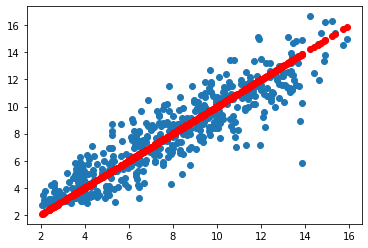

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


x_train, x_test, y_train, y_test = train_test_split(scaler_rnn_data, np.array(times_data), test_size=0.1, random_state=0)

batch_model = keras.Sequential()
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(1, kernel_initializer='normal'))

batch_model.compile(loss='mean_squared_error', optimizer='adam')


history_batch = batch_model.fit(x_train, y_train, batch_size=16, epochs=15, validation_data=(x_test, y_test), verbose=True)
batch_y_pred = batch_model.predict(x_test)
batch_y_pred = batch_y_pred.reshape(batch_y_pred.shape[0],)
plt.scatter(y_test, batch_y_pred)
plt.scatter(y_test, y_test, c='r')
plt.show()

In [ ]:
import datetime
now = datetime.datetime.now()
file_name = f'/home/jupyter/TrainDataCurrentRNN/{now.year}_{now.month}_{now.day}_{now.hour}_{now.minute}.json'
with open(f'{file_name}', 'w') as fp:
    json.dump(model_data, fp)
print(f'{end} data points saved!')